# Bishop Basement Model

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import pathlib
import pickle
import string

import numpy as np
import scipy as sp
import verde as vd
import xarray as xr
from polartoolkit import maps, profiles
from polartoolkit import utils as polar_utils

from invert4geom import (
    inversion,
    optimization,
    plotting,
    regional,
    synthetic,
    uncertainty,
    utils,
)

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

/home/mdtanker/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Get data

Here we will load a commonly used synthetic gravity and basement topography model, called the `Bishop Model`. It includes topography of the Moho and the sediment-basement contact, and the forward modelled gravity effect of each, providing a synthetic observed gravity dataset. The forward gravity is calculated with 6 layers of sediment which increase in density from 2100 kg/m3 at 0m to 2600 kg/m3 at the basement surface. Then 3 layers of increasing density from 2700 kg/m3 to 3300 kg/m3 at the Moho surface. 

In [2]:
grid = synthetic.load_bishop_model(coarsen_factor=50)
polar_utils.get_grid_info(grid.gravity, print_info=True)
grid

grid spacing: 10000.0 m
grid region: (6900.0, 376900.0, 145900.0, 535900.0)
grid zmin: 91.2694015503
grid zmax: 148.650238037
grid registration: g


<xarray.Dataset> Size: 37kB
Dimensions:        (northing: 40, easting: 38)
Coordinates:
  * easting        (easting) float64 304B 6.9e+03 1.69e+04 ... 3.769e+05
  * northing       (northing) float64 320B 1.459e+05 1.559e+05 ... 5.359e+05
Data variables:
    basement_topo  (northing, easting) float64 12kB -6.199e+03 ... -8.133e+03
    moho_topo      (northing, easting) float64 12kB -2.767e+04 ... -2.548e+04
    gravity        (northing, easting) float64 12kB 99.08 99.3 ... 108.4 107.0

## Define model domain parameters
To account for edge effects (decreasing gravity towards the edge of prism model), we will use a buffer region and a smaller inversion region so the prism model edge is further away from the inversion domain.

In [3]:
grav_spacing = polar_utils.get_grid_info(grid.gravity)[0]
topo_spacing = polar_utils.get_grid_info(grid.basement_topo)[0]

buffer_region = vd.get_region(
    (grid.basement_topo.easting.values, grid.basement_topo.northing.values),
)
inversion_region = vd.pad_region(buffer_region, -topo_spacing * 4)

print(f"gravity spacing: {grav_spacing}m")
print(f"topography spacing: {topo_spacing}m")

gravity spacing: 10000.0m
topography spacing: 10000.0m


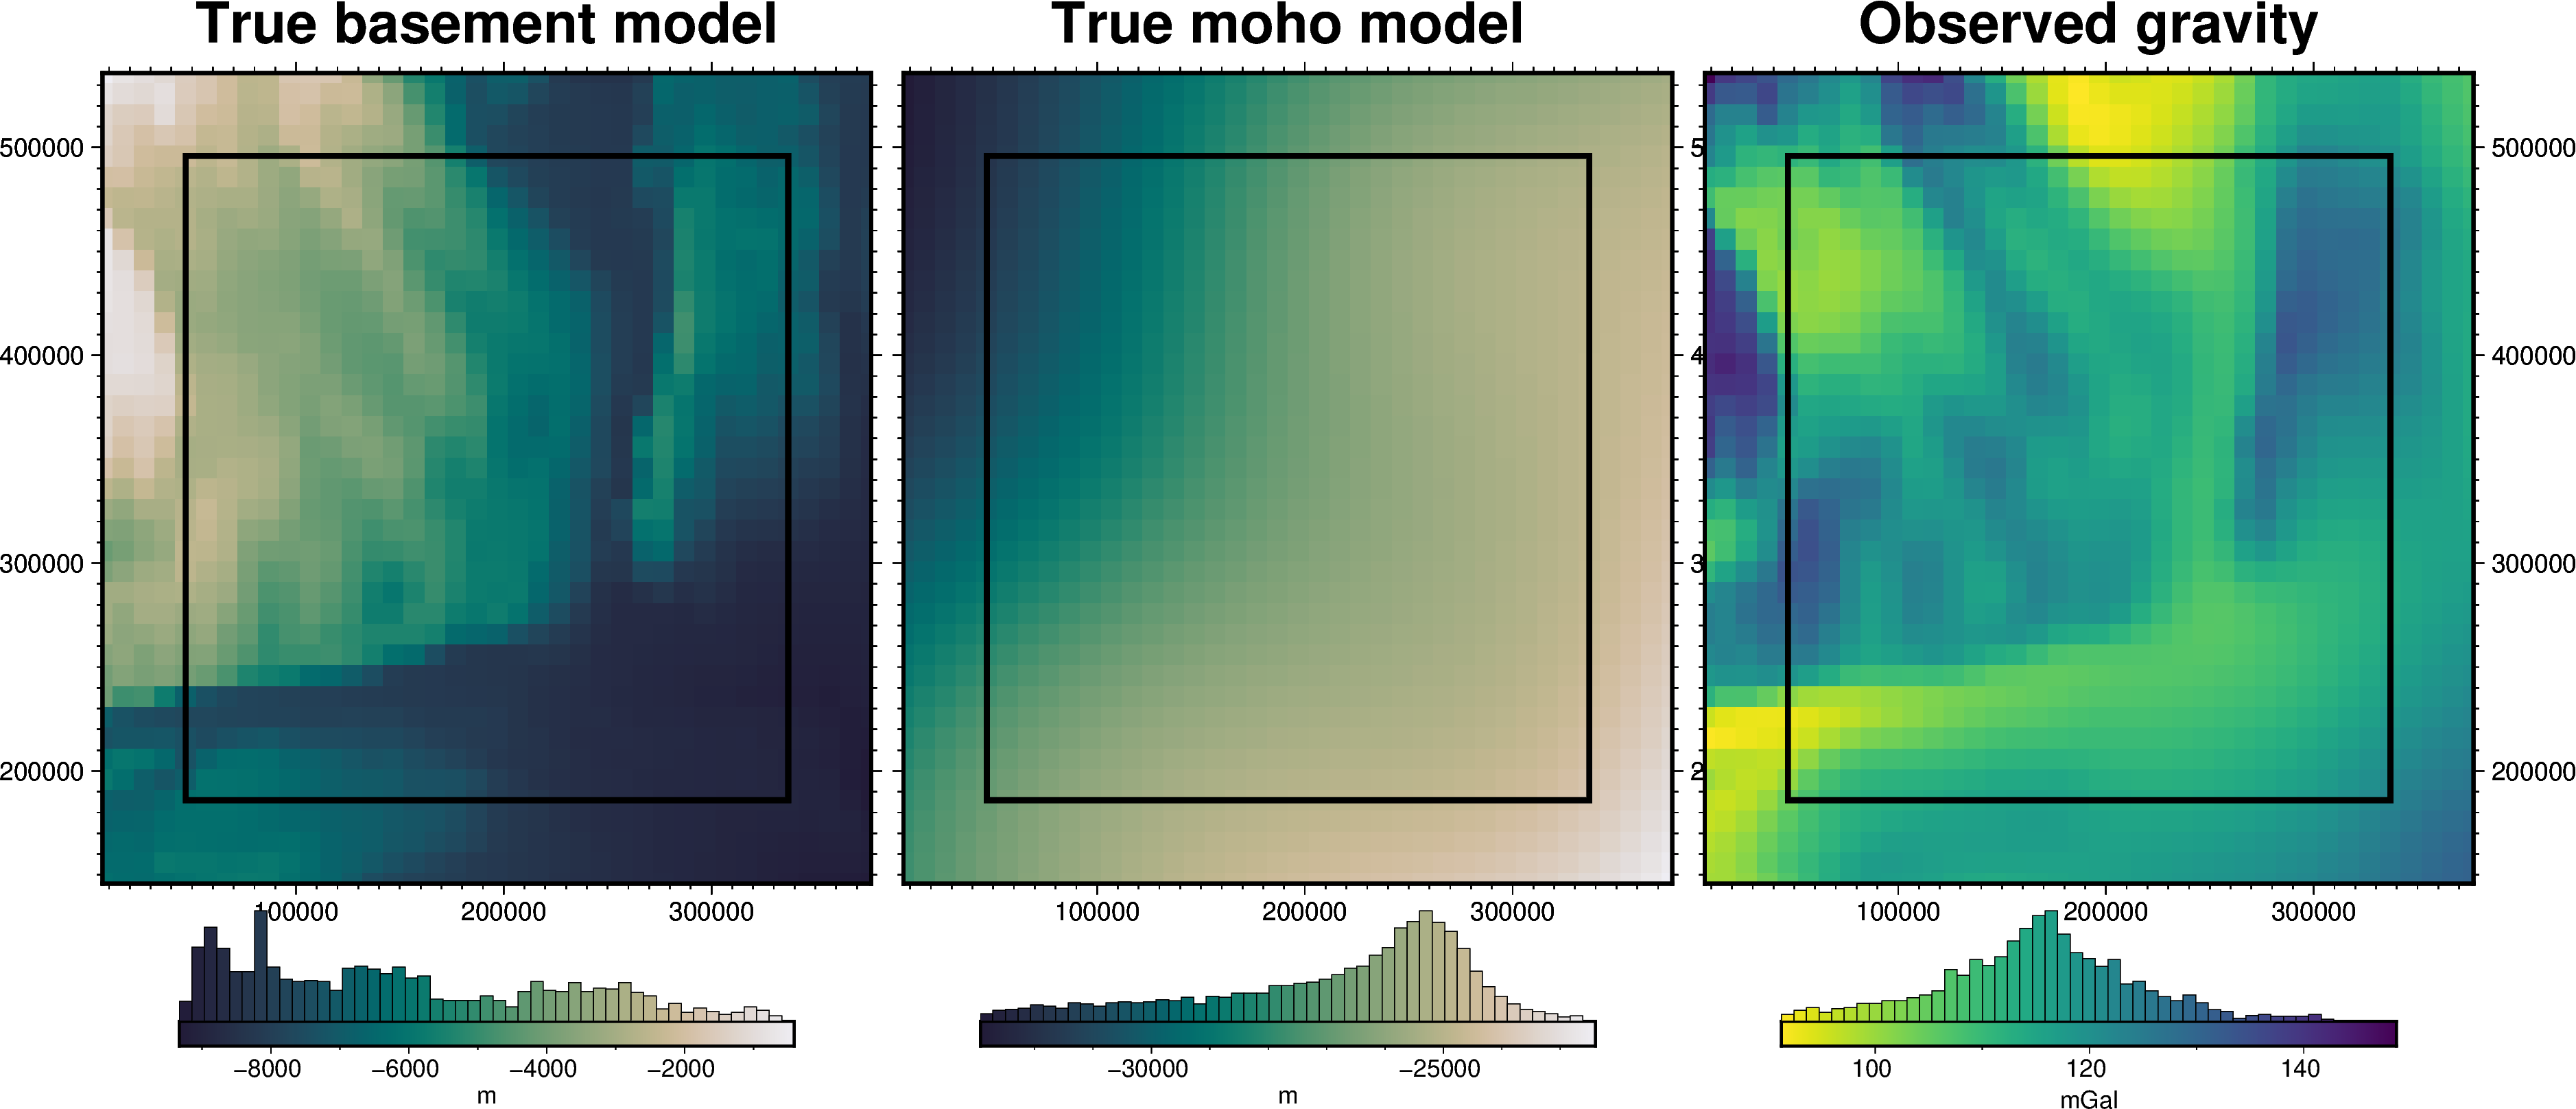

In [4]:
fig = maps.plot_grd(
    grid.basement_topo,
    fig_height=10,
    title="True basement model",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    hist=True,
    frame=["nSWe", "xaf10000", "yaf10000"],
    show_region=inversion_region,
)

fig = maps.plot_grd(
    grid.moho_topo,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="True moho model",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    hist=True,
    frame=["nSwE", "xaf10000", "yaf10000"],
    show_region=inversion_region,
)

fig = maps.plot_grd(
    grid.gravity,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Observed gravity",
    reverse_cpt=True,
    cmap="viridis",
    cbar_label="mGal",
    hist=True,
    frame=["nSwE", "xaf10000", "yaf10000"],
    show_region=inversion_region,
)

fig.show()

## Observed gravity data

In this scenario, we are treating the area as having no surface topography (surface elevation is flat and equal to the ellipsoid). In this case, there is no terrain mass effect, and therefore the gravity disturbance is equal to the topo-free disturbance.

In [5]:
# subset gravity to within inversion region
grav_grid = polar_utils.subset_grid(
    grid.gravity,
    region=inversion_region,
)
grav_df = grav_grid.rename("gravity_anomaly").to_dataframe().reset_index()

# contaminate gravity with 0.2 mGal of random noise
grav_df["gravity_anomaly"], stddev = synthetic.contaminate(
    grav_df.gravity_anomaly,
    stddev=0.2,
    percent=False,
    seed=0,
)
grav_df["uncert"] = stddev

grav_df["upward"] = 10
grav_df

INFO:invert4geom:Standard deviation used for noise: [0.2]


northing   easting  gravity_anomaly  uncert  upward
0    185900.0   46900.0       104.232718     0.2      10
1    185900.0   56900.0       107.751815     0.2      10
2    185900.0   66900.0       110.337816     0.2      10
3    185900.0   76900.0       111.850851     0.2      10
4    185900.0   86900.0       112.625425     0.2      10
..        ...       ...              ...     ...     ...
955  495900.0  296900.0       123.107795     0.2      10
956  495900.0  306900.0       122.626073     0.2      10
957  495900.0  316900.0       121.444072     0.2      10
958  495900.0  326900.0       120.206500     0.2      10
959  495900.0  336900.0       119.462902     0.2      10

[960 rows x 5 columns]

## Create "a-priori" basement measurements

In [6]:
# create grid of 36 points
coords = vd.grid_coordinates(
    region=vd.pad_region(inversion_region, -30e3),
    shape=(6, 6),
)
da = vd.make_xarray_grid(coords, data=np.ones_like(coords[0]), data_names="upward")
constraint_points = vd.grid_to_table(da).drop(columns=["upward"])

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points,
    grid.basement_topo,
    "true_upward",
)

constraint_points["upward"] = constraint_points.true_upward

# re-sample depths with uncertainty to emulate measurement errors
# set each points uncertainty equal to 2% of depth
uncert = np.abs(0.02 * constraint_points.upward)
constraint_points.loc[constraint_points.index, "true_uncert"] = uncert

constraint_points = uncertainty.randomly_sample_data(
    seed=0,
    data_df=constraint_points,
    data_col="upward",
    uncert_col="true_uncert",
)

# create weights column
constraint_points["weight"] = 1 / (constraint_points.true_uncert**2)

# create estimated uncertainty column
uncert = np.abs(0.02 * constraint_points.upward)
constraint_points.loc[constraint_points.index, "uncert"] = uncert

constraint_points.head()

northing   easting  true_upward       upward  true_uncert    weight  \
0  215900.0   76900.0 -7238.309570 -7220.108085   144.766191  0.000048   
1  215900.0  122900.0 -7554.403734 -7574.363204   151.088075  0.000044   
2  215900.0  168900.0 -8016.960820 -7914.275954   160.339216  0.000039   
3  215900.0  214900.0 -8420.098477 -8402.433090   168.401970  0.000035   
4  215900.0  260900.0 -8748.003562 -8841.724314   174.960071  0.000033   

       uncert  
0  144.402162  
1  151.487264  
2  158.285519  
3  168.048662  
4  176.834486

## Create starting basement model

In [7]:
# grid the sampled values using verde
starting_topography_kwargs = dict(
    method="splines",
    region=buffer_region,
    spacing=topo_spacing,
    constraints_df=constraint_points,
    # dampings=np.logspace(-40, 0, 200),
    dampings=None,
    # weights=constraint_points.weight,
)

starting_topography = utils.create_topography(
    **starting_topography_kwargs,
)

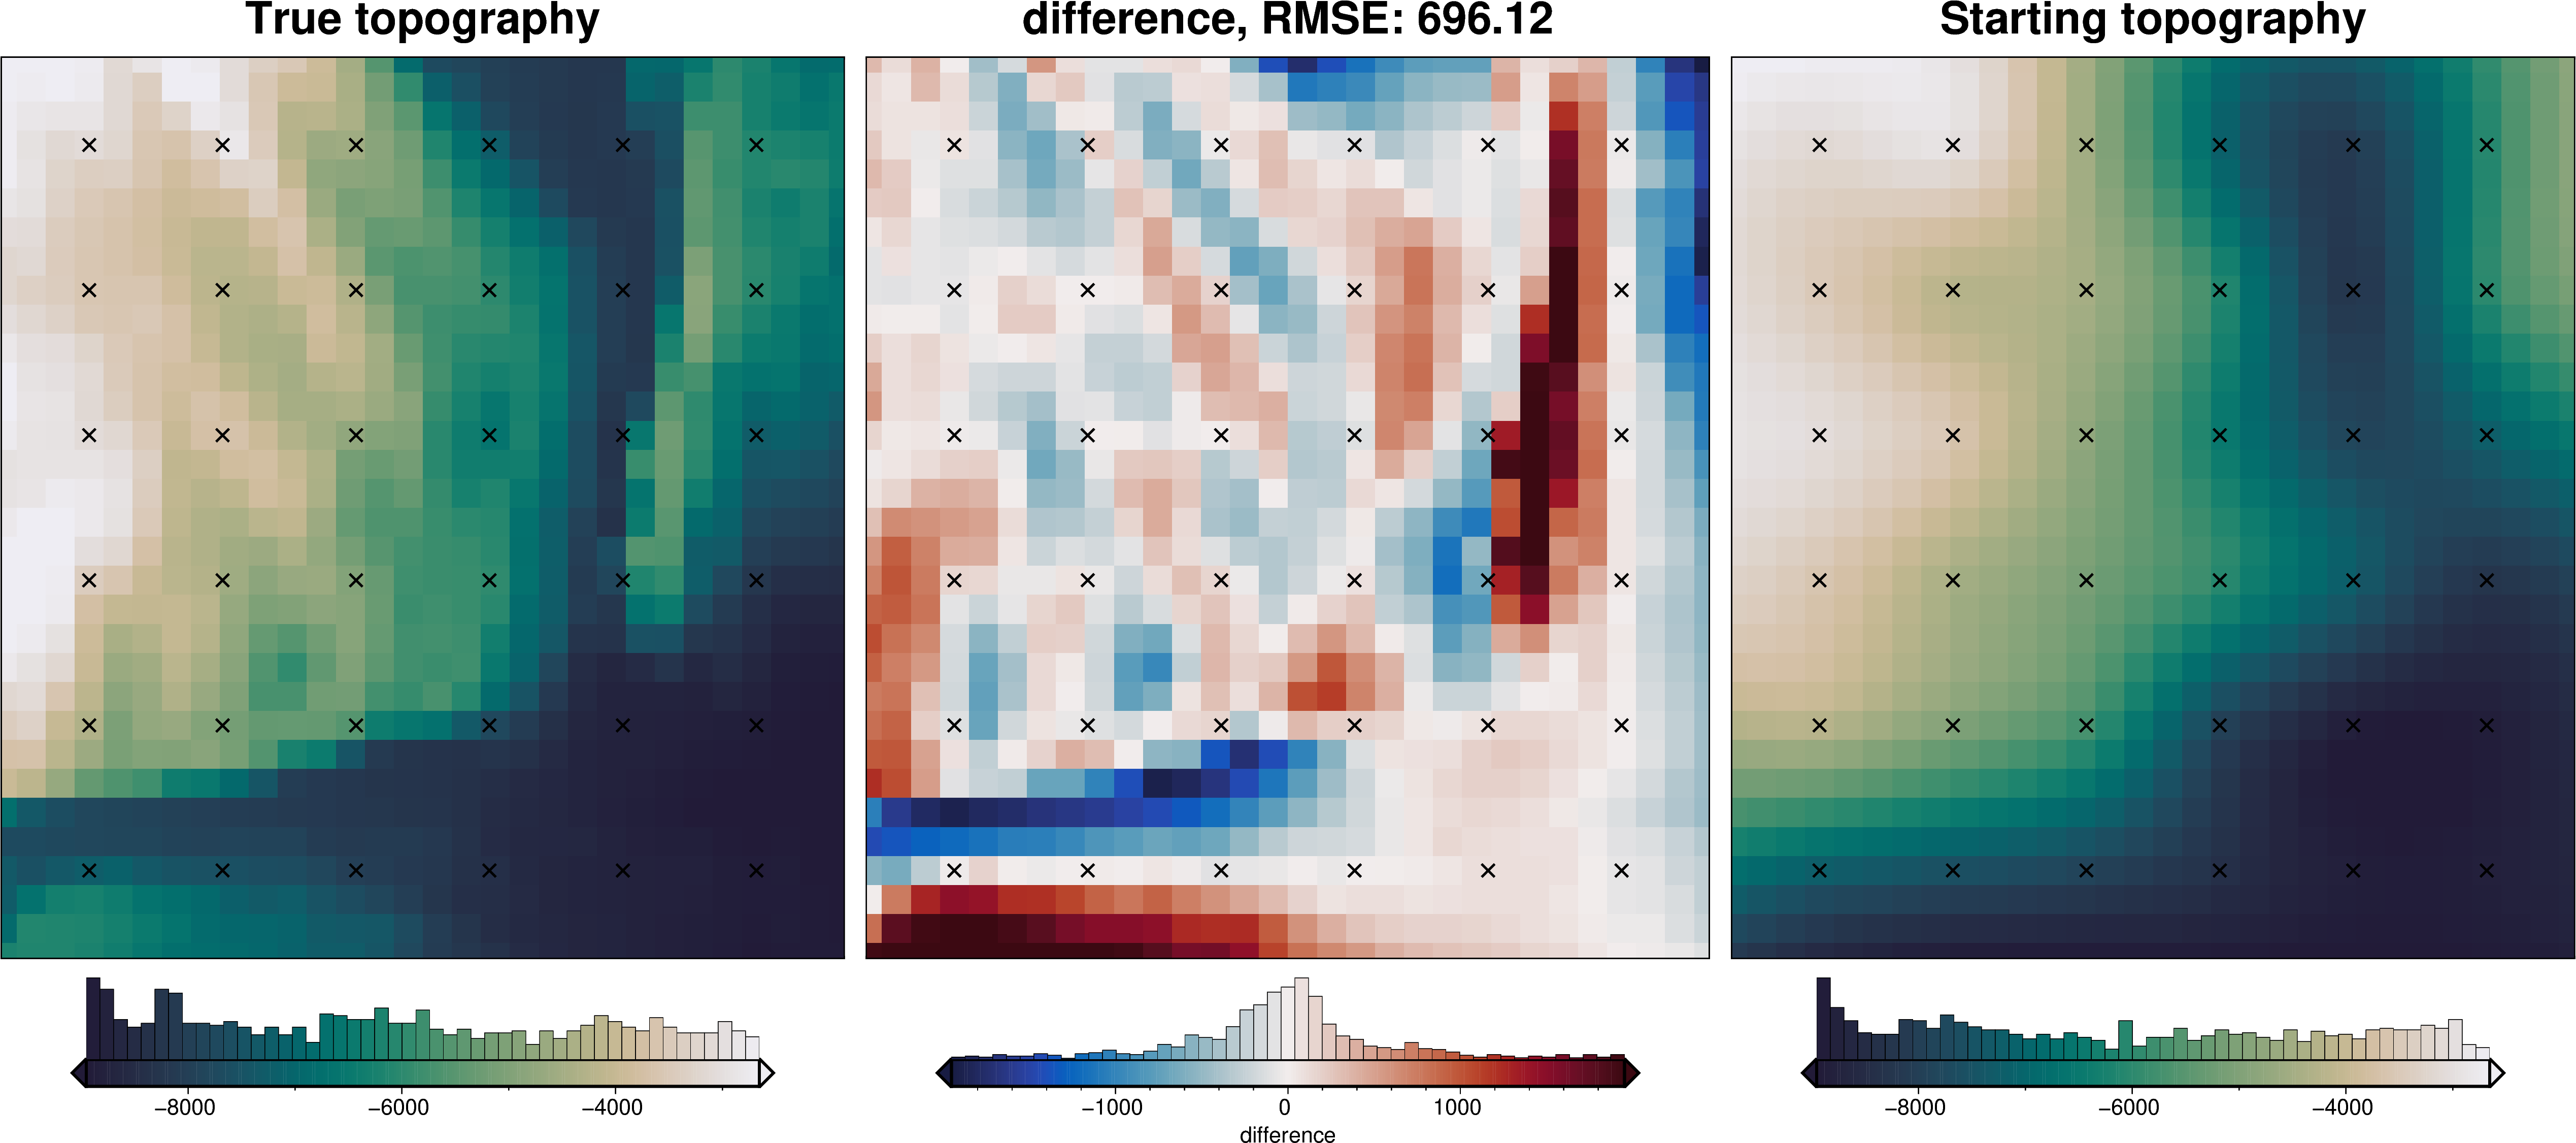

In [8]:
_ = polar_utils.grd_compare(
    grid.basement_topo,
    starting_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

In [9]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    starting_topography,
    "starting_topography",
)

rmse = utils.rmse(constraint_points.true_upward - constraint_points.starting_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 83.74 m


zref: -6154.32 m
density contrast: 500 kg/m^3


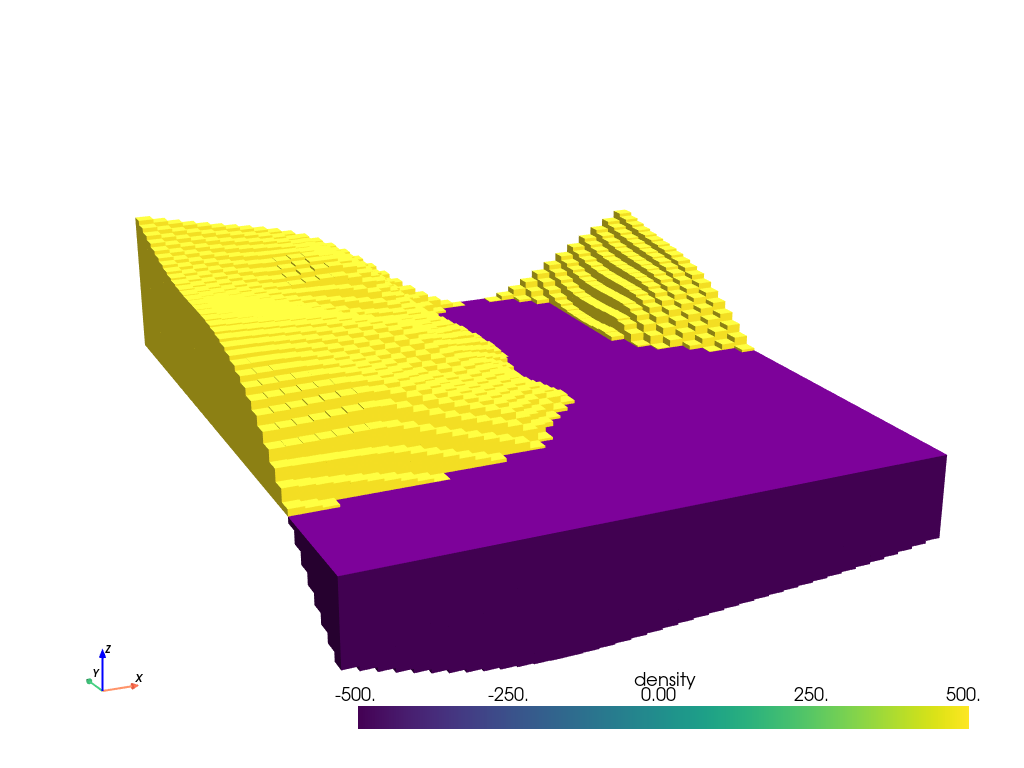

In [10]:
# pick a reference height for the basement
zref = constraint_points.upward.mean()

print(f"zref: {zref:.2f} m")

# pick a density contrast for the basement (crystalline basement - sedimentary rocks)
density_contrast = 2800 - 2300
print(f"density contrast: {density_contrast} kg/m^3")

density_grid = xr.where(
    starting_topography >= zref, density_contrast, -density_contrast
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)

plotting.show_prism_layers(
    starting_prisms,
    color_by="density",
    log_scale=False,
    zscale=20,
    backend="static",
)

## Gravity misfit

All inversions in Invert4Geom are based on a gravity misfit, not a gravity anomaly. This means before the inversion, we must create a starting prism model, forward model it's gravity effect, remove it from the gravity anomaly, and get a gravity misfit. 

However, if we know nothing about the starting model, it can simply be a flat layer of zero thickness, as we will use here. In this case, the forward gravity would just be zero so there is no need to perform the forward modelling. The misfit is therefore just equal to the topo-free disturbance.

### Forward gravity of starting prism layer

In [12]:
# calculate forward gravity of starting prism layer
grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df.describe()

  0%|          | 0/960 [00:00<?, ?it/s]

northing        easting  gravity_anomaly        uncert  upward  \
count     960.00000     960.000000       960.000000  9.600000e+02   960.0   
mean   340900.00000  191900.000000       114.520059  2.000000e-01    10.0   
std     92379.05319   86599.530158         7.763839  2.777004e-17     0.0   
min    185900.00000   46900.000000        93.175766  2.000000e-01    10.0   
25%    263400.00000  116900.000000       109.350740  2.000000e-01    10.0   
50%    340900.00000  191900.000000       114.195821  2.000000e-01    10.0   
75%    418400.00000  266900.000000       119.704208  2.000000e-01    10.0   
max    495900.00000  336900.000000       135.144508  2.000000e-01    10.0   

       starting_gravity  
count        960.000000  
mean           0.582511  
std           37.603658  
min          -54.212925  
25%          -31.235270  
50%           -3.993163  
75%           34.417141  
max           70.702624

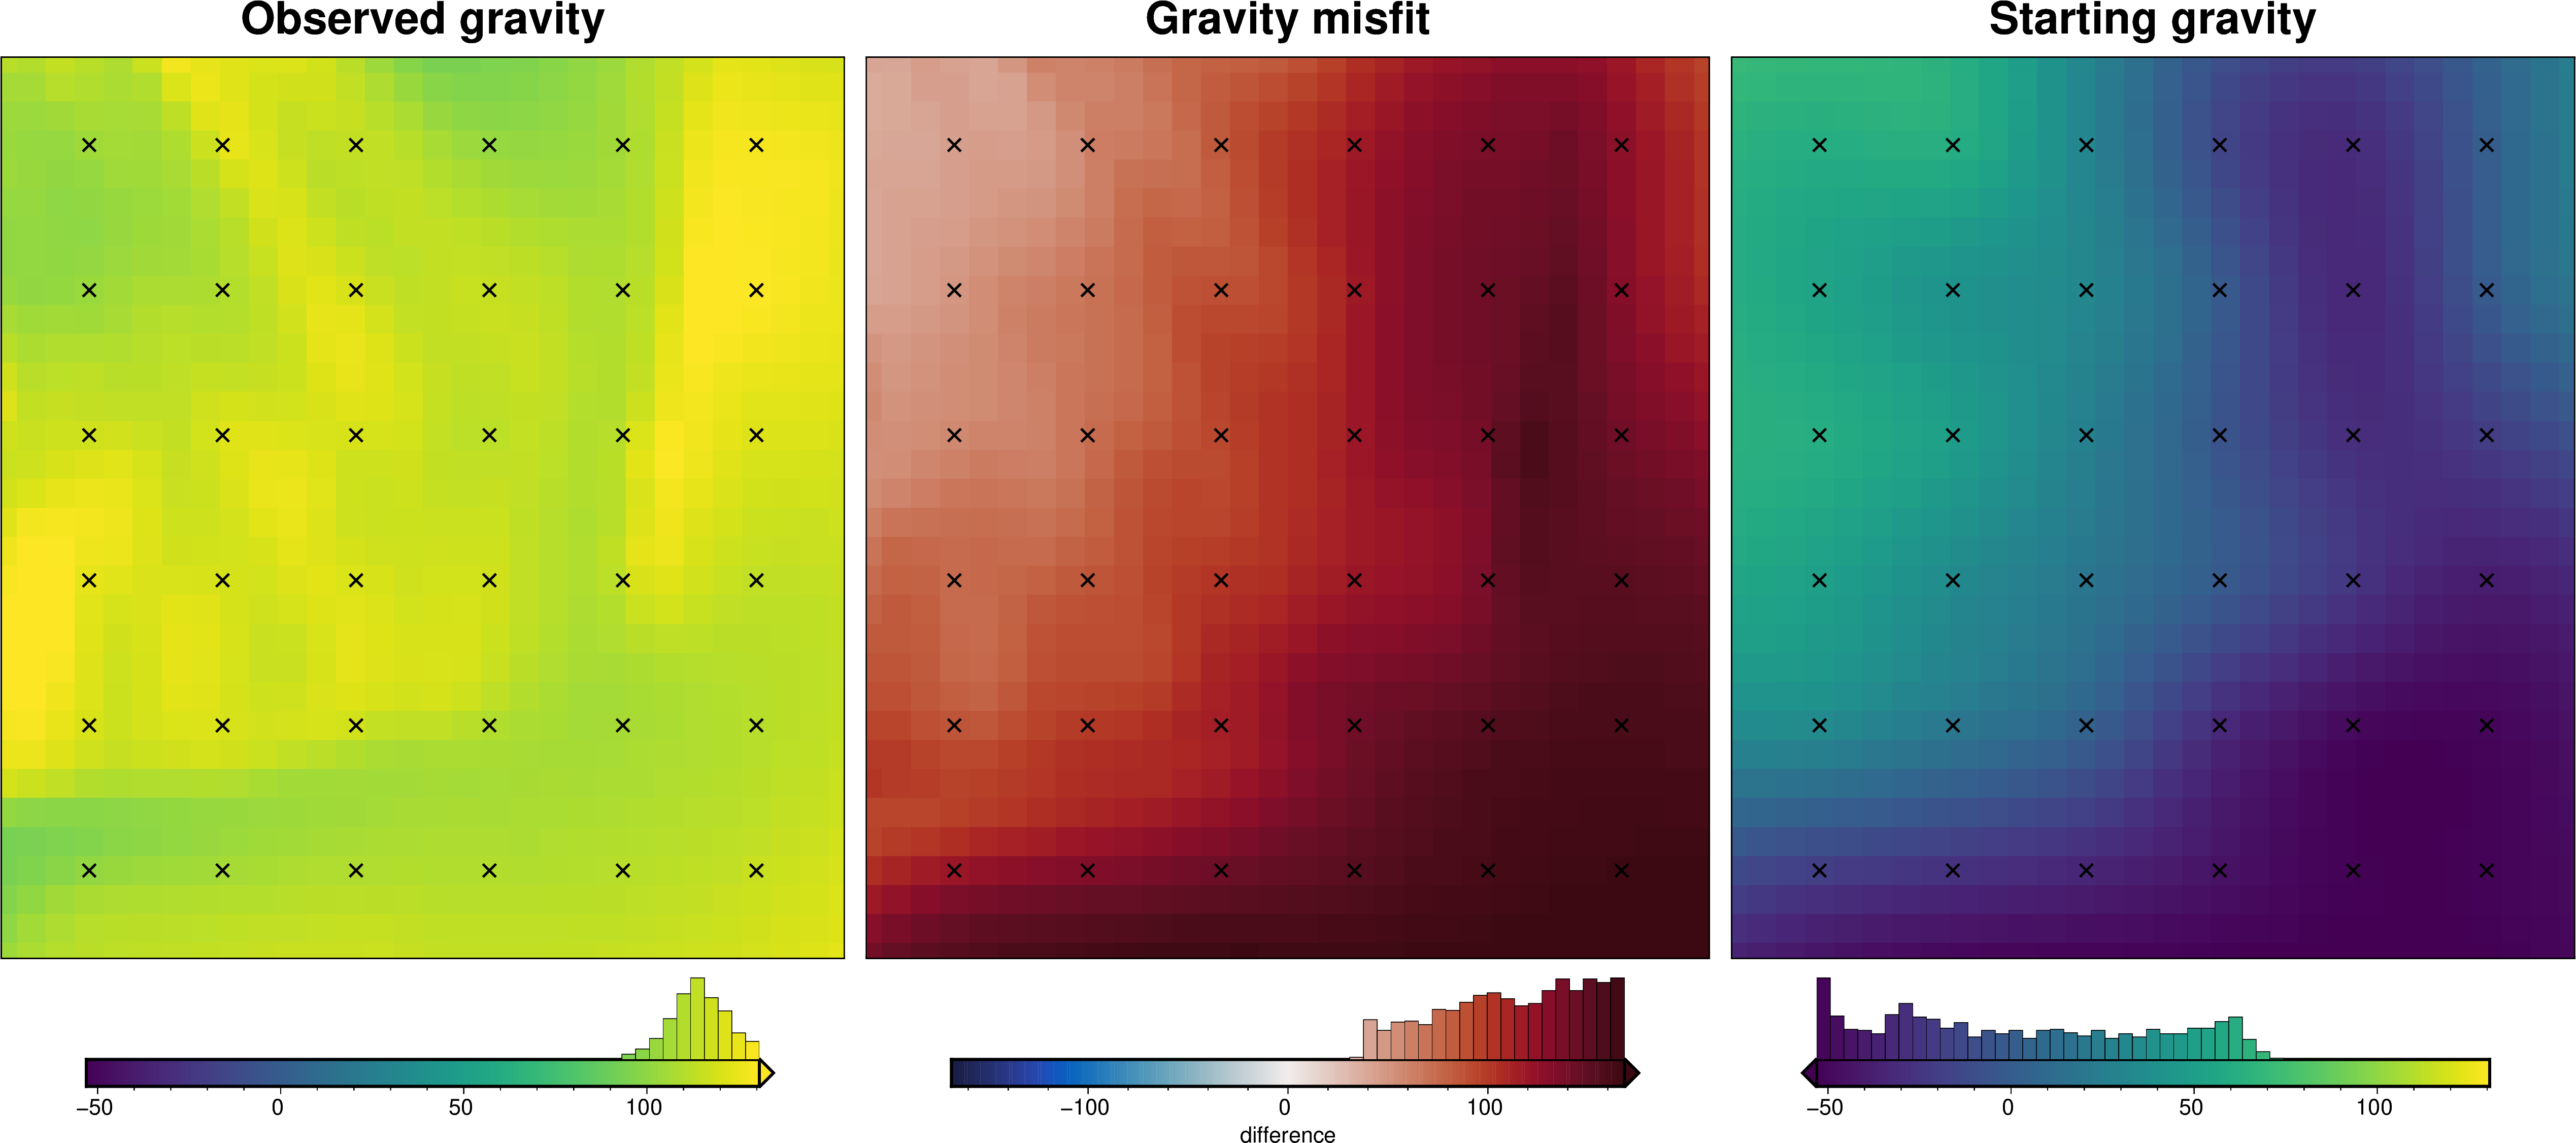

In [13]:
# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

_ = polar_utils.grd_compare(
    grav_grid.gravity_anomaly,
    grav_grid.starting_gravity,
    plot=True,
    grid1_name="Observed gravity",
    grid2_name="Starting gravity",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="Gravity misfit",
    rmse_in_title=False,
    grounding_line=False,
    points=constraint_points,
    points_style="x.3c",
)

## Regional estimation - constraint point minimization

In [14]:
# use the constraints to find the best regional field
regional_grav_kwargs = dict(
    method="constraints",
    grid_method="eq_sources",
    constraints_df=constraint_points,
    # constraints_weights_column="weight",
    cv=True,
    cv_kwargs=dict(
        n_trials=50,
        damping_limits=(1e-60, 10),
        depth_limits=(100, 1000e3),
        progressbar=False,
        fname="../tmp/regional_sep",
    ),
    # damping=None,
    # depth="default",
    block_size=None,
)

grav_df = regional.regional_separation(
    grav_df=grav_df,
    **regional_grav_kwargs,
)
grav_df.describe()

INFO:invert4geom:using 12 startup trials
INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 41
INFO:invert4geom:	parameter: {'depth': 1000000.0, 'damping': 2.4540720612818677e-12}
INFO:invert4geom:	scores: [0.9830419087005984]


northing        easting  gravity_anomaly        uncert  upward  \
count     960.00000     960.000000       960.000000  9.600000e+02   960.0   
mean   340900.00000  191900.000000       114.520059  2.000000e-01    10.0   
std     92379.05319   86599.530158         7.763839  2.777004e-17     0.0   
min    185900.00000   46900.000000        93.175766  2.000000e-01    10.0   
25%    263400.00000  116900.000000       109.350740  2.000000e-01    10.0   
50%    340900.00000  191900.000000       114.195821  2.000000e-01    10.0   
75%    418400.00000  266900.000000       119.704208  2.000000e-01    10.0   
max    495900.00000  336900.000000       135.144508  2.000000e-01    10.0   

       starting_gravity      misfit         reg         res  
count        960.000000  960.000000  960.000000  960.000000  
mean           0.582511  113.937547  112.843109    1.094438  
std           37.603658   36.916181   36.475671    5.494985  
min          -54.212925   37.206871   31.244129  -13.166965  
25%          -31.235270   85.587535   83.467545   -2.190083  
50%           -3.993163  118.326304  119.508010    0.505858  
75%           34.417141  145.546217  141.702138    3.815498  
max           70.702624  173.155317  171.947845   23.303485

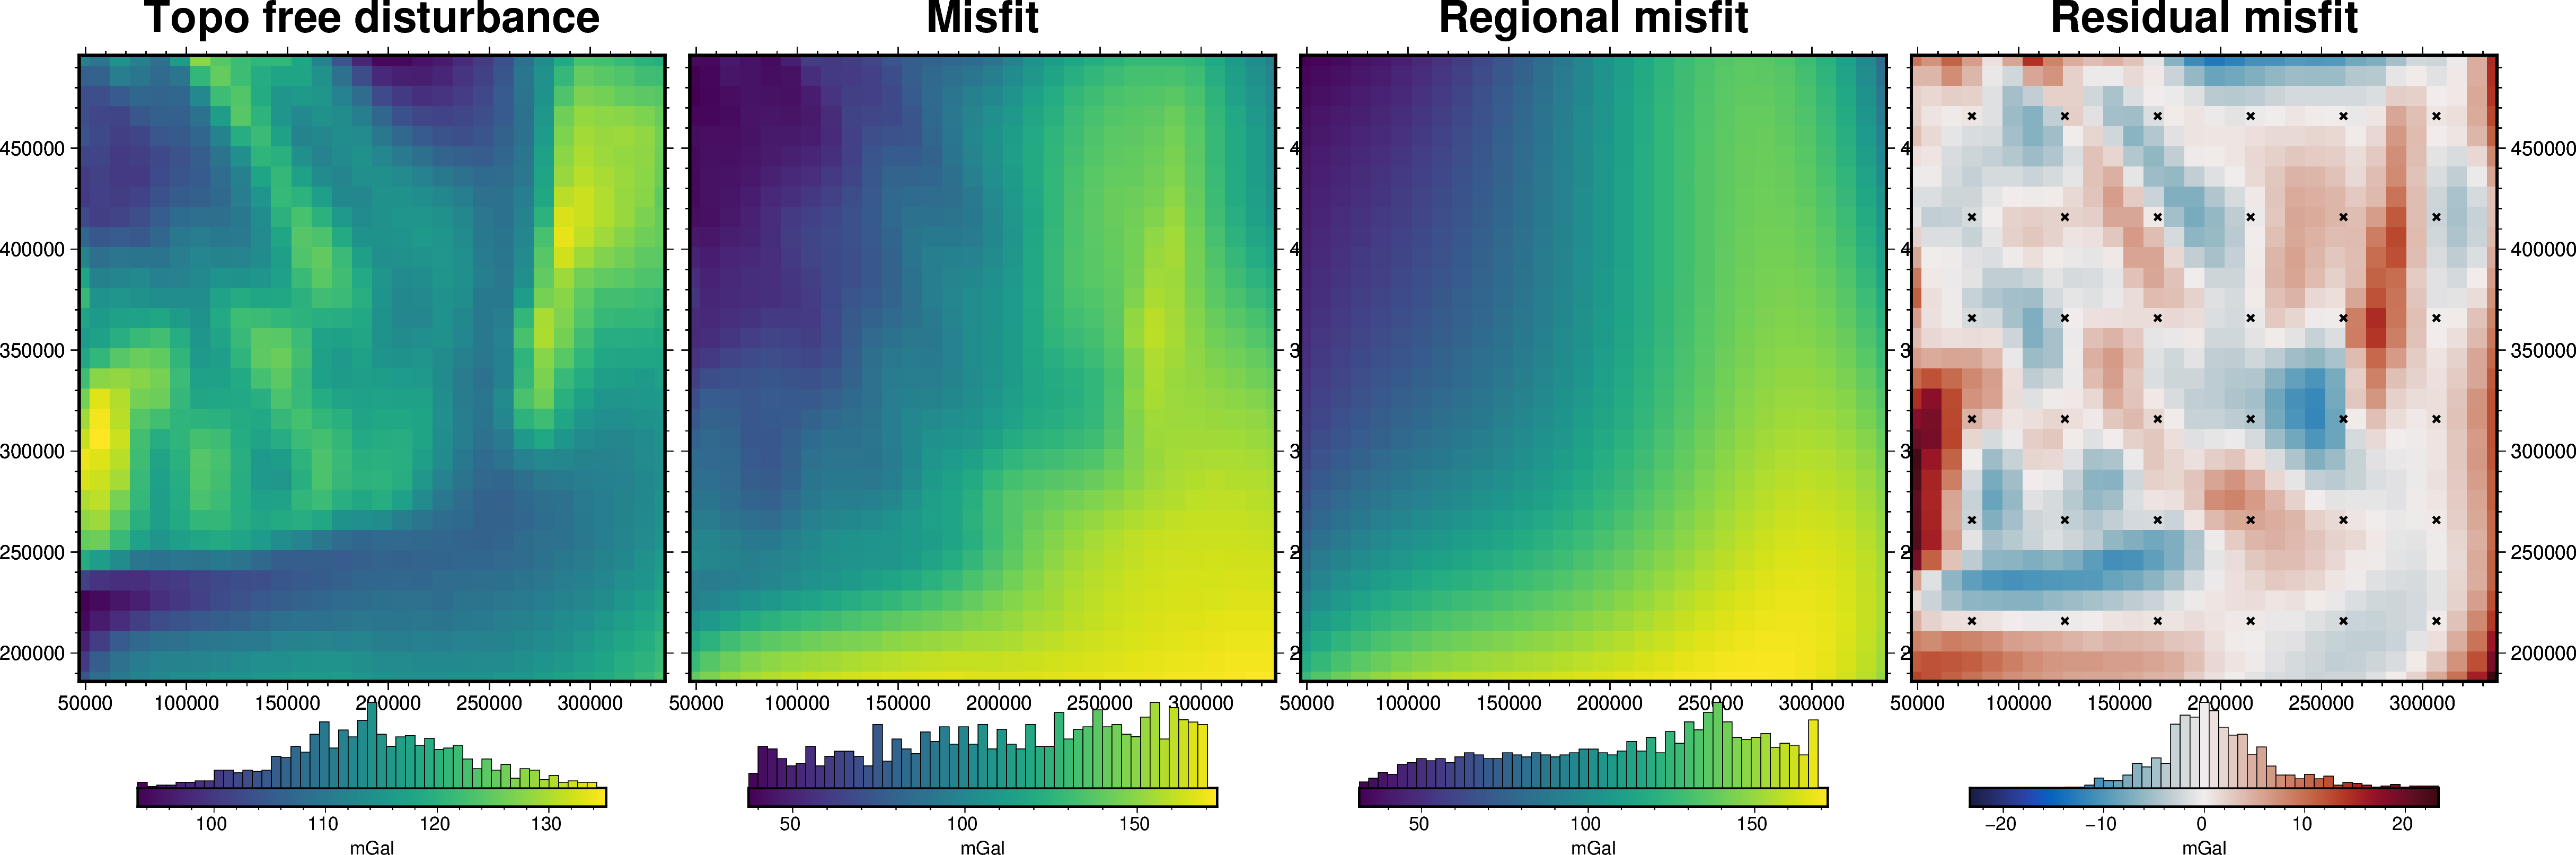

In [15]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    region=inversion_region,
    fig_height=10,
    title="Topo free disturbance",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    region=inversion_region,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Misfit",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    region=inversion_region,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Regional misfit",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    region=inversion_region,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_grid.res), vd.maxabs(grav_grid.res)],
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraint_points,
    points_style="x.15c",
)
fig.show()

## Single inversion
Perform a single inversion to experiment with values of stopping criteria.

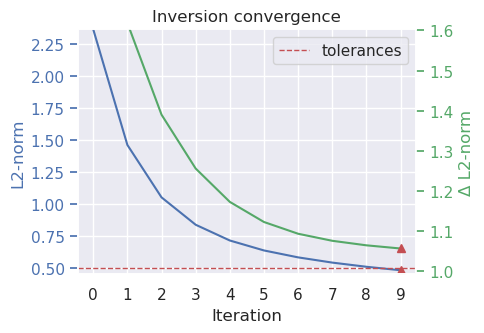

In [16]:
# set kwargs to pass to the inversion
kwargs = {
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": 0.5,
    "delta_l2_norm_tolerance": 1.008,
}

# run the inversion workflow, including a cross validation for the damping parameter
inversion_results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    solver_damping=0.01,
    fname="../tmp/bishop_model",
    starting_prisms=starting_prisms,
    plot_dynamic_convergence=True,
    **kwargs,
)

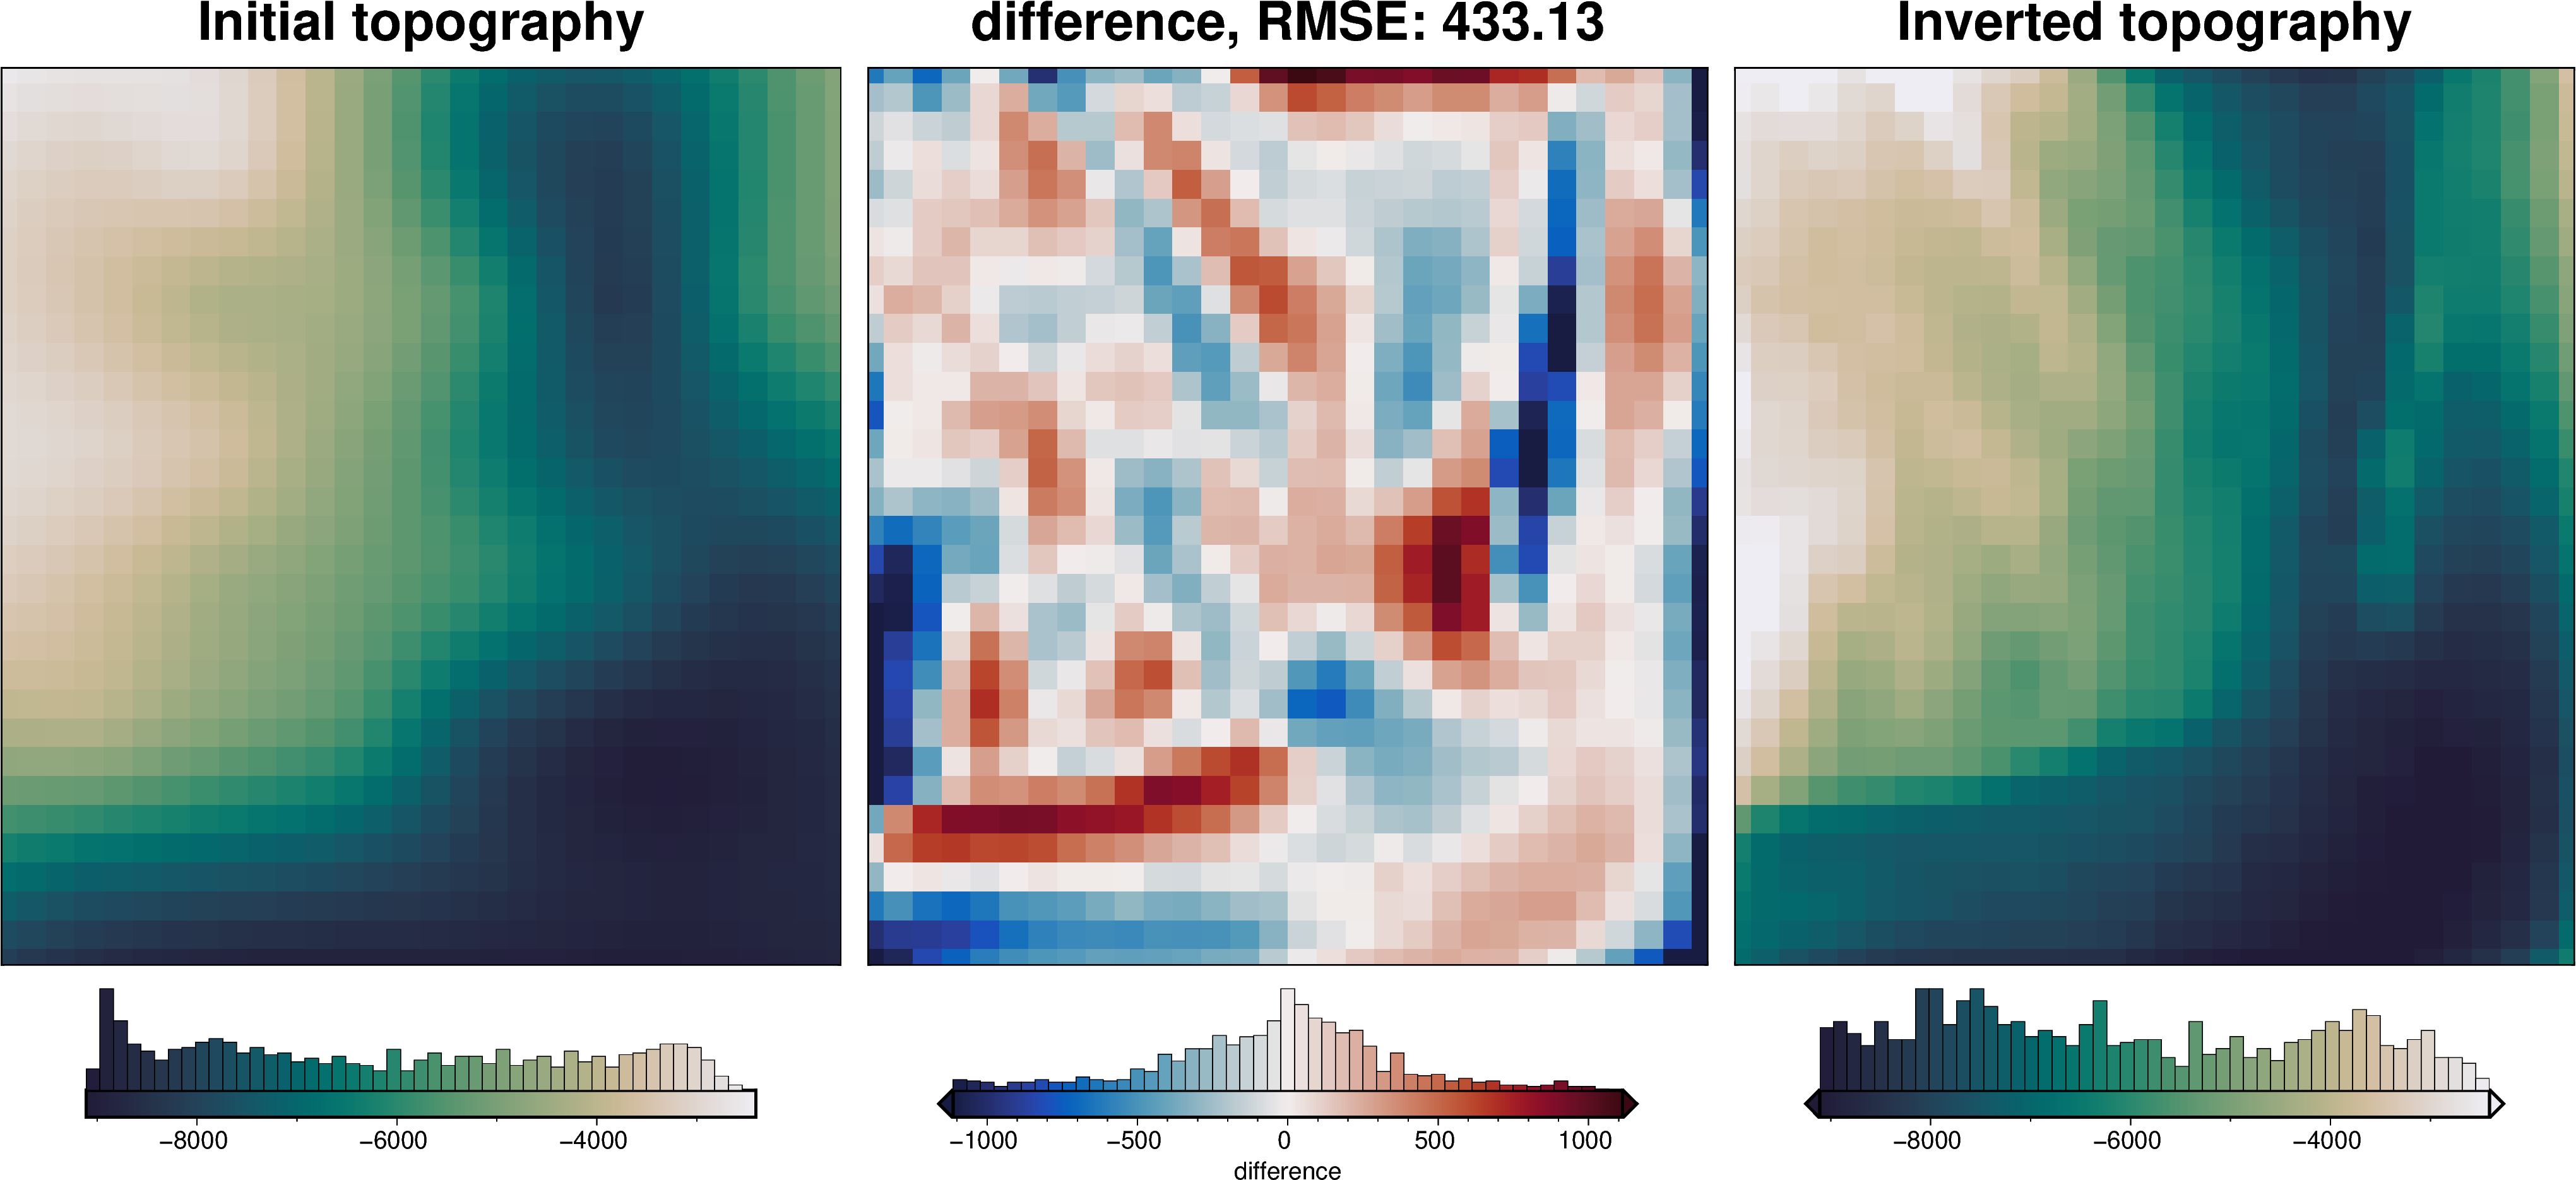

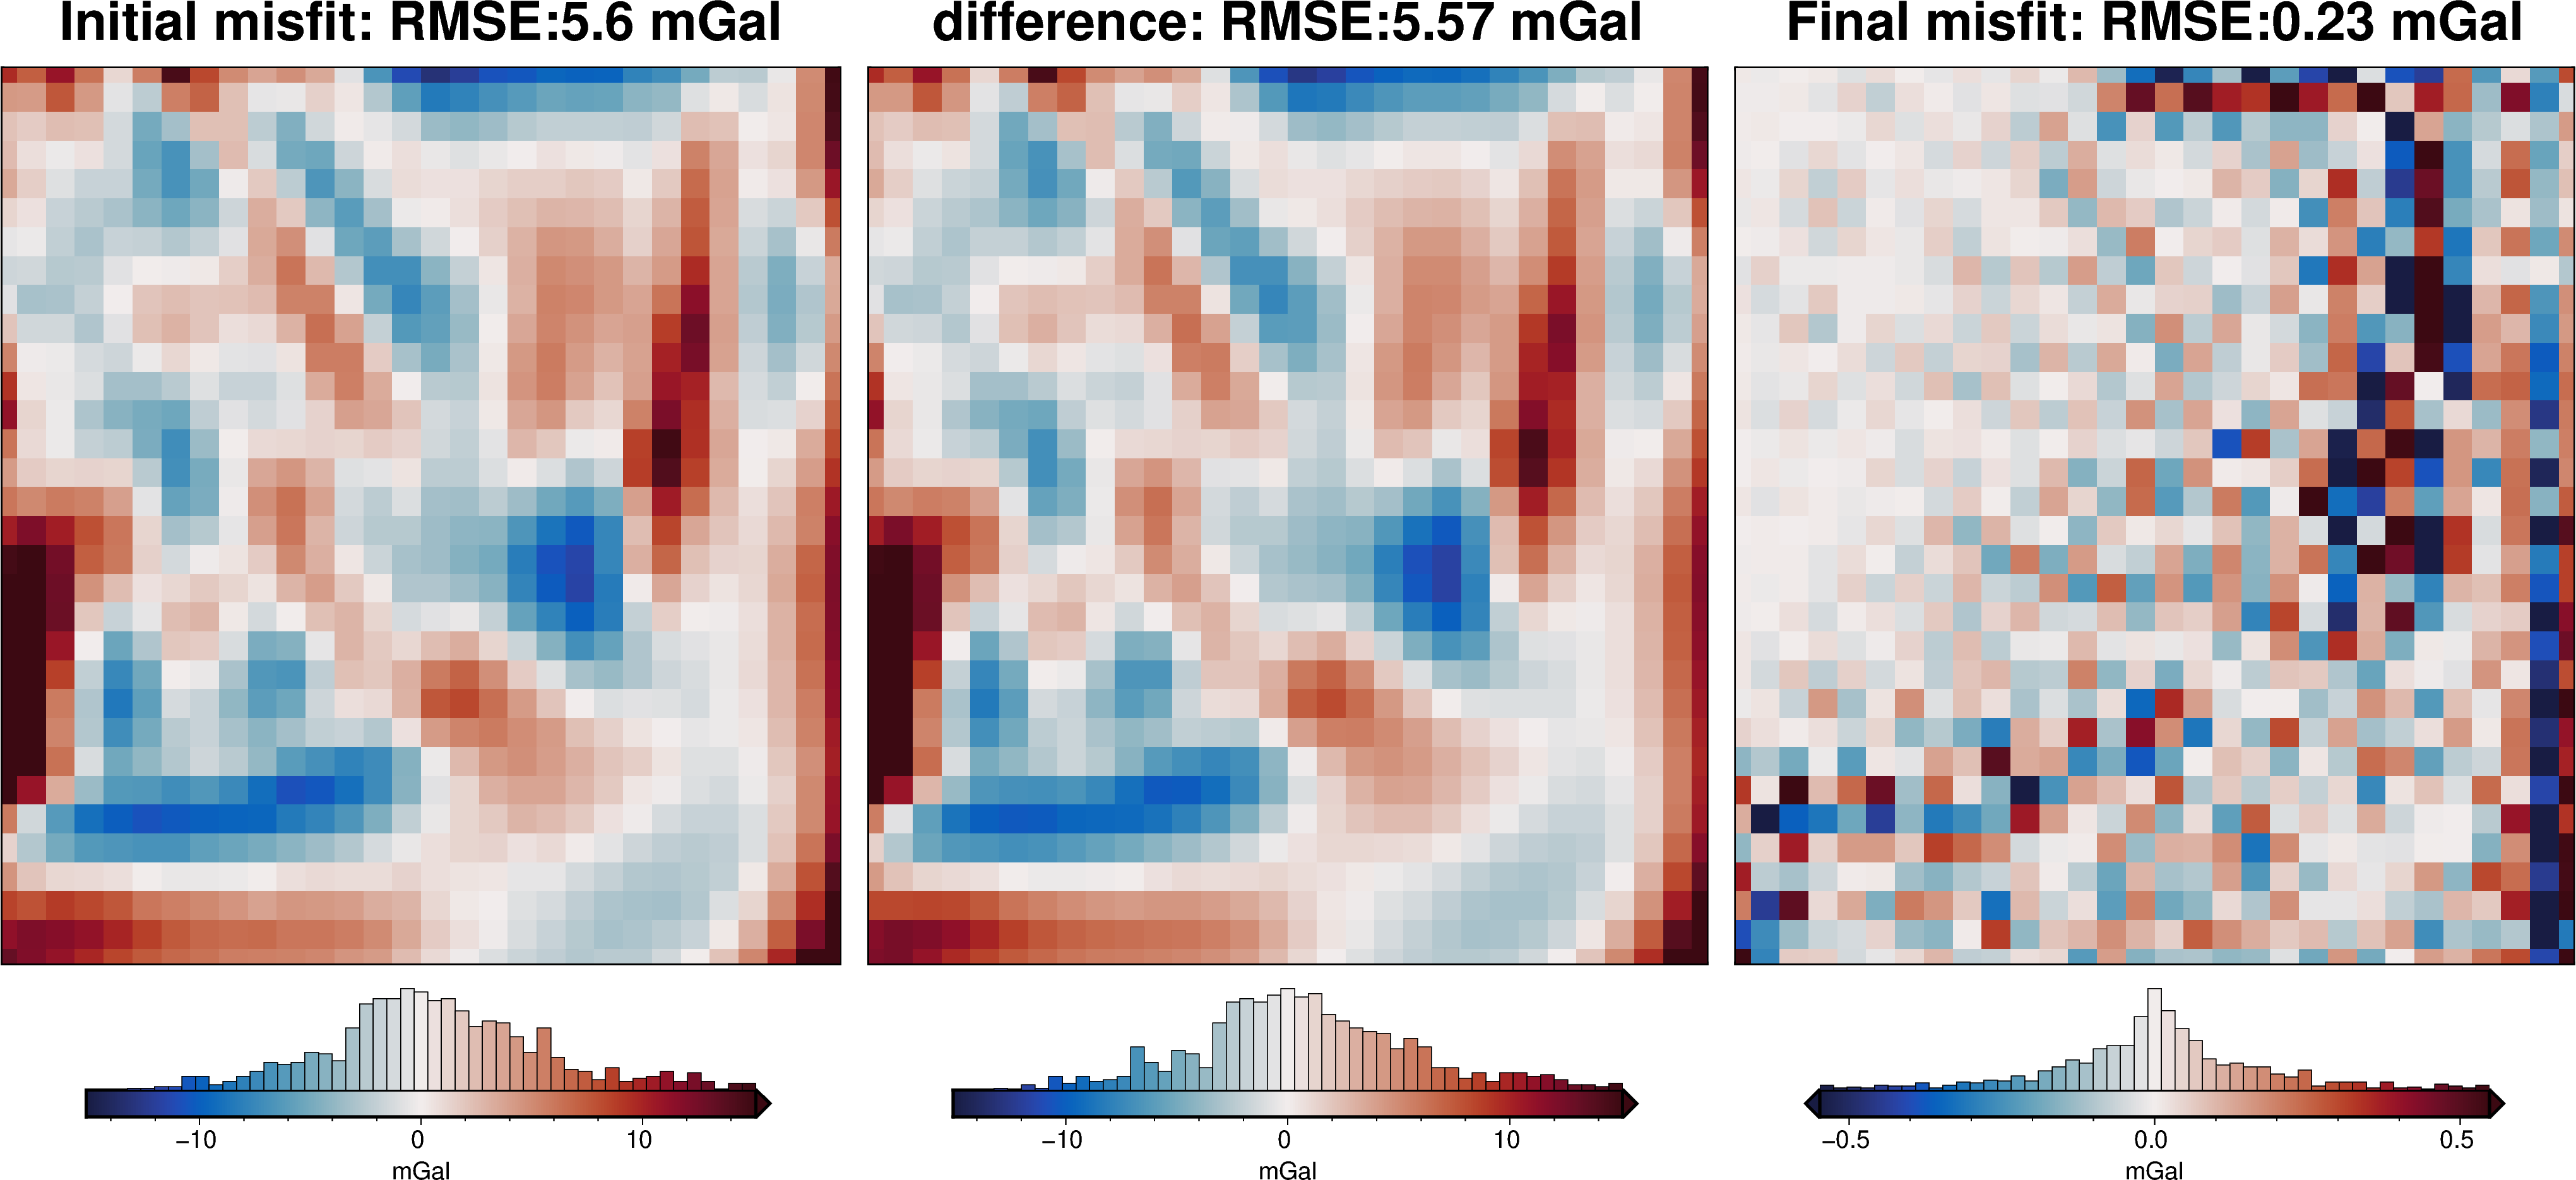

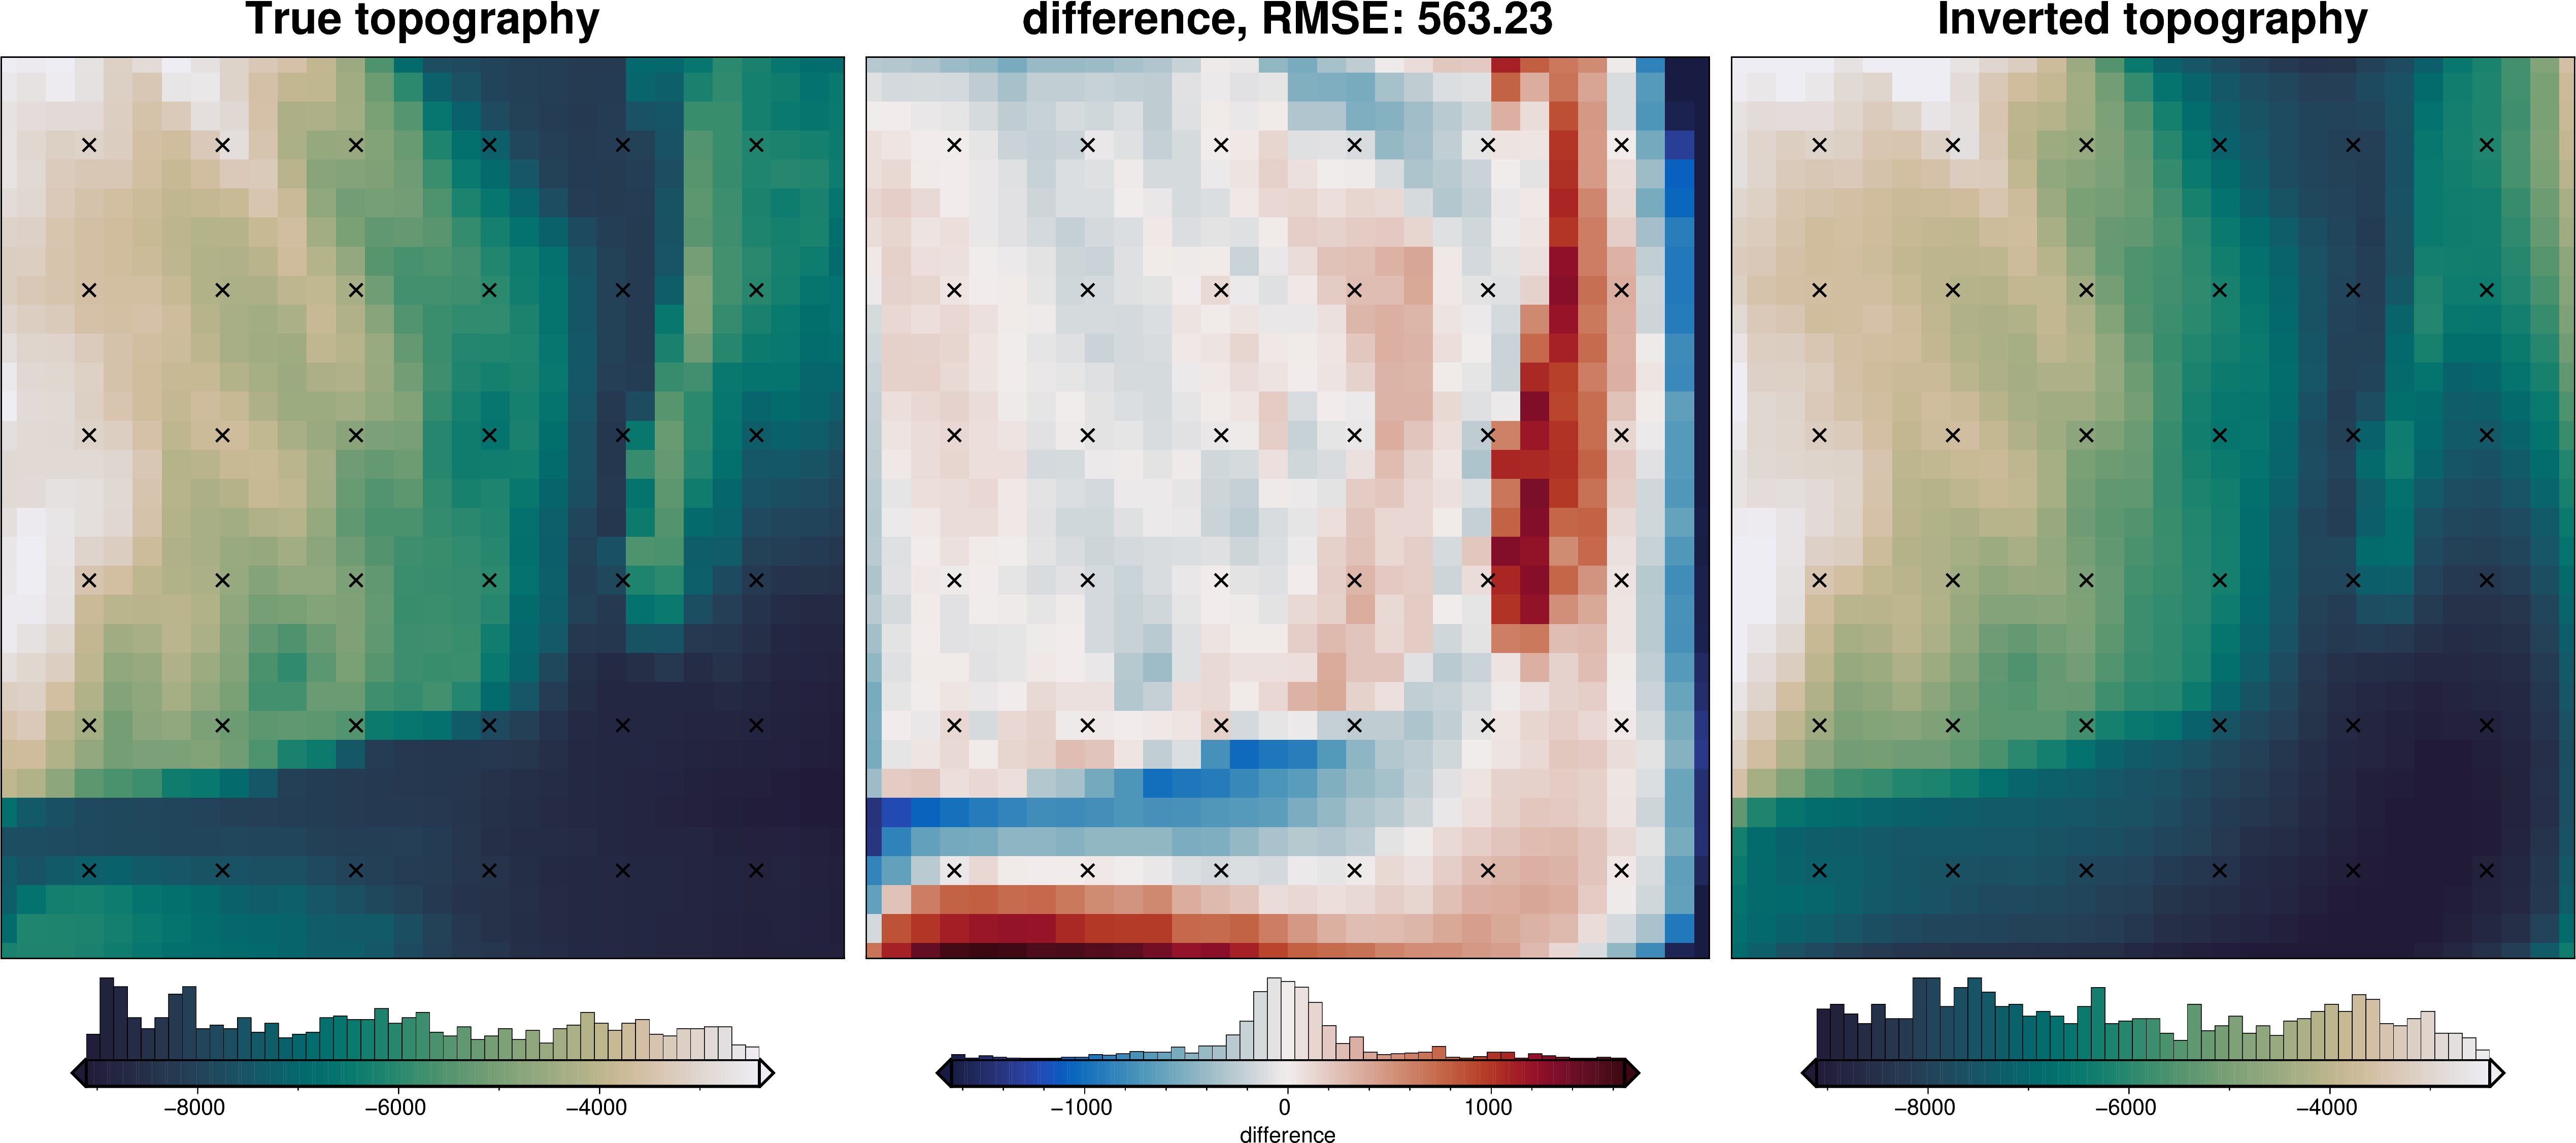

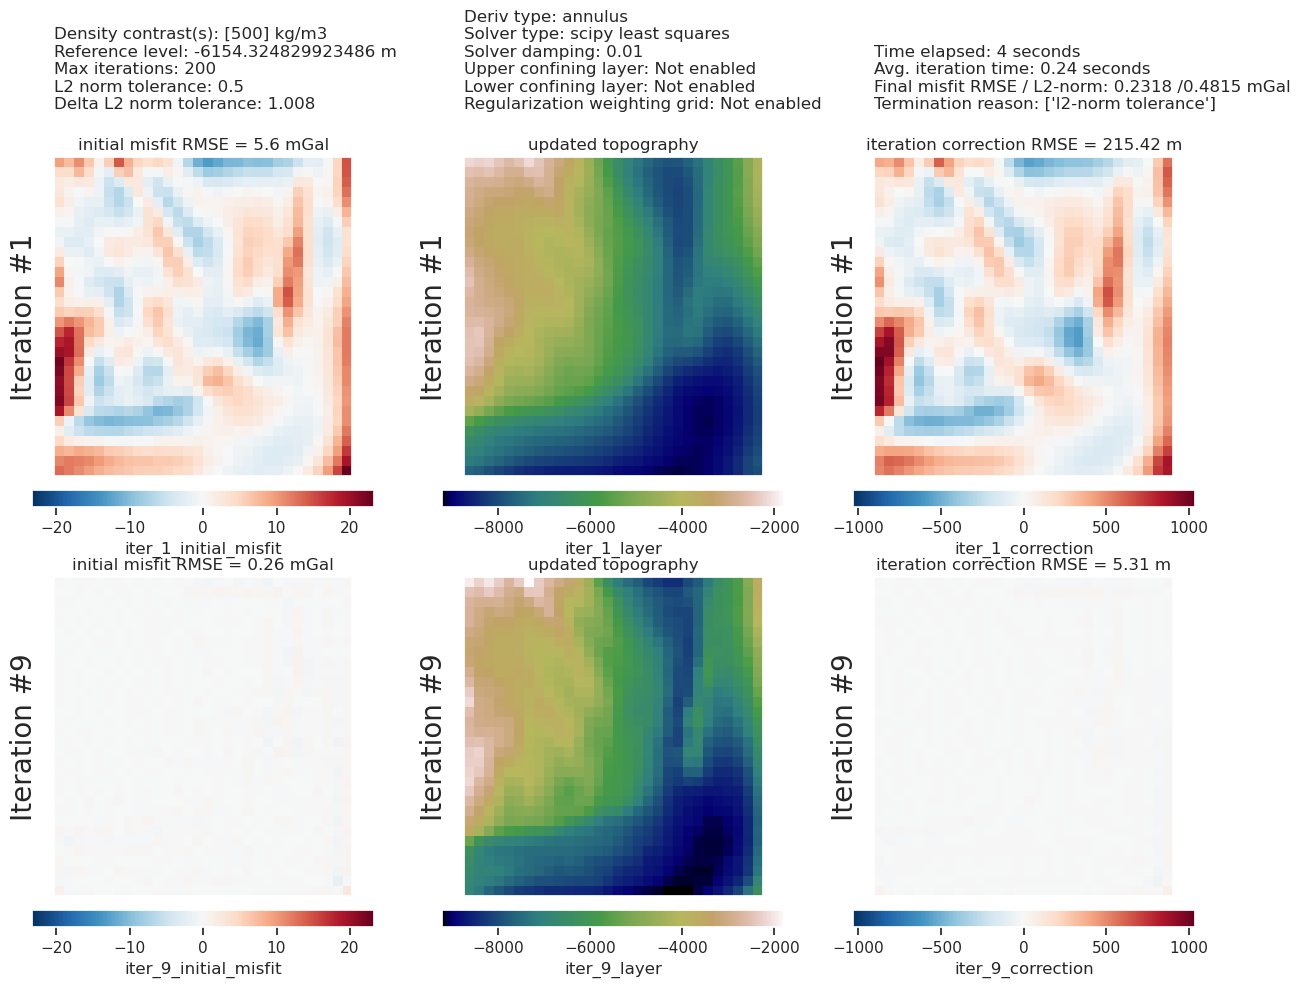

In [17]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    grid.basement_topo,
    final_topography,
    plot=True,
    region=inversion_region,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

## Damping parameter cross validation

INFO:invert4geom:saving all results with root name '../tmp/bishop_model'
INFO:invert4geom:running damping cross validation
INFO:invert4geom:using 4 startup trials


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 6
INFO:invert4geom:	parameter: {'damping': 0.004809585422671533}
INFO:invert4geom:	scores: [0.19099848703886577]
INFO:invert4geom:results saved to ../tmp/bishop_model_results.pickle.pickle


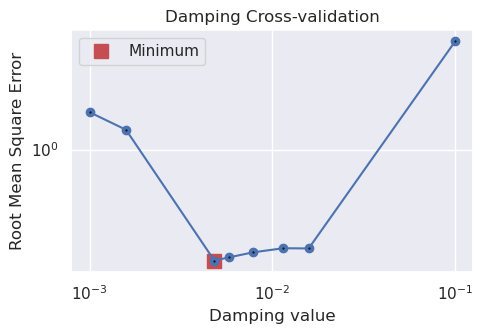

In [18]:
# run the inversion workflow, including a cross validation for the damping parameter
inversion_results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    run_damping_cv=True,
    damping_limits=(0.001, 0.1),
    damping_cv_trials=8,
    plot_cv=True,
    fname="../tmp/bishop_model",
    starting_prisms=starting_prisms,
    # score_as_median=True,
    # for creating test/train splits
    grav_spacing=grav_spacing,
    inversion_region=inversion_region,
    **kwargs,
)

In [19]:
# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/bishop_model_damping_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

# to re-load the inversion results from the saved pickle file
with pathlib.Path("../tmp/bishop_model_damping_cv_results.pickle").open("rb") as f:
    inversion_results = pickle.load(f)

In [20]:
best_damping = study.best_params.get("damping")

# add best damping parameter to kwargs
kwargs["solver_damping"] = best_damping

best_damping

0.004809585422671533

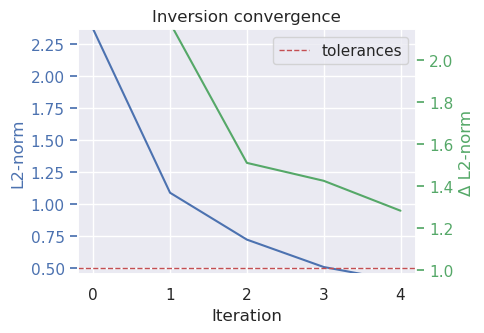

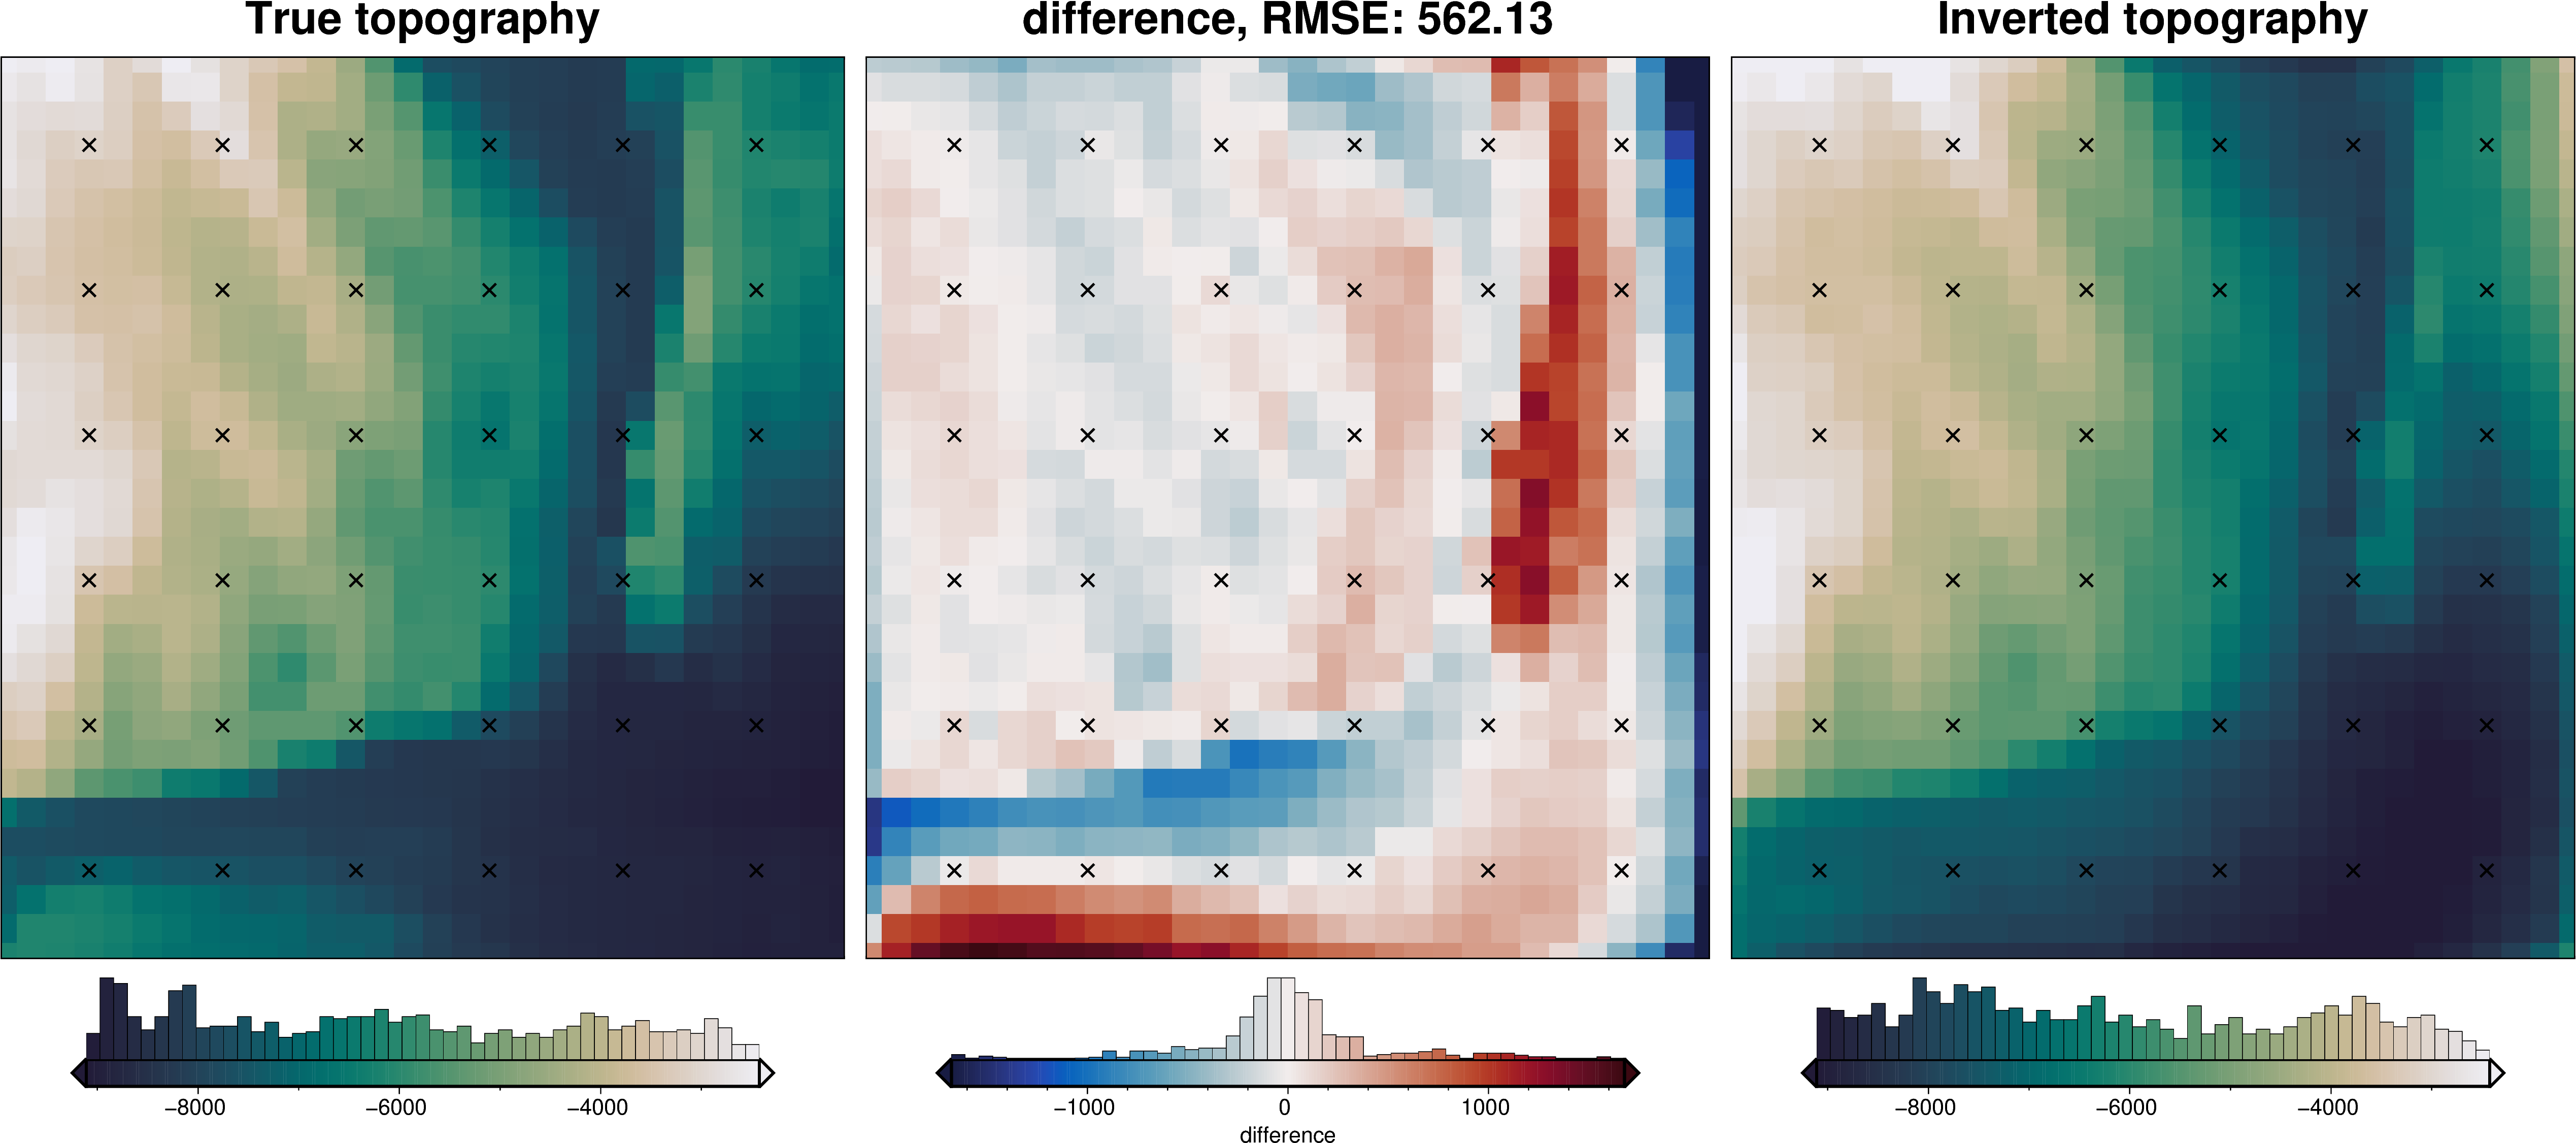

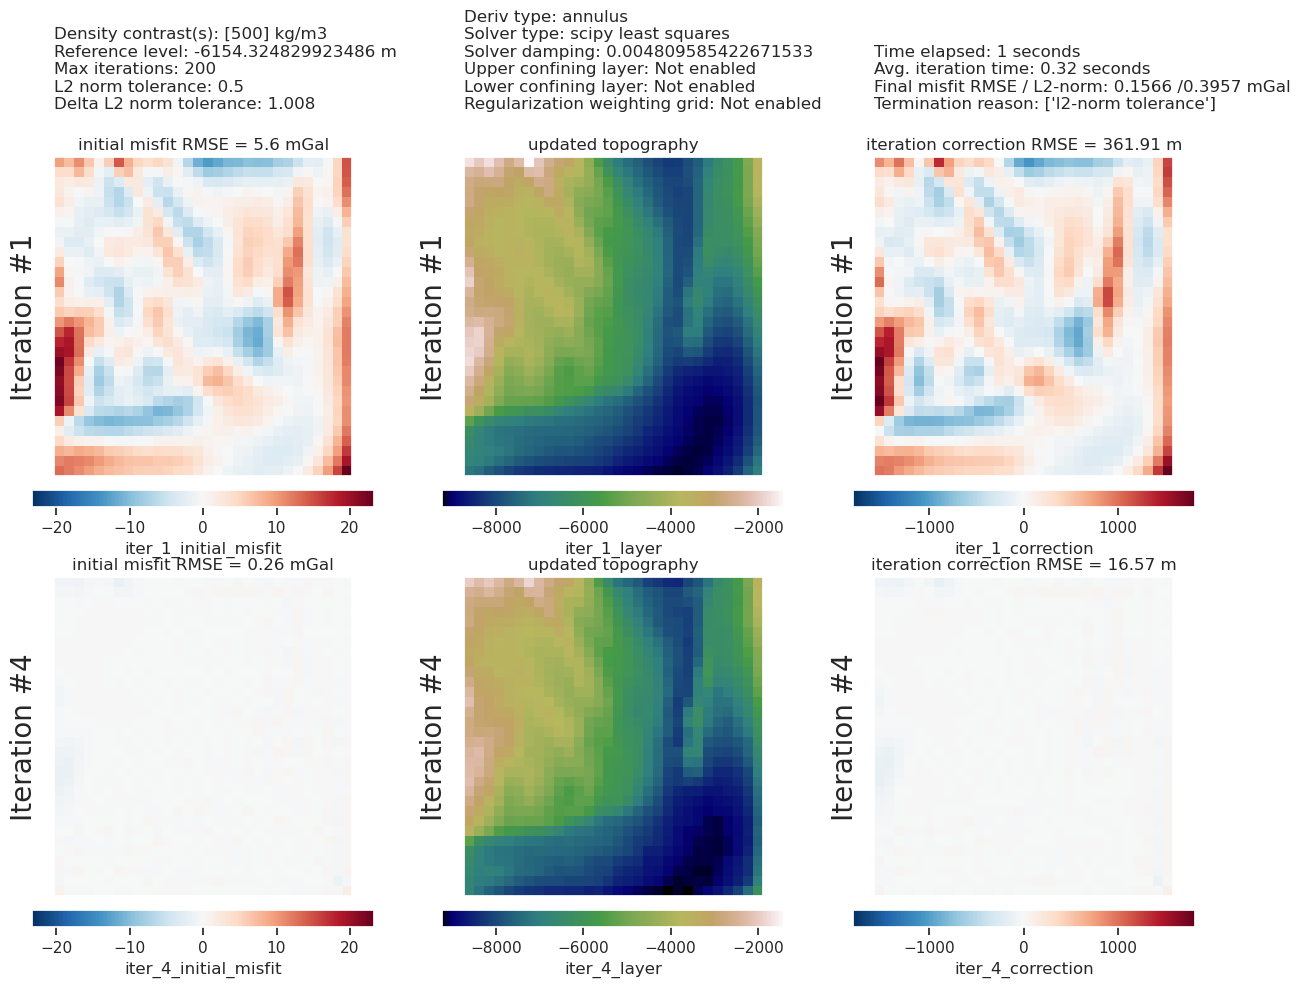

In [21]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

plotting.plot_convergence(
    grav_results,
    parameters,
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=False,
    plot_grav_results=False,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    grid.basement_topo,
    final_topography,
    plot=True,
    region=inversion_region,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

In [22]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
)

rmse = utils.rmse(constraint_points.true_upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 153.12 m


## Density contrast / Zref cross validation
Since this cross validation uses the inversion error at constraint points, we can't use the constraint point minimization technique to estimate the regional field since that inherently sets the inversion error at constraints to zero, invalidating the cross validation scores. 

There are two options for how to get around this issue:
1) use a different regional estimation technique while finding the optimal density contrast value, then use the found optimal values with the constraint point minimization regional estimation technique afterwards. 
2) separate the constraints into testing and training sets, so that only the training set is used during the regional separation, and only the testing set is used for scoring the density contrast cross validation. 

Well just use the 1st option below.

### Use alternative regional estimation method

We will use the equivalent sources technique to estimate the regional field, and then perform a cross-validation for the density contrast and reference level values. During this CV, we will use the optimal damping parameter value found above. Once we have found the optimal zref and density contrast values, we will need to use then in a separate inversion which had the regional field estimated with the better constraint point minimization technique.

### Density CV

INFO:invert4geom:using 4 startup trials


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 8
INFO:invert4geom:	parameter: {'density_contrast': 281}
INFO:invert4geom:	scores: [1779.7746125465253]


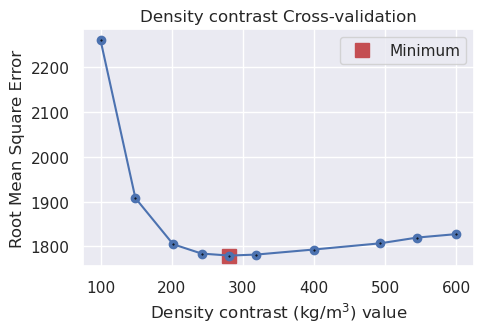

In [23]:
# run the cross validation for density
study, inversion_results = optimization.optimize_inversion_zref_density_contrast(
    grav_df=grav_df,
    constraints_df=constraint_points,
    density_contrast_limits=(100, 600),
    zref=constraint_points.upward.mean(),
    n_trials=10,
    # grid_search=True,
    starting_topography=starting_topography,
    regional_grav_kwargs=dict(
        method="constant",
        # constraints_df=constraint_points,
        constant=grav_df.reg.mean(),
    ),
    # grid_search=True,
    fname="../tmp/bishop_model_density_cv",
    # score_as_median=True,
    **kwargs,
)

In [24]:
# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/bishop_model_density_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

In [25]:
best_density_contrast = study.best_params.get("density_contrast", None)
best_density_contrast

281

### Zref CV

INFO:invert4geom:using 4 startup trials


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 6
INFO:invert4geom:	parameter: {'zref': -6290.718052642159}
INFO:invert4geom:	scores: [1773.8141791675089]


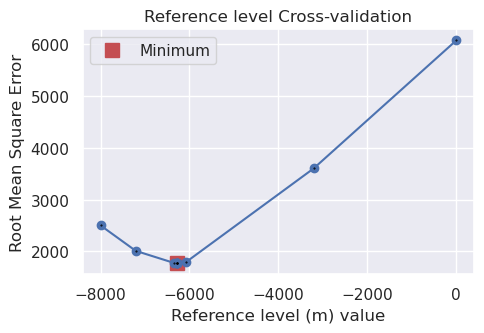

In [26]:
# run the cross validation for the zref
study, inversion_results = optimization.optimize_inversion_zref_density_contrast(
    grav_df=grav_df,
    constraints_df=constraint_points,
    zref_limits=(-8e3, 0),
    density_contrast=best_density_contrast,
    n_trials=10,
    # grid_search=True,
    starting_topography=starting_topography,
    regional_grav_kwargs=dict(
        method="constant",
        constant=grav_df.reg.mean(),
        # constraints_df=constraint_points,
    ),
    fname="../tmp/bishop_model_zref_cv",
    # score_as_median=True,
    **kwargs,
)

In [27]:
# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/bishop_model_zref_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

In [28]:
best_zref = study.best_params.get("zref", None)
best_zref

-6290.718052642159

### Redo with optimal parameters

In [29]:
zref = best_zref
density_contrast = best_density_contrast

density_grid = xr.where(
    starting_topography >= zref,
    density_contrast,
    -density_contrast,
)
# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)
grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df = regional.regional_separation(
    grav_df=grav_df,
    **regional_grav_kwargs,
)

  0%|          | 0/960 [00:00<?, ?it/s]

INFO:invert4geom:using 12 startup trials
INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 9
INFO:invert4geom:	parameter: {'depth': 974124.3677063867, 'damping': 0.0032431101190705755}
INFO:invert4geom:	scores: [0.9742325906391865]


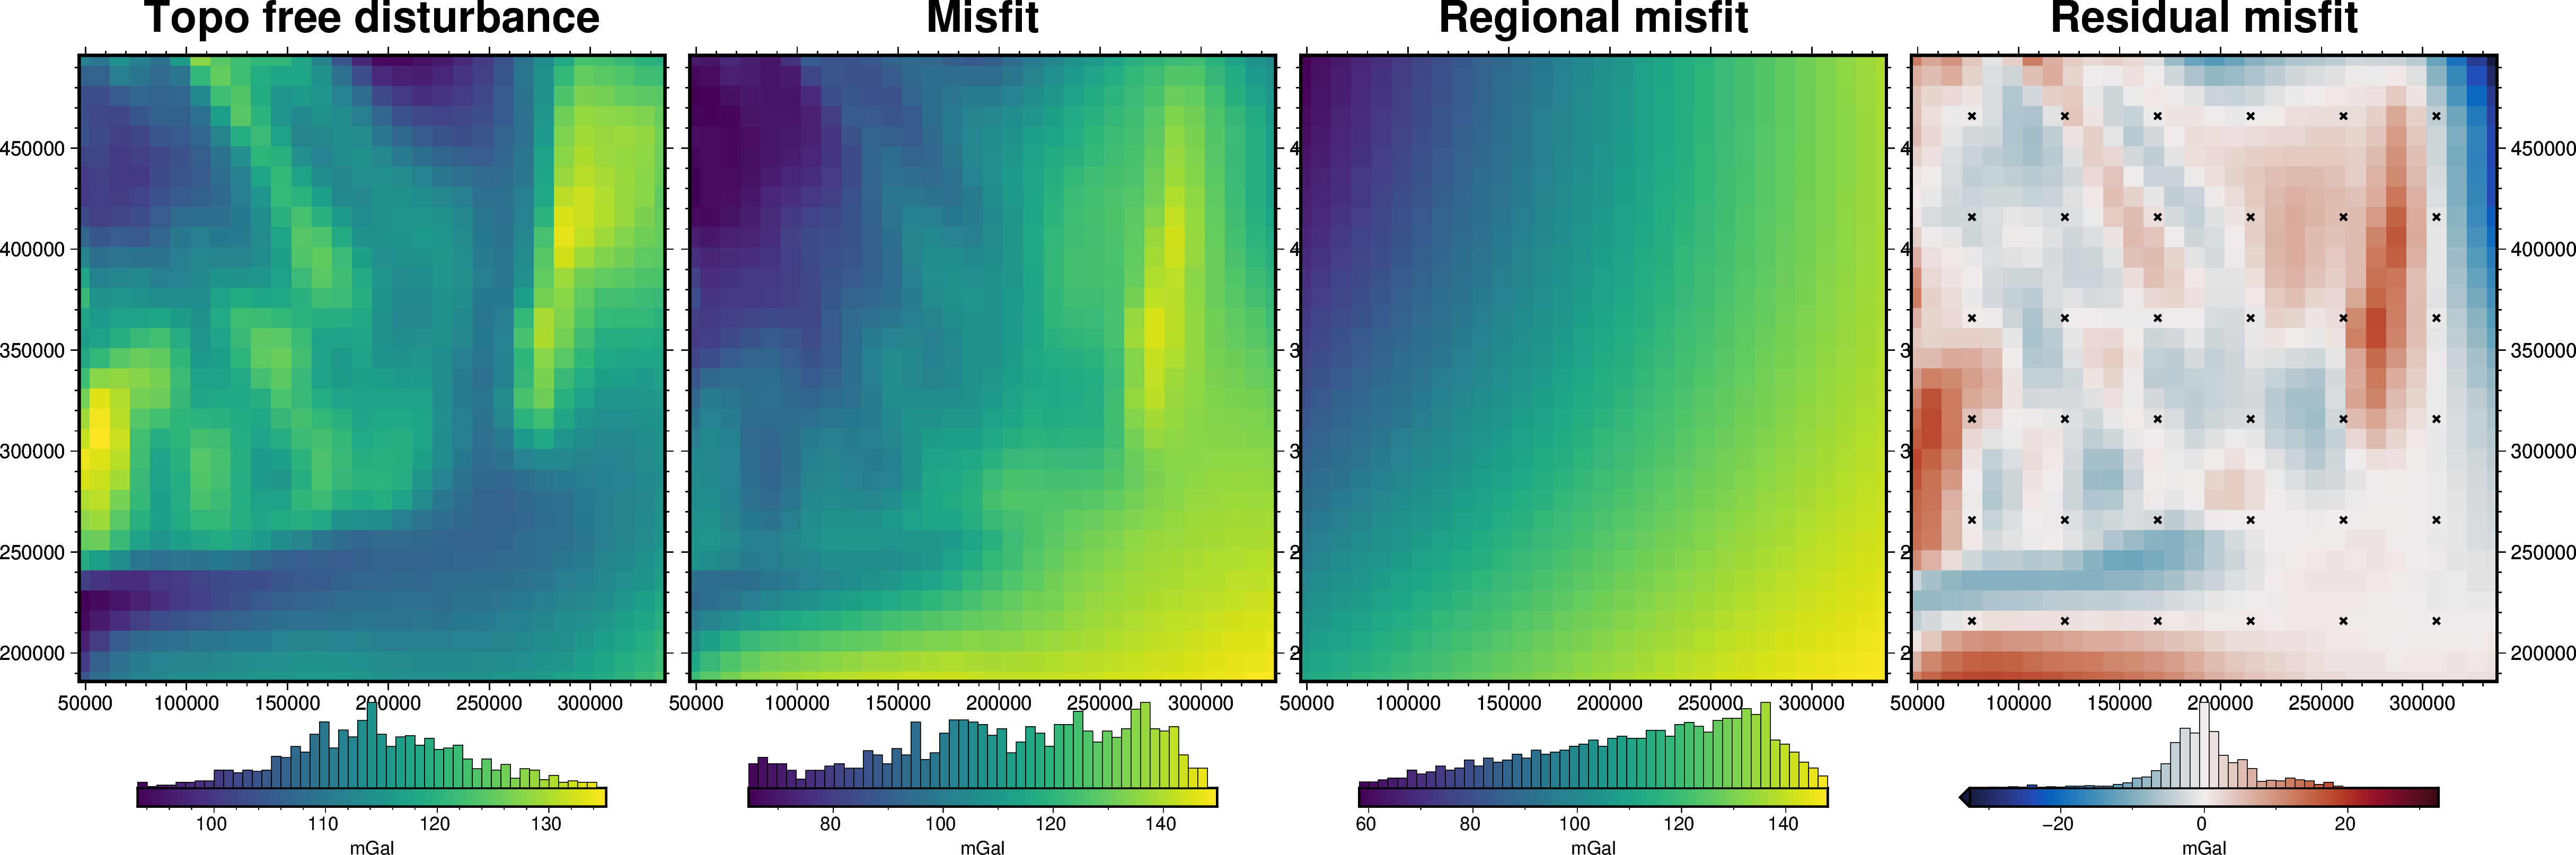

In [30]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    region=inversion_region,
    fig_height=10,
    title="Topo free disturbance",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    region=inversion_region,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Misfit",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    region=inversion_region,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Regional misfit",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    region=inversion_region,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_grid.res), vd.maxabs(grav_grid.res)],
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraint_points,
    points_style="x.15c",
)
fig.show()

In [31]:
# re-load the study from the saved pickle file
with pathlib.Path(f"{regional_grav_kwargs.get('cv_kwargs').get('fname')}.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)
reg_eq_damping = min(study.best_trials, key=lambda t: t.values[0]).params["damping"]
reg_eq_depth = min(study.best_trials, key=lambda t: t.values[0]).params["depth"]

new_regional_grav_kwargs = dict(
    method="constraints",
    grid_method="eq_sources",
    constraints_df=constraint_points,
    damping=reg_eq_damping,
    depth=reg_eq_depth,
    block_size=None,
)

reg_eq_damping, reg_eq_depth

(0.0032431101190705755, 974124.3677063867)

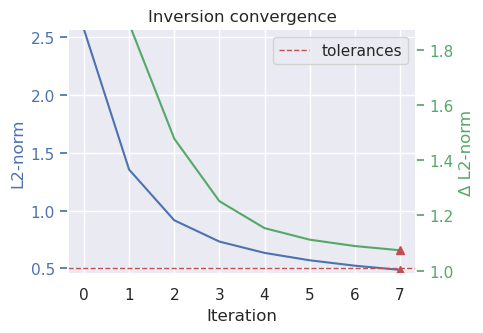

In [32]:
# run the inversion workflow
inversion_results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    fname="../tmp/bishop_model",
    starting_prisms=starting_prisms,
    plot_dynamic_convergence=True,
    **kwargs,
)

In [33]:
# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/bishop_model_results.pickle").open("rb") as f:
    inversion_results = pickle.load(f)

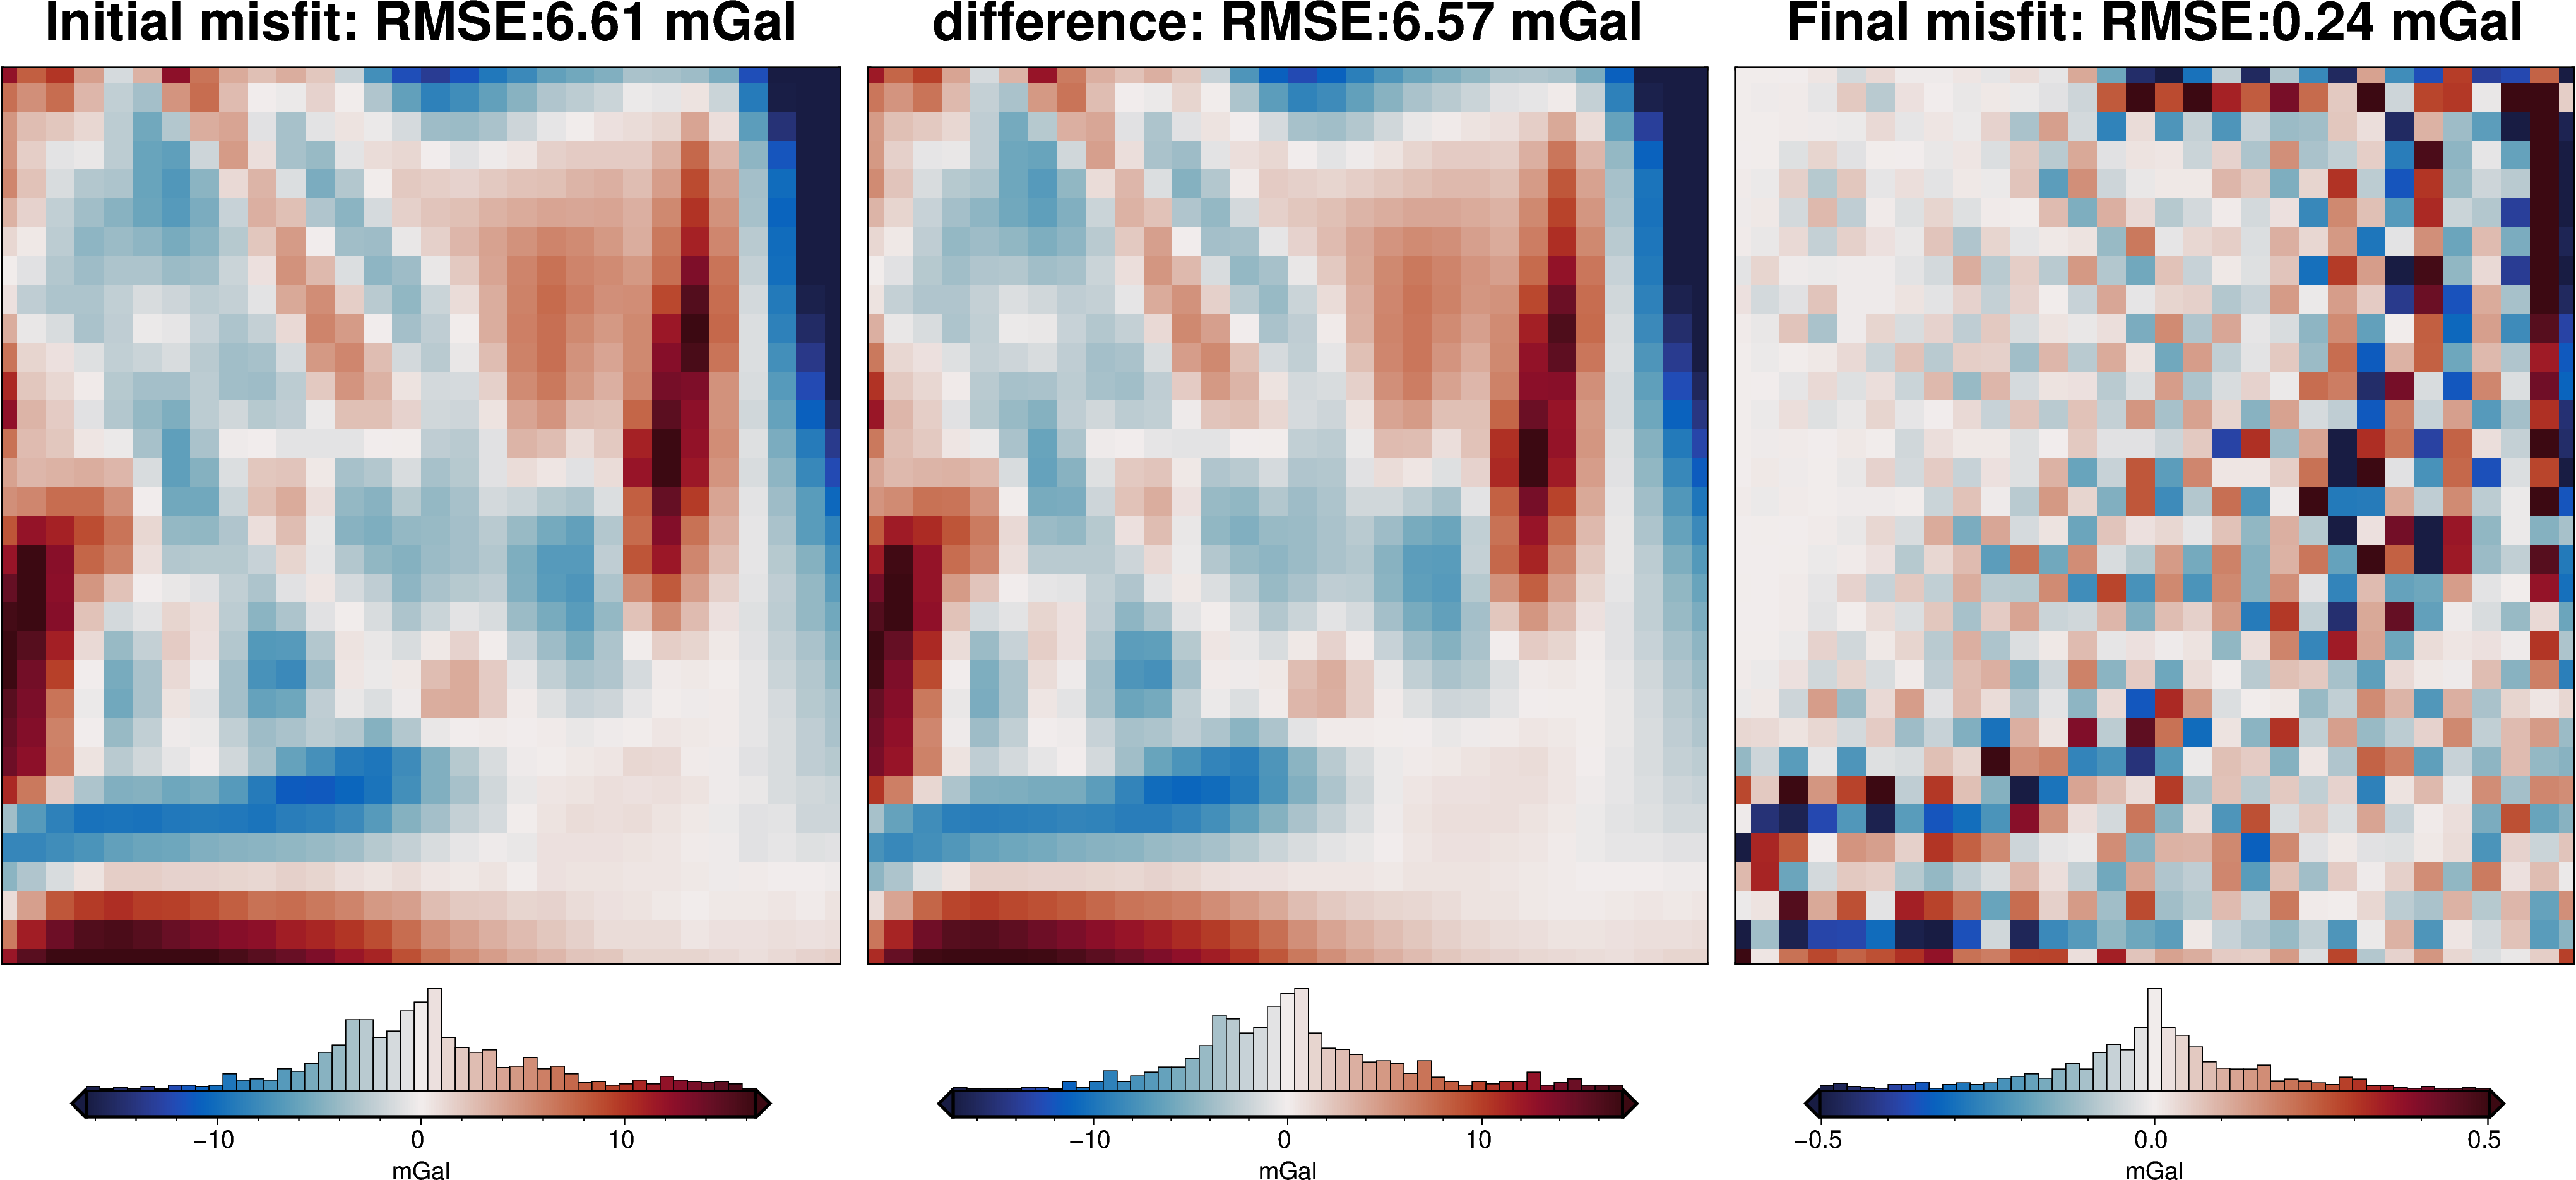

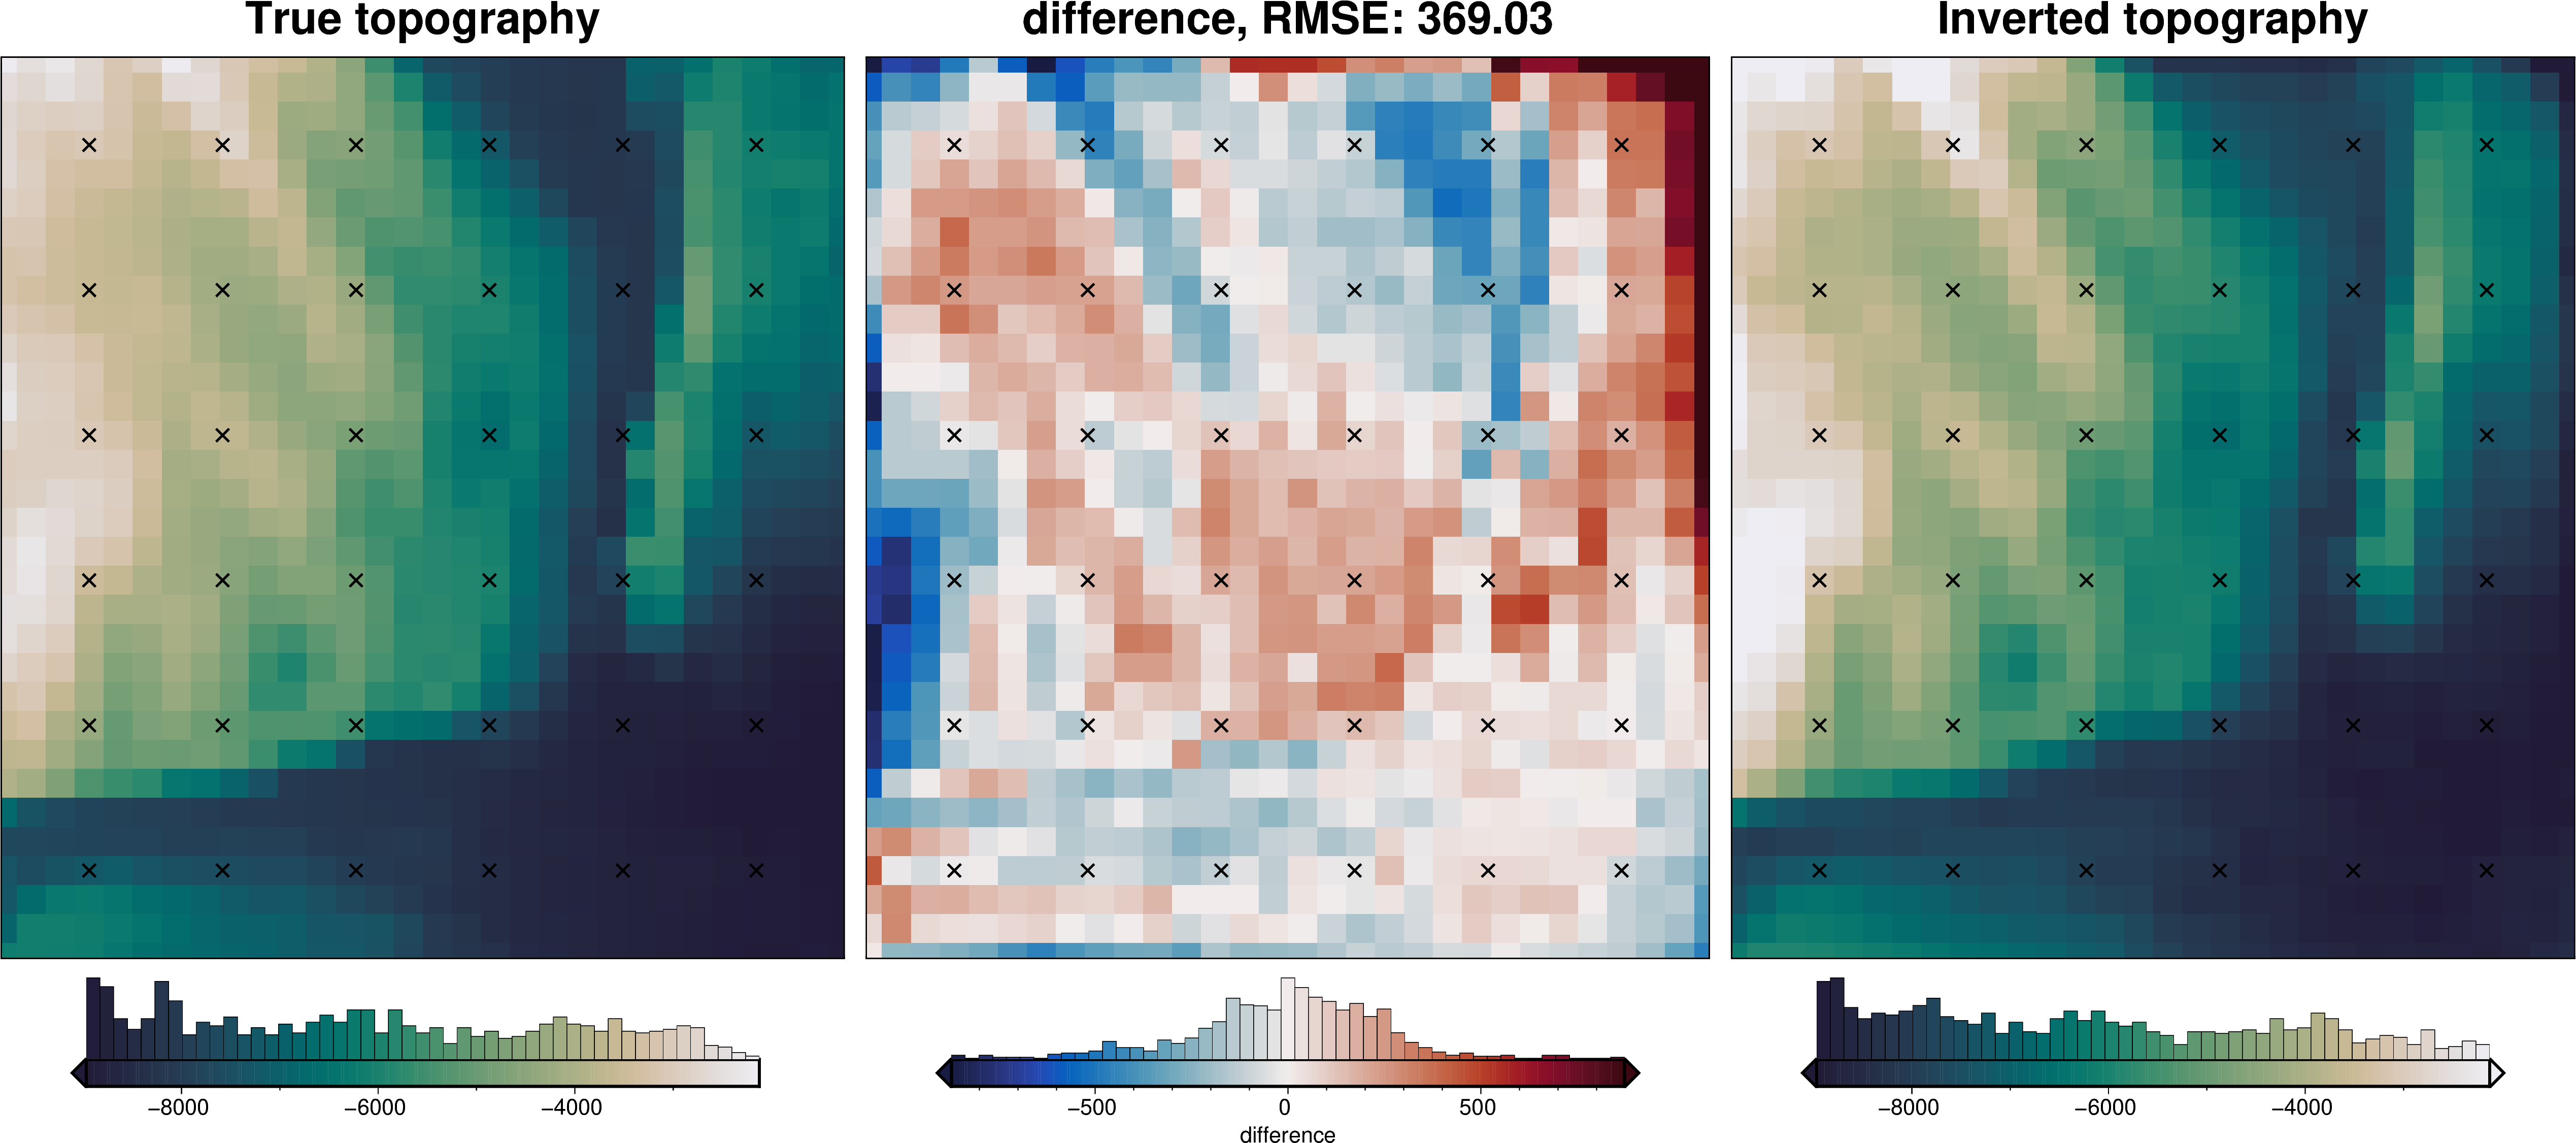

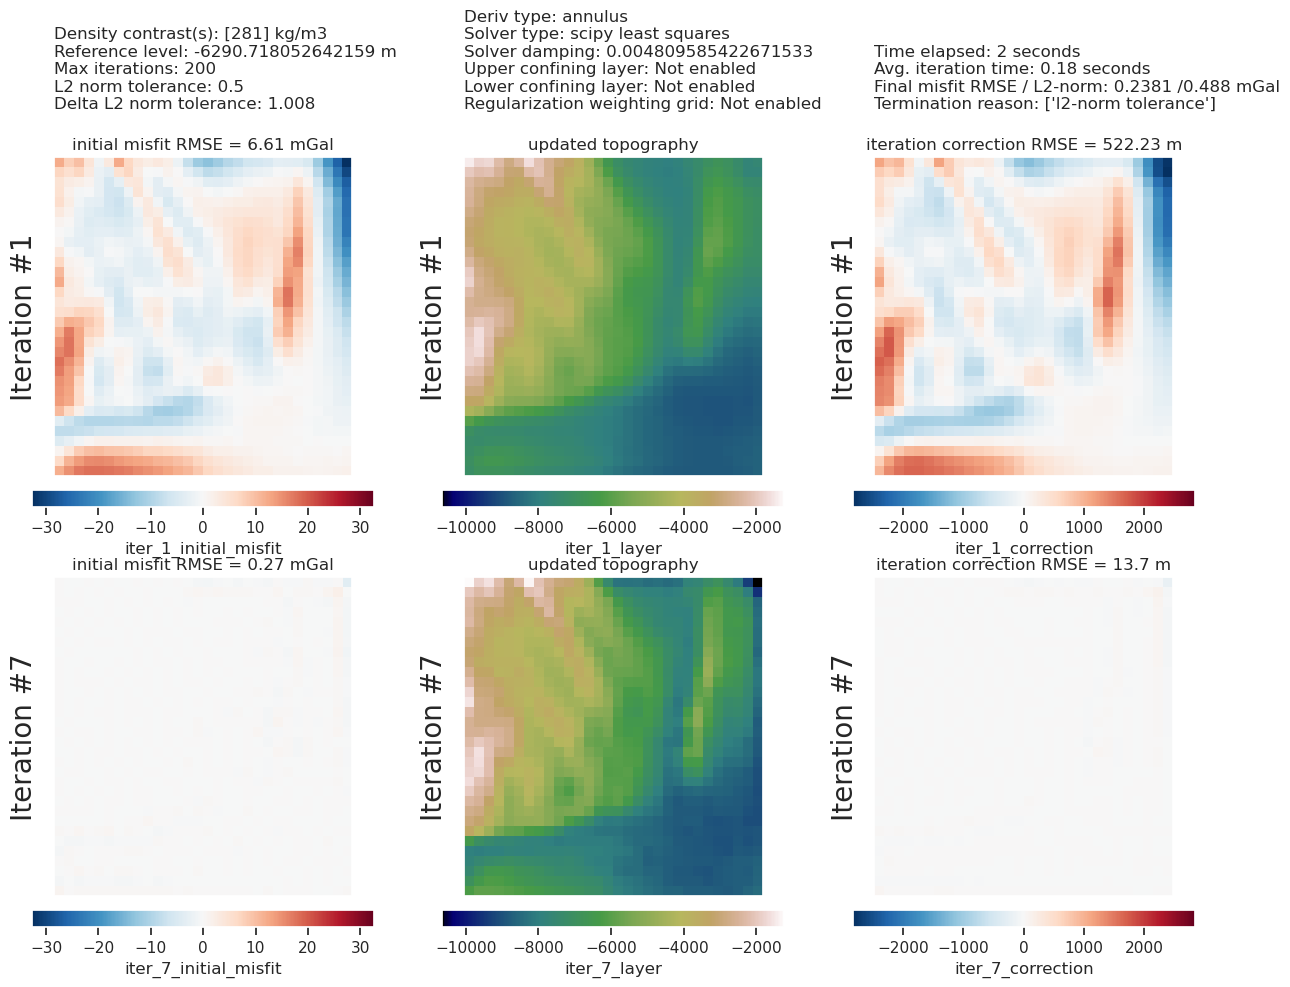

In [34]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=False,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    grid.basement_topo,
    final_topography,
    plot=True,
    region=inversion_region,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

In [35]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
)

rmse = utils.rmse(constraint_points.true_upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 167.17 m


## Uncertainty analysis


### Absolute value of inversion error

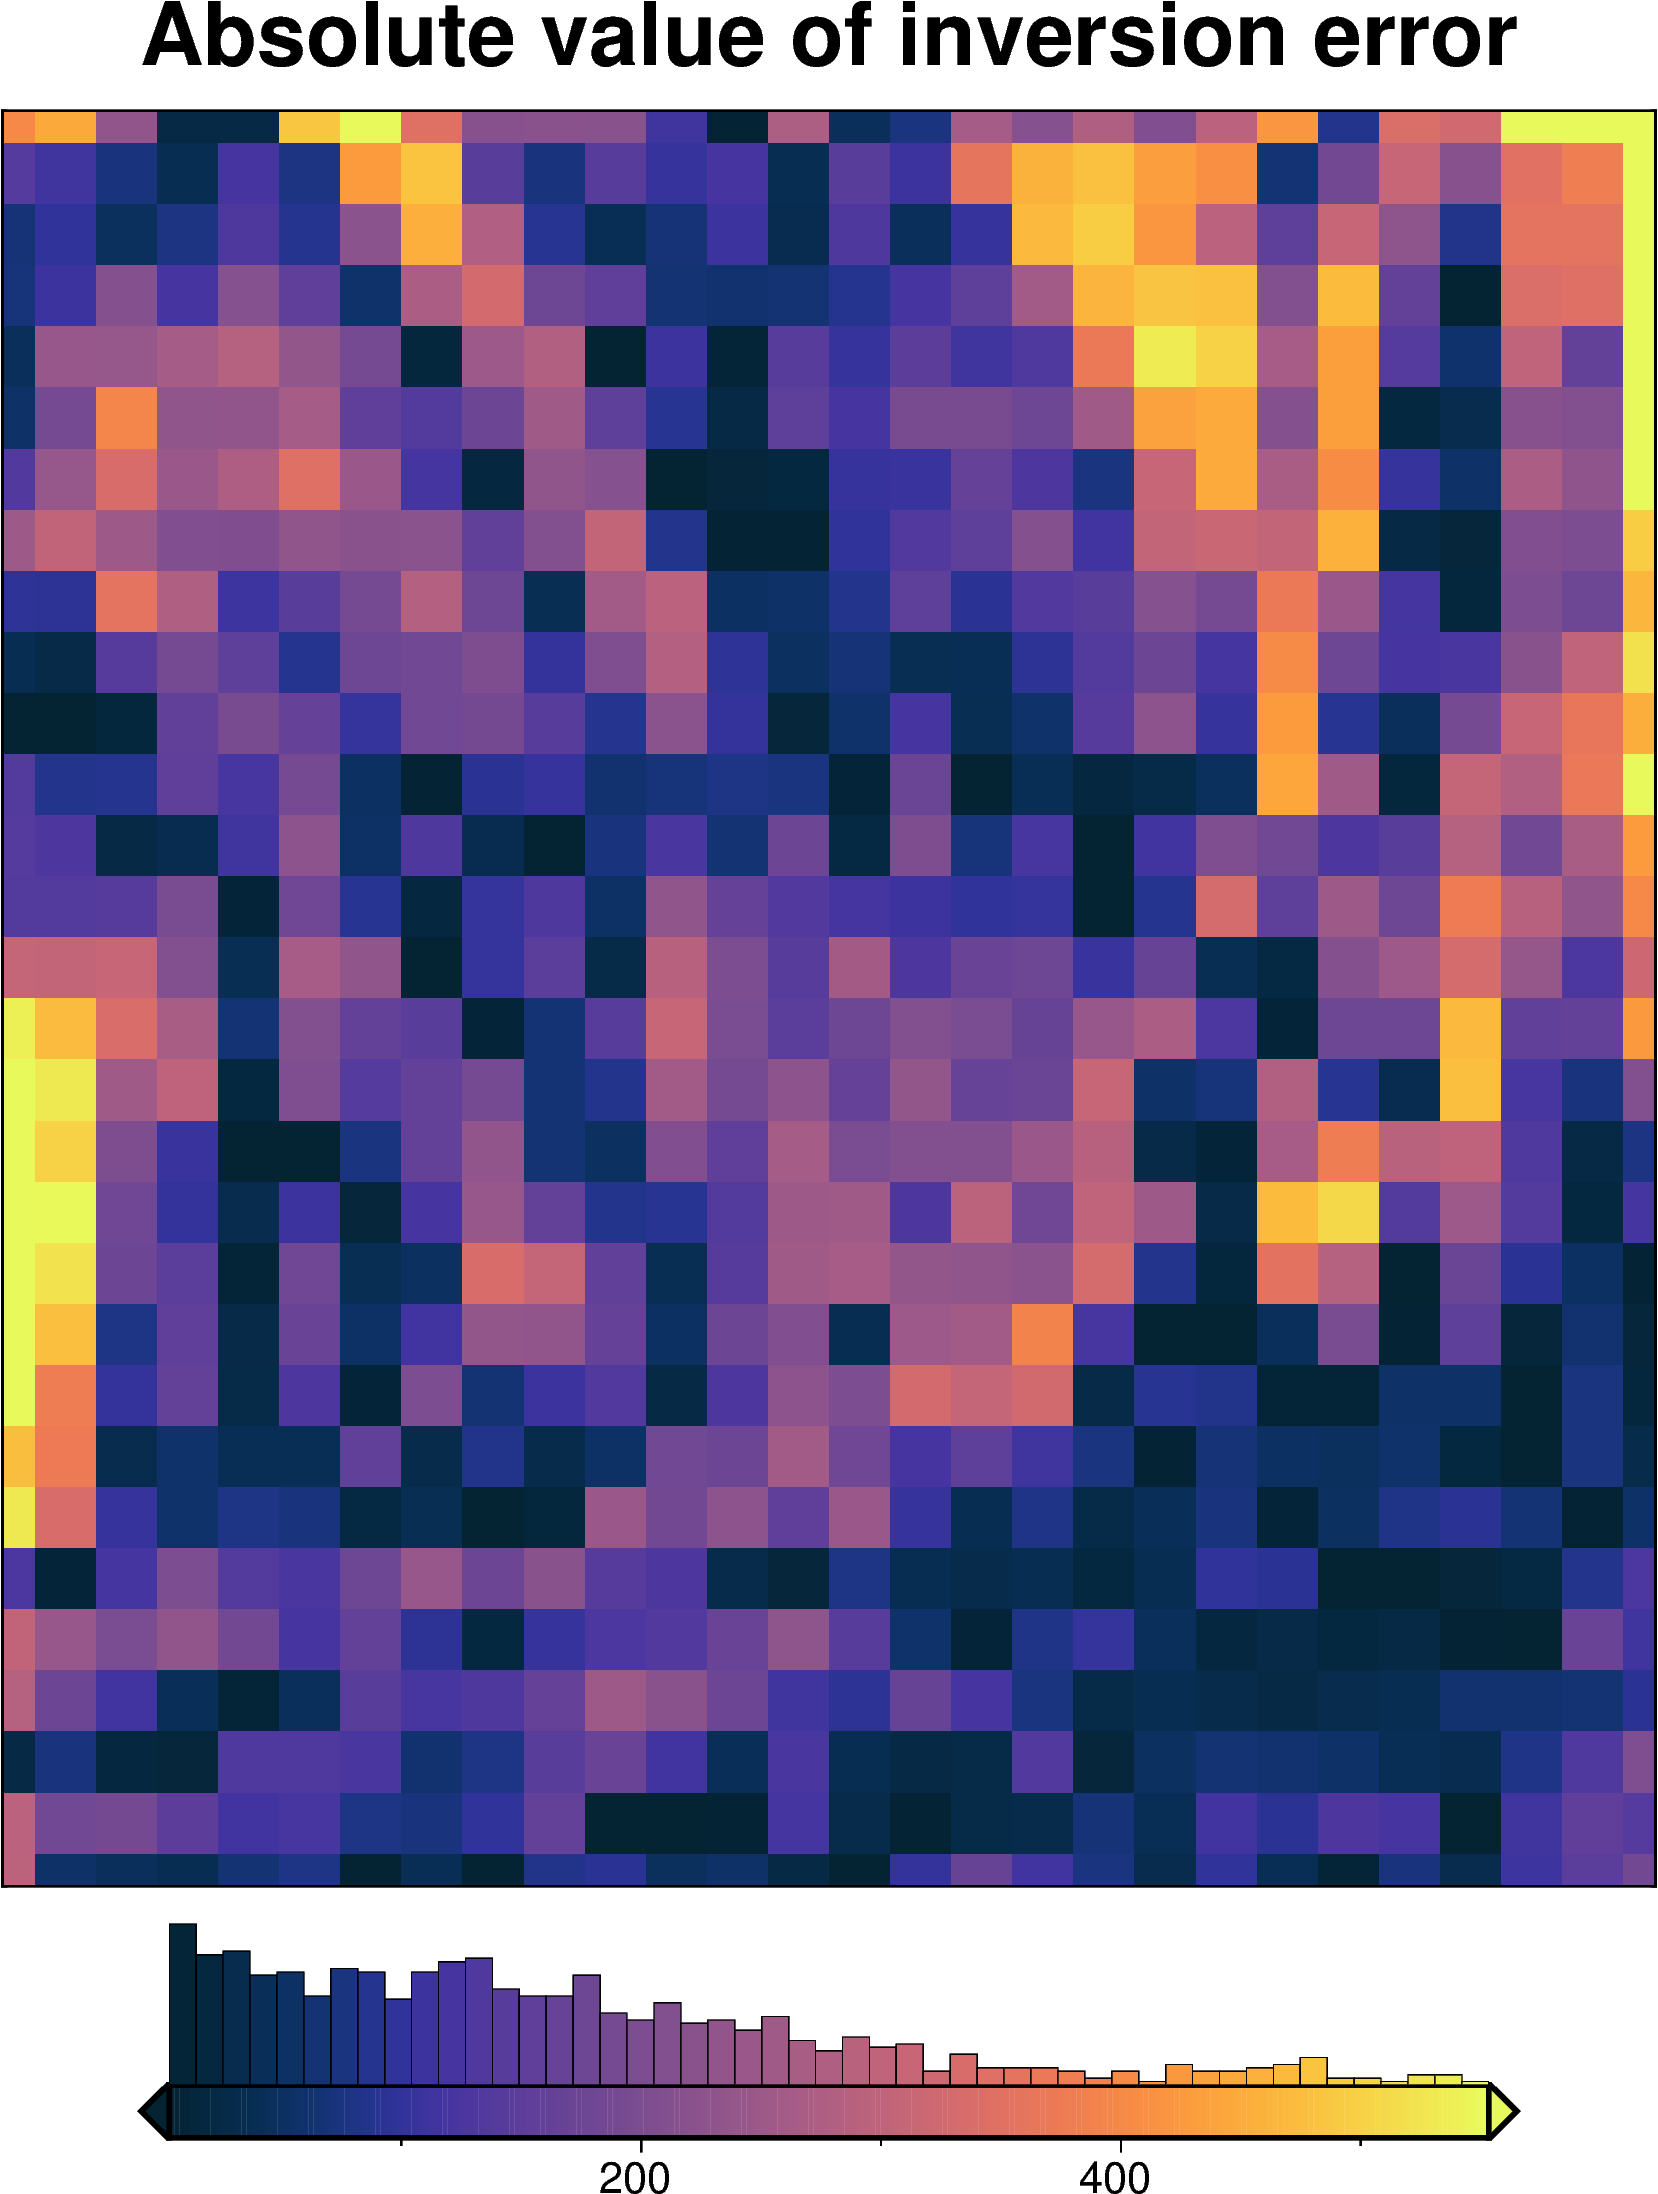

In [36]:
inversion_error = np.abs(grid.basement_topo - final_topography)

inner_region = vd.pad_region(inversion_region, -topo_spacing)

fig = maps.plot_grd(
    inversion_error.sel(
        {
            "easting": slice(*inner_region[:2]),
            "northing": slice(*inner_region[2:]),
        }
    ),
    hist=True,
    cmap="thermal",
    title="Absolute value of inversion error",
    robust=True,
)
fig.show()

### Regional field estimation uncertainty

We will do the same thing for the regional estimation procedure. First we will re-separate the regional to see what equivalent source gridding parameter values were determined optimal. We then estimate an uncertainty distribution for these parameter values, and create an ensemble of regional models which each randomly sample both the parameter values and the gravity data. 

INFO:invert4geom:Sampled 'depth' parameter values; mean: 974124.3677063871, min: -3392685.6619006884, max: 5340934.397313465
INFO:invert4geom:Sampled 'damping' parameter values; mean: 0.06968051942416478, min: 0.0034352764747856658, max: 0.30616933809015123


starting regional ensemble:   0%|          | 0/40 [00:00<?, ?it/s]

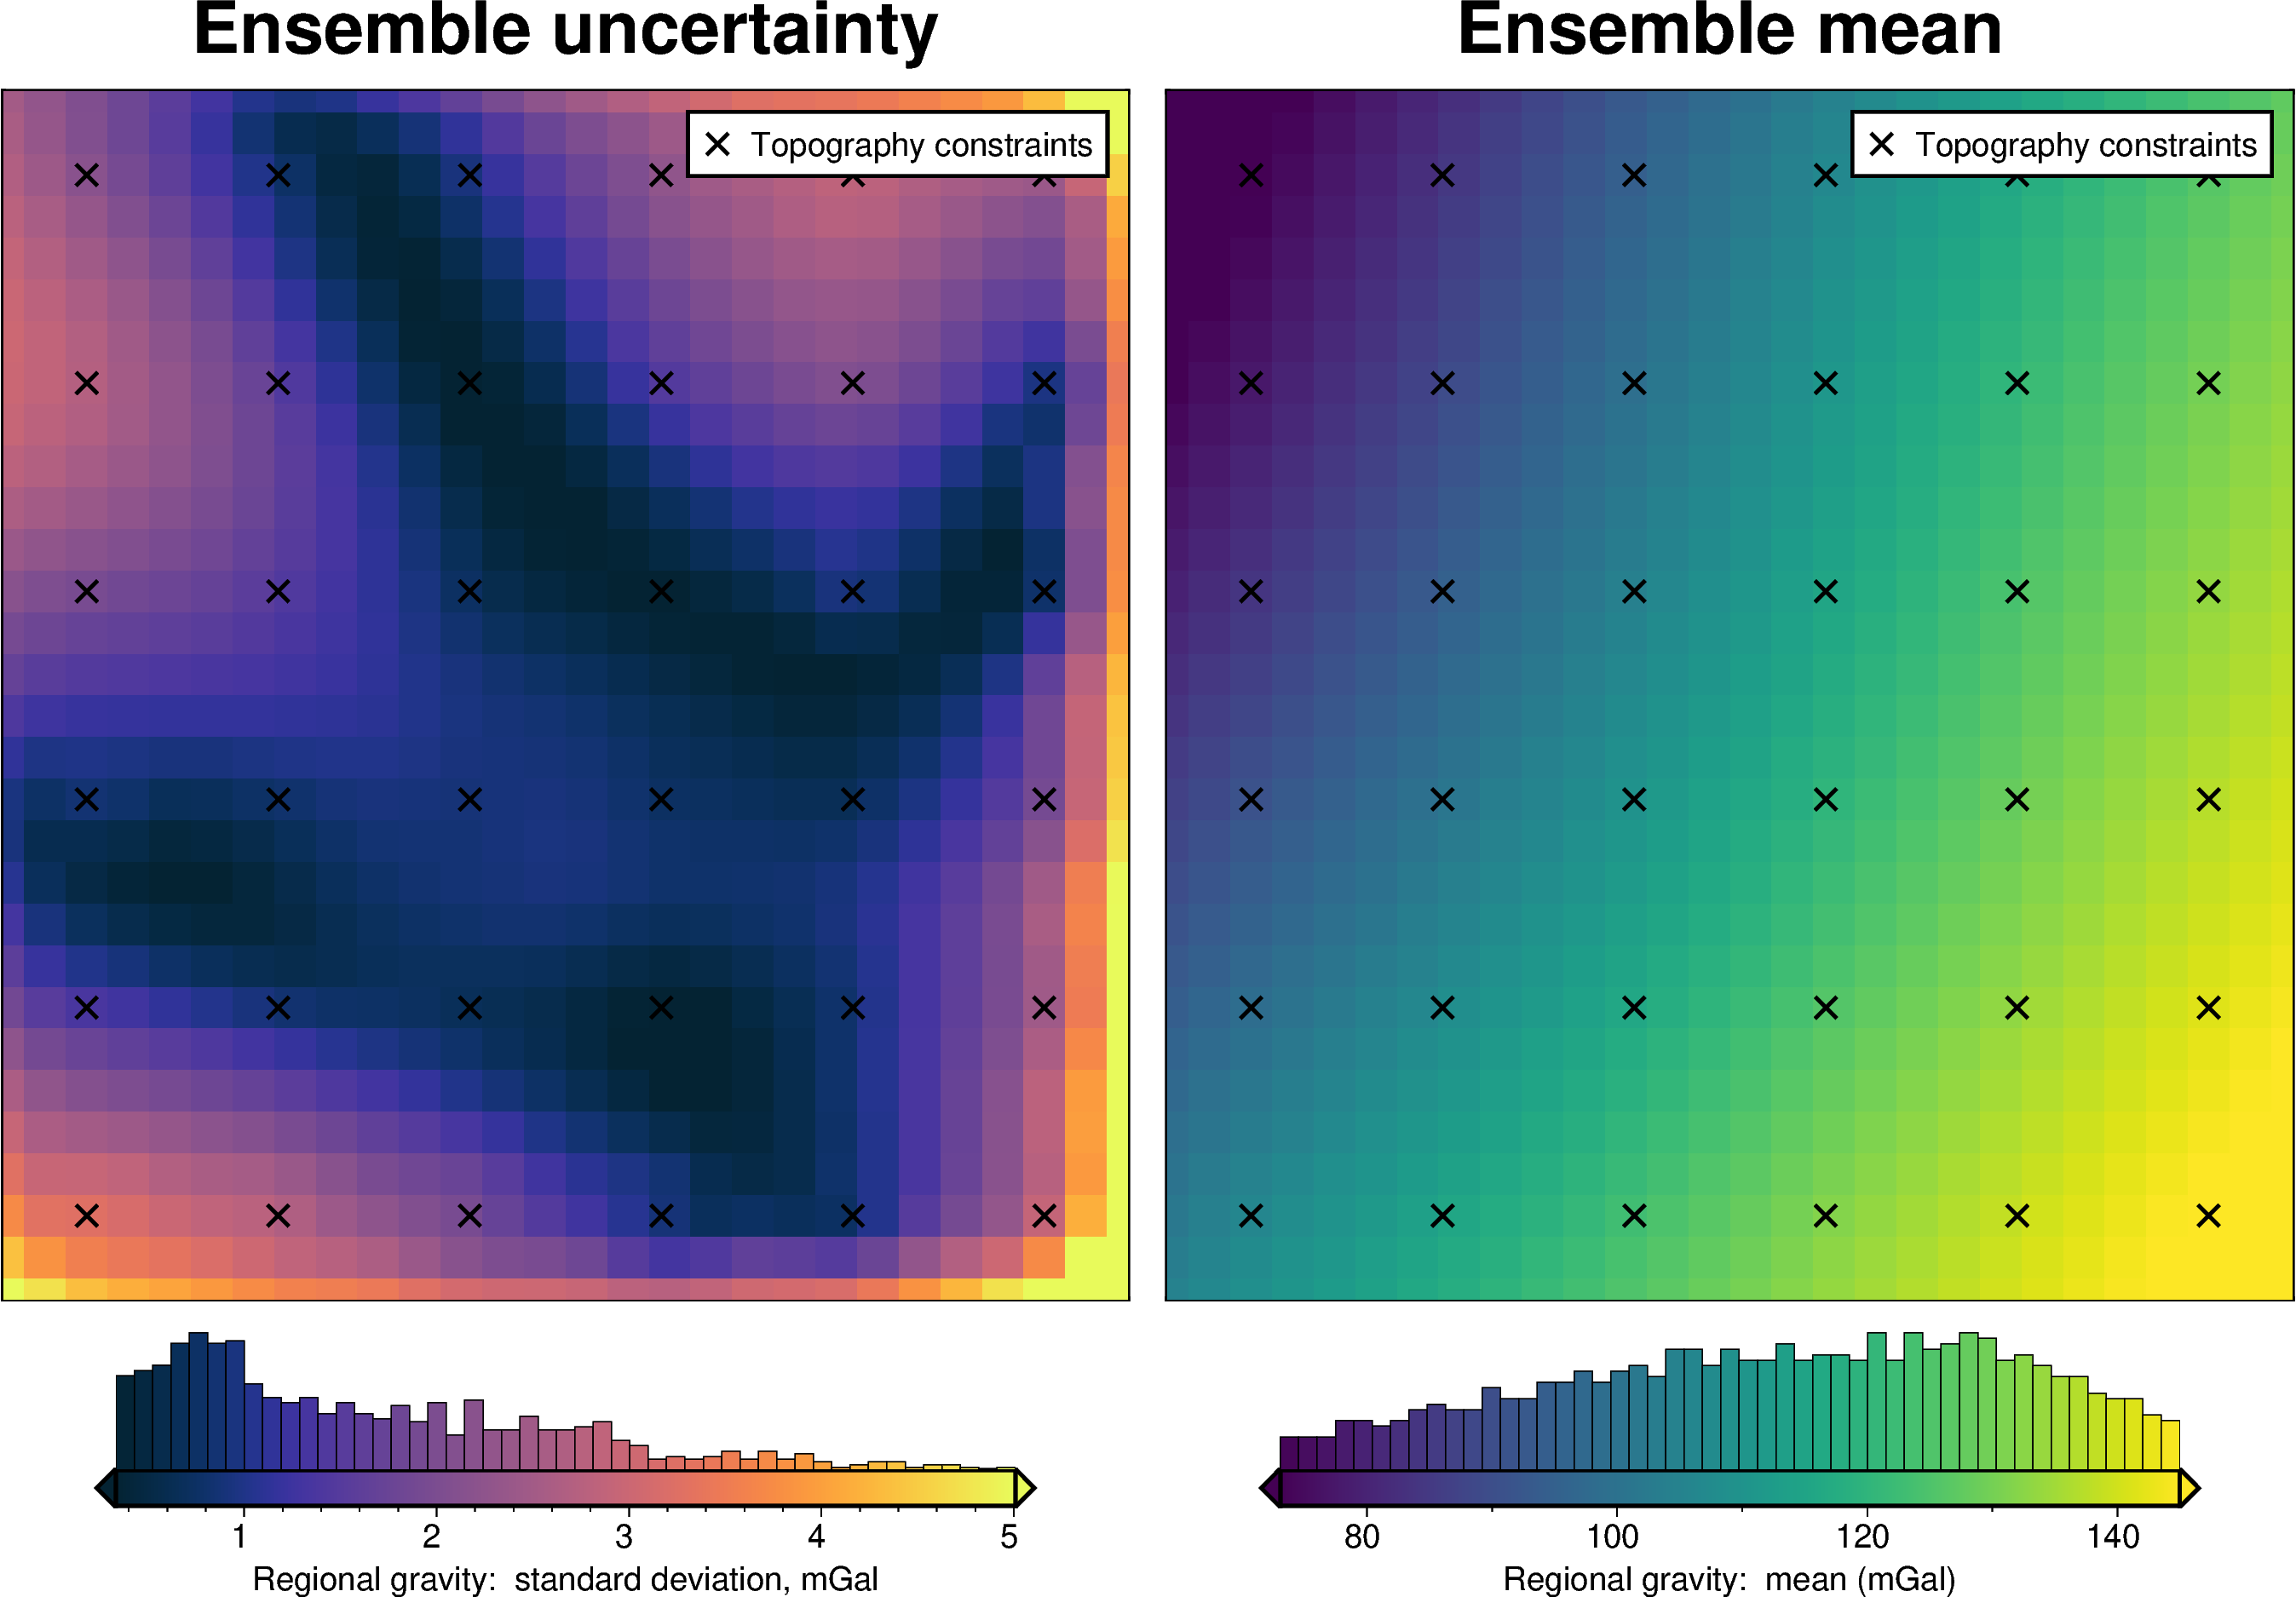

In [37]:
regional_misfit_parameter_dict = {
    # "depth": {
    #     "distribution": "uniform",
    #     "loc": 2 * mean_constraint_distance,  # lower bound
    #     "scale": 5 * mean_constraint_distance,  # range, 2+5=7
    # },
    "depth": {
        "distribution": "normal",
        "loc": reg_eq_depth,  # mean base 10 exponent
        "scale": 2 * reg_eq_depth,  # standard deviation of exponent
    },
    "damping": {
        "distribution": "uniform",
        "loc": np.log10(reg_eq_damping),
        "scale": 2,
        "log": True,
    },
}

# regional_kwargs = dict(
#     grav_df=grav_df,
#     constraints_df=constraint_points,
#     method="constraints",
#     grid_method="eq_sources",
#     # damping=reg_eq_damping,
#     # depth=reg_eq_depth,
#     block_size=None,
# )

regional_misfit_stats, _ = uncertainty.regional_misfit_uncertainty(
    runs=40,
    parameter_dict=regional_misfit_parameter_dict,
    plot_region=inner_region,
    grav_df=grav_df,
    **new_regional_grav_kwargs,
)

## Sensitivity Analysis

Above we perform an uncertainty assessment using all the important parameters and data. Now, we can repeat this stochastic analysis isolated the uncertainty arising from each component. This should give us a sense of which parameters/data are the most important.

In [38]:
# plotting functions for uncertainty results
def uncert_plots(results):
    ds = uncertainty.merged_stats(
        results=results,
        plot=True,
        constraints_df=constraint_points,
        weight_by="constraints",
        region=inversion_region,
    )

    _ = polar_utils.grd_compare(
        grid.basement_topo,
        ds.weighted_mean,
        region=inner_region,
        plot=True,
        grid1_name="True topography",
        grid2_name="Inverted topography",
        robust=True,
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        reverse_cpt=True,
        cmap="rain",
        points=constraint_points,
        points_style="x.3c",
    )
    _ = polar_utils.grd_compare(
        inversion_error,
        ds.weighted_stdev,
        region=inner_region,
        plot=True,
        grid1_name="True error",
        grid2_name="Stochastic uncertainty",
        robust=True,
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        points=constraint_points,
        points_style="x.3c",
    )

In [39]:
# best_spline_damping = starting_topography.attrs["damping"]

In [40]:
# parameters used in final inversion
best_density_contrast, best_zref, best_damping  # , best_spline_damping

(281, -6290.718052642159, 0.004809585422671533)

In [41]:
# kwargs to reuse for all uncertainty analyses
uncert_kwargs = dict(
    grav_df=grav_df,
    density_contrast=best_density_contrast,
    zref=best_zref,
    starting_prisms=starting_prisms,
    starting_topography=starting_topography,
    regional_grav_kwargs=new_regional_grav_kwargs,
    **kwargs,
)

### Density component

In [42]:
# load study
with pathlib.Path("../tmp/bishop_model_density_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

study_df = study.trials_dataframe()
study_df = study_df.sort_values("value")

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2 = study_df[(np.abs(study_df.value_zscore) < 2)]

stdev = study_df2.params_density_contrast.std()
print(f"calculated stdev: {stdev}")

# manually pick a stdev
# stdev = 20
print(f"using stdev: {stdev}")

calculated stdev: 159.07388220572227
using stdev: 159.07388220572227


best: 281 
std: 159.07388220572227 
+1std: 440.07388220572227 
-1std: 121.92611779427773


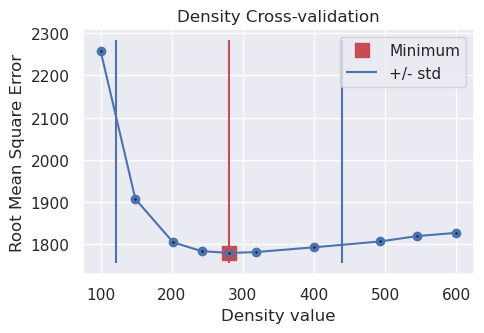

In [43]:
fig = plotting.plot_cv_scores(
    study.trials_dataframe().value.values,
    study.trials_dataframe().params_density_contrast.values,
    param_name="Density",
    logx=False,
    logy=False,
)
ax = fig.axes[0]

best = study_df2.params_density_contrast.iloc[0]
upper = best + stdev
lower = best - stdev

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 281.0, min: 19.346747900666344, max: 542.6532520993335
INFO:invert4geom:No pickle files starting with '../tmp/bishop_uncertainty_density' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../tmp/bishop_uncertainty_density'



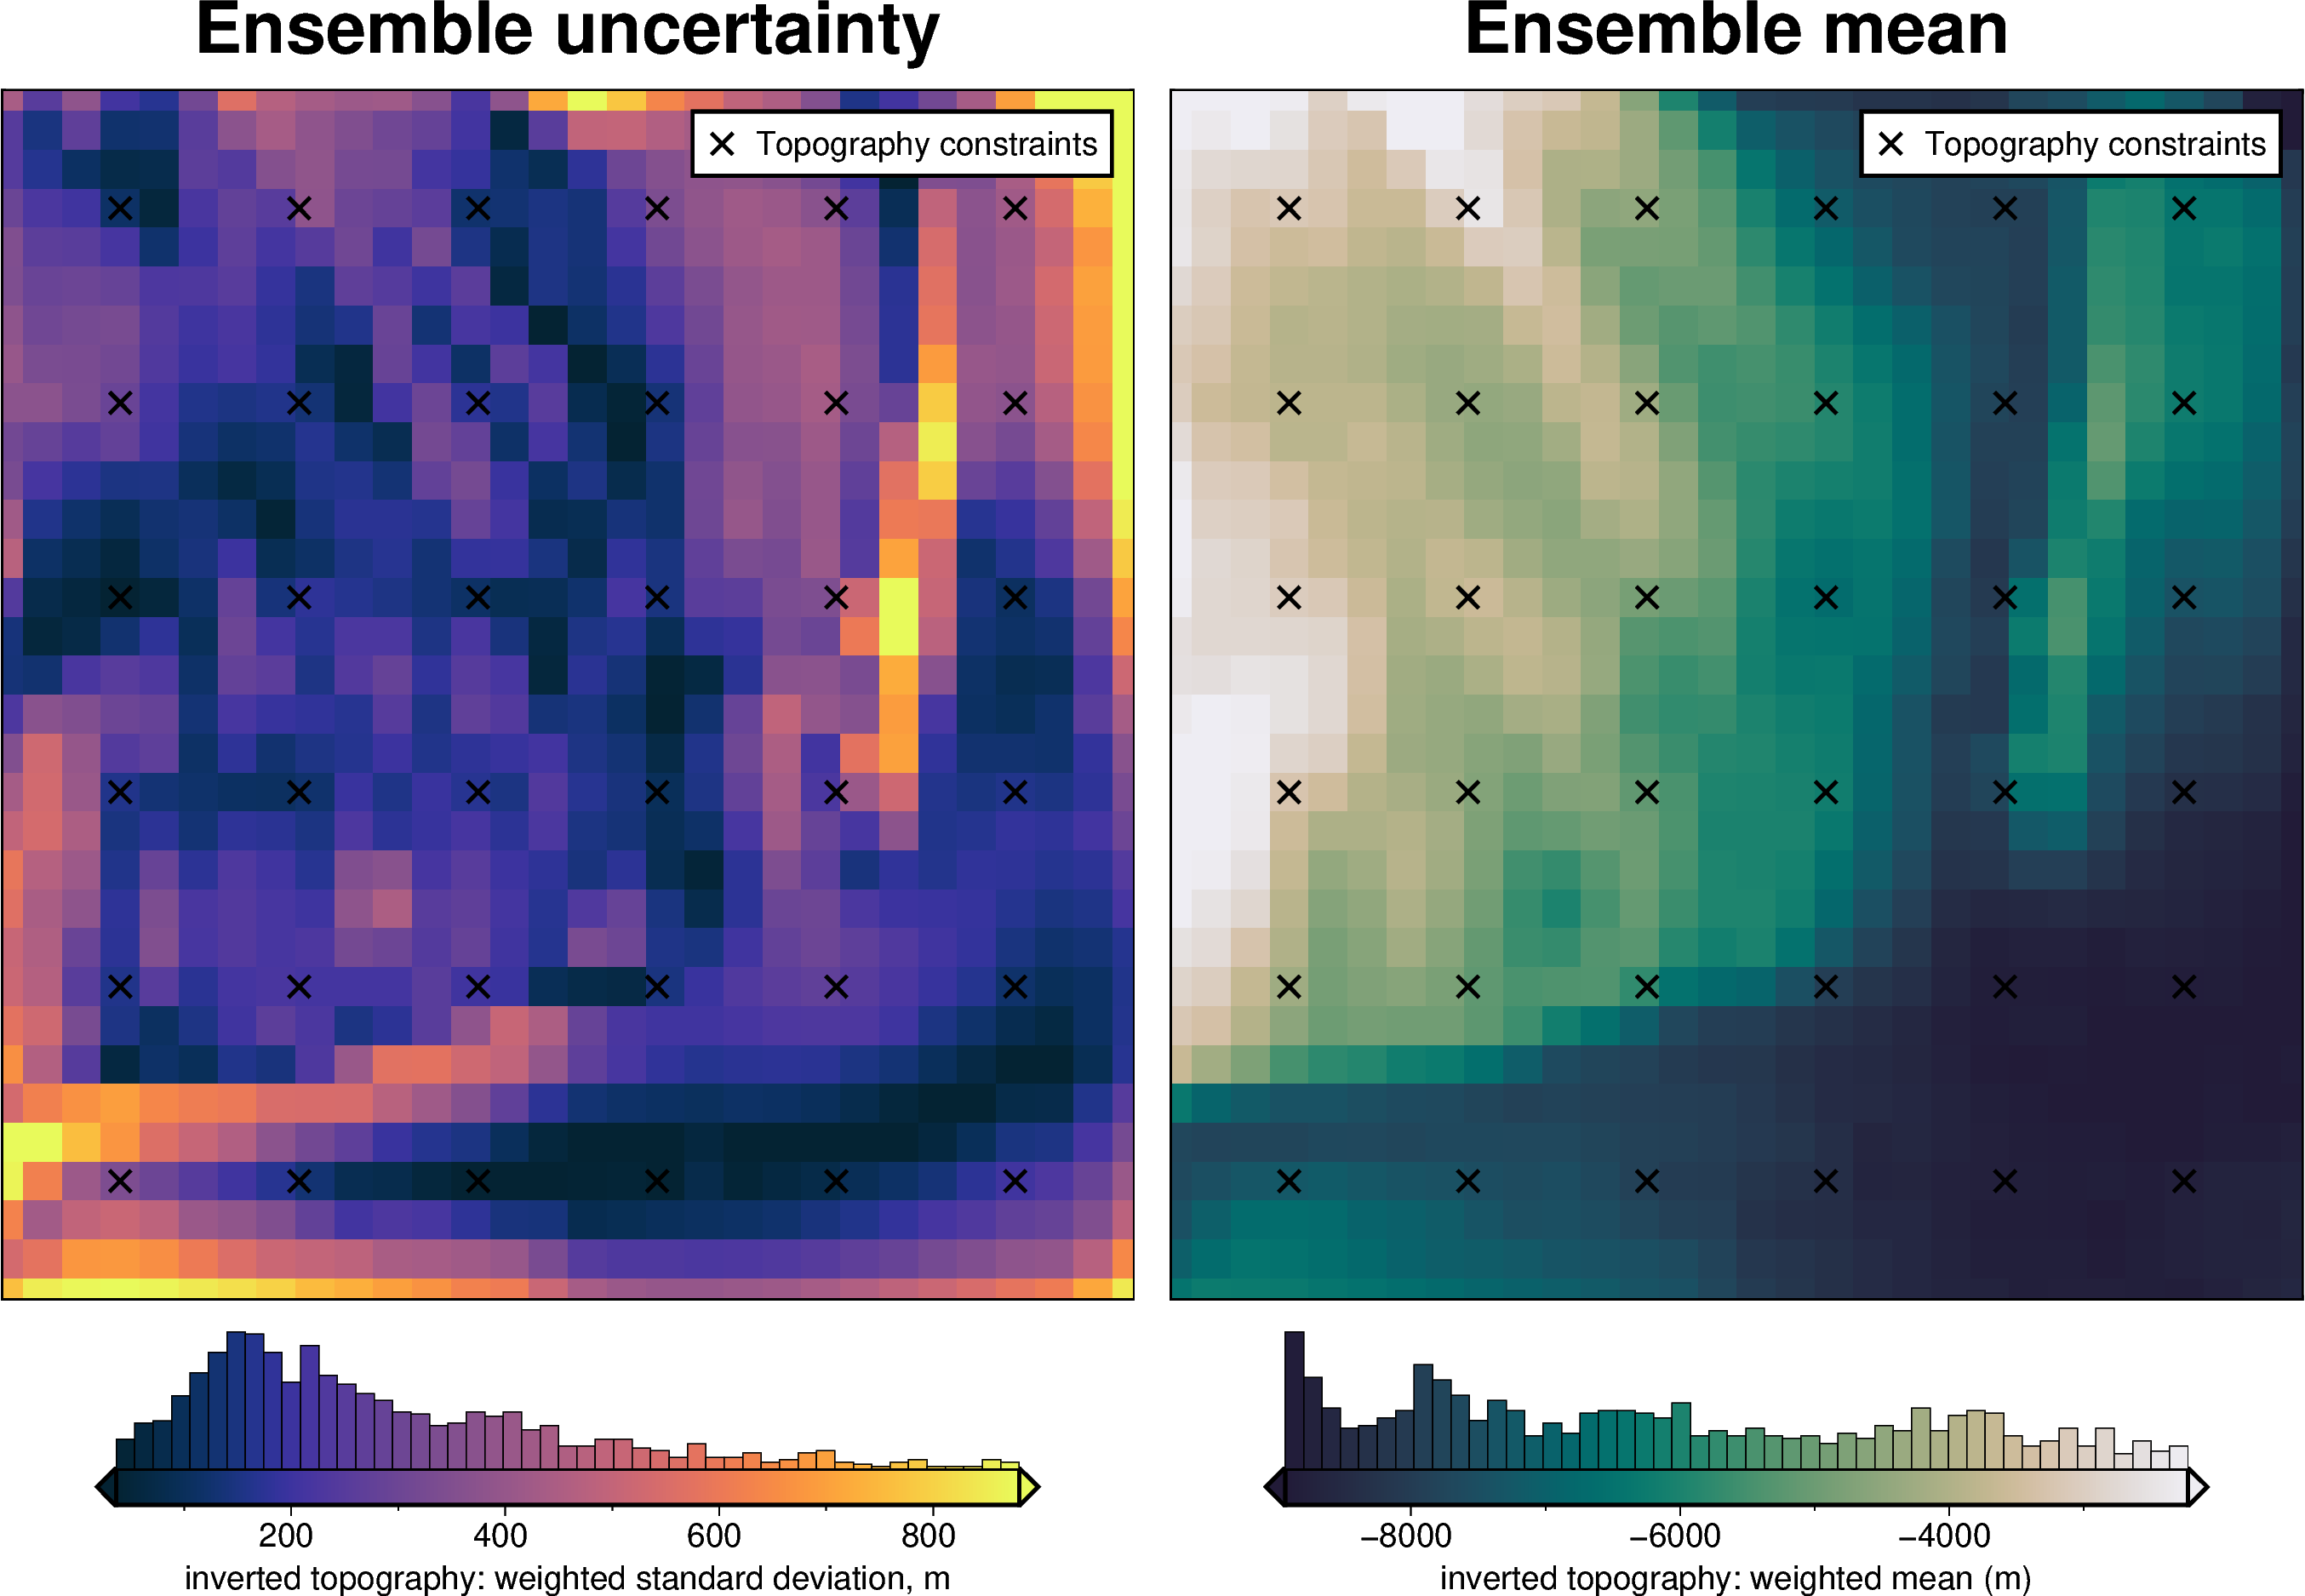

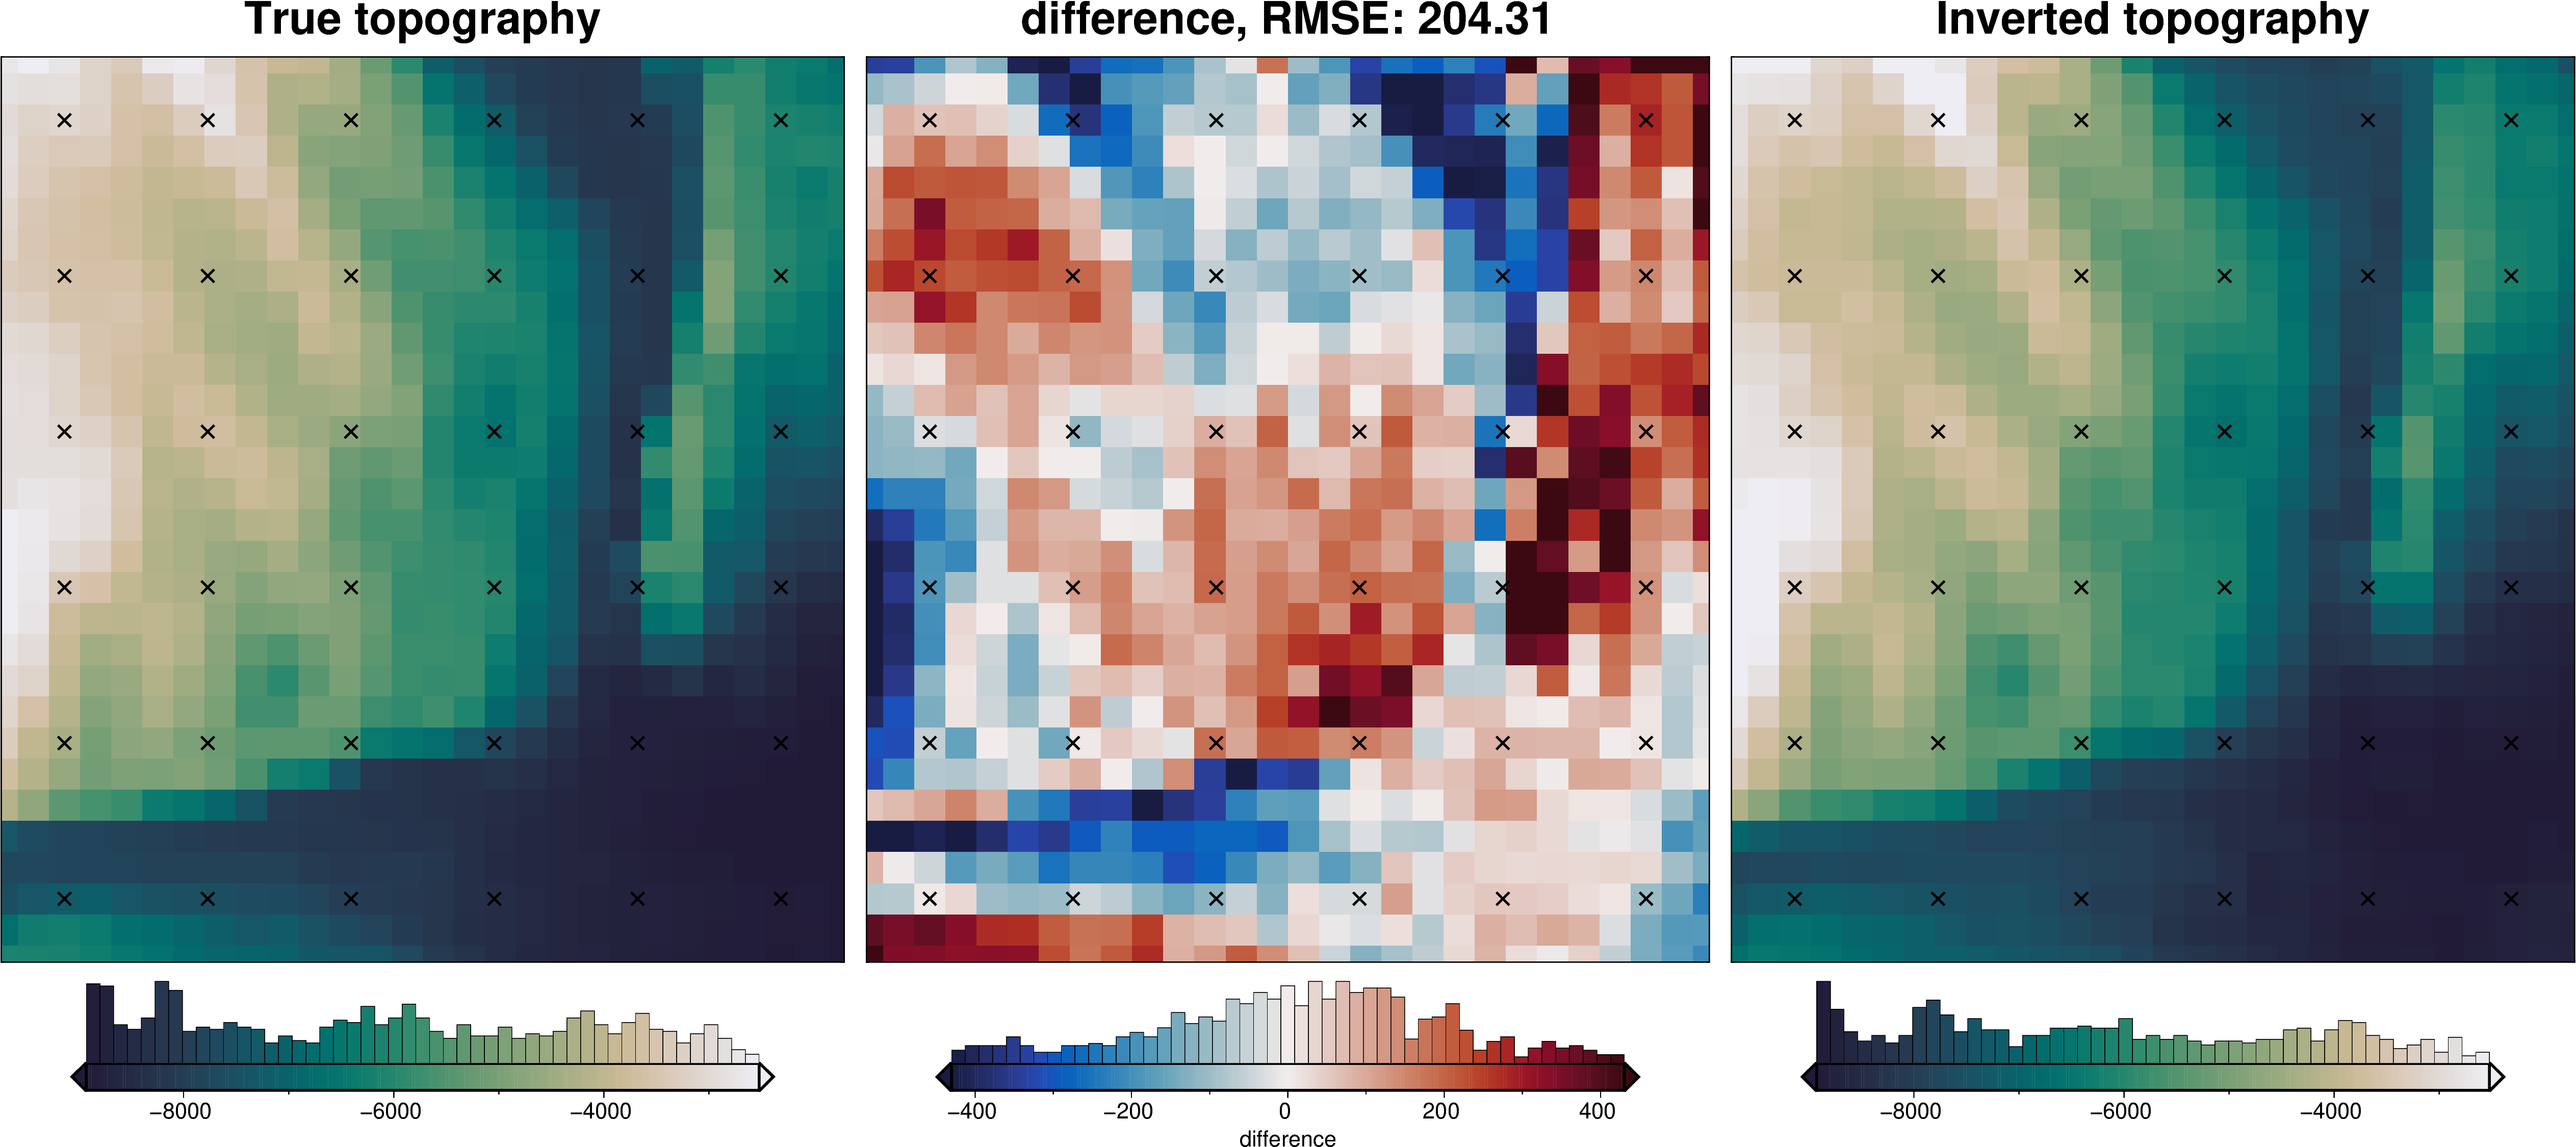

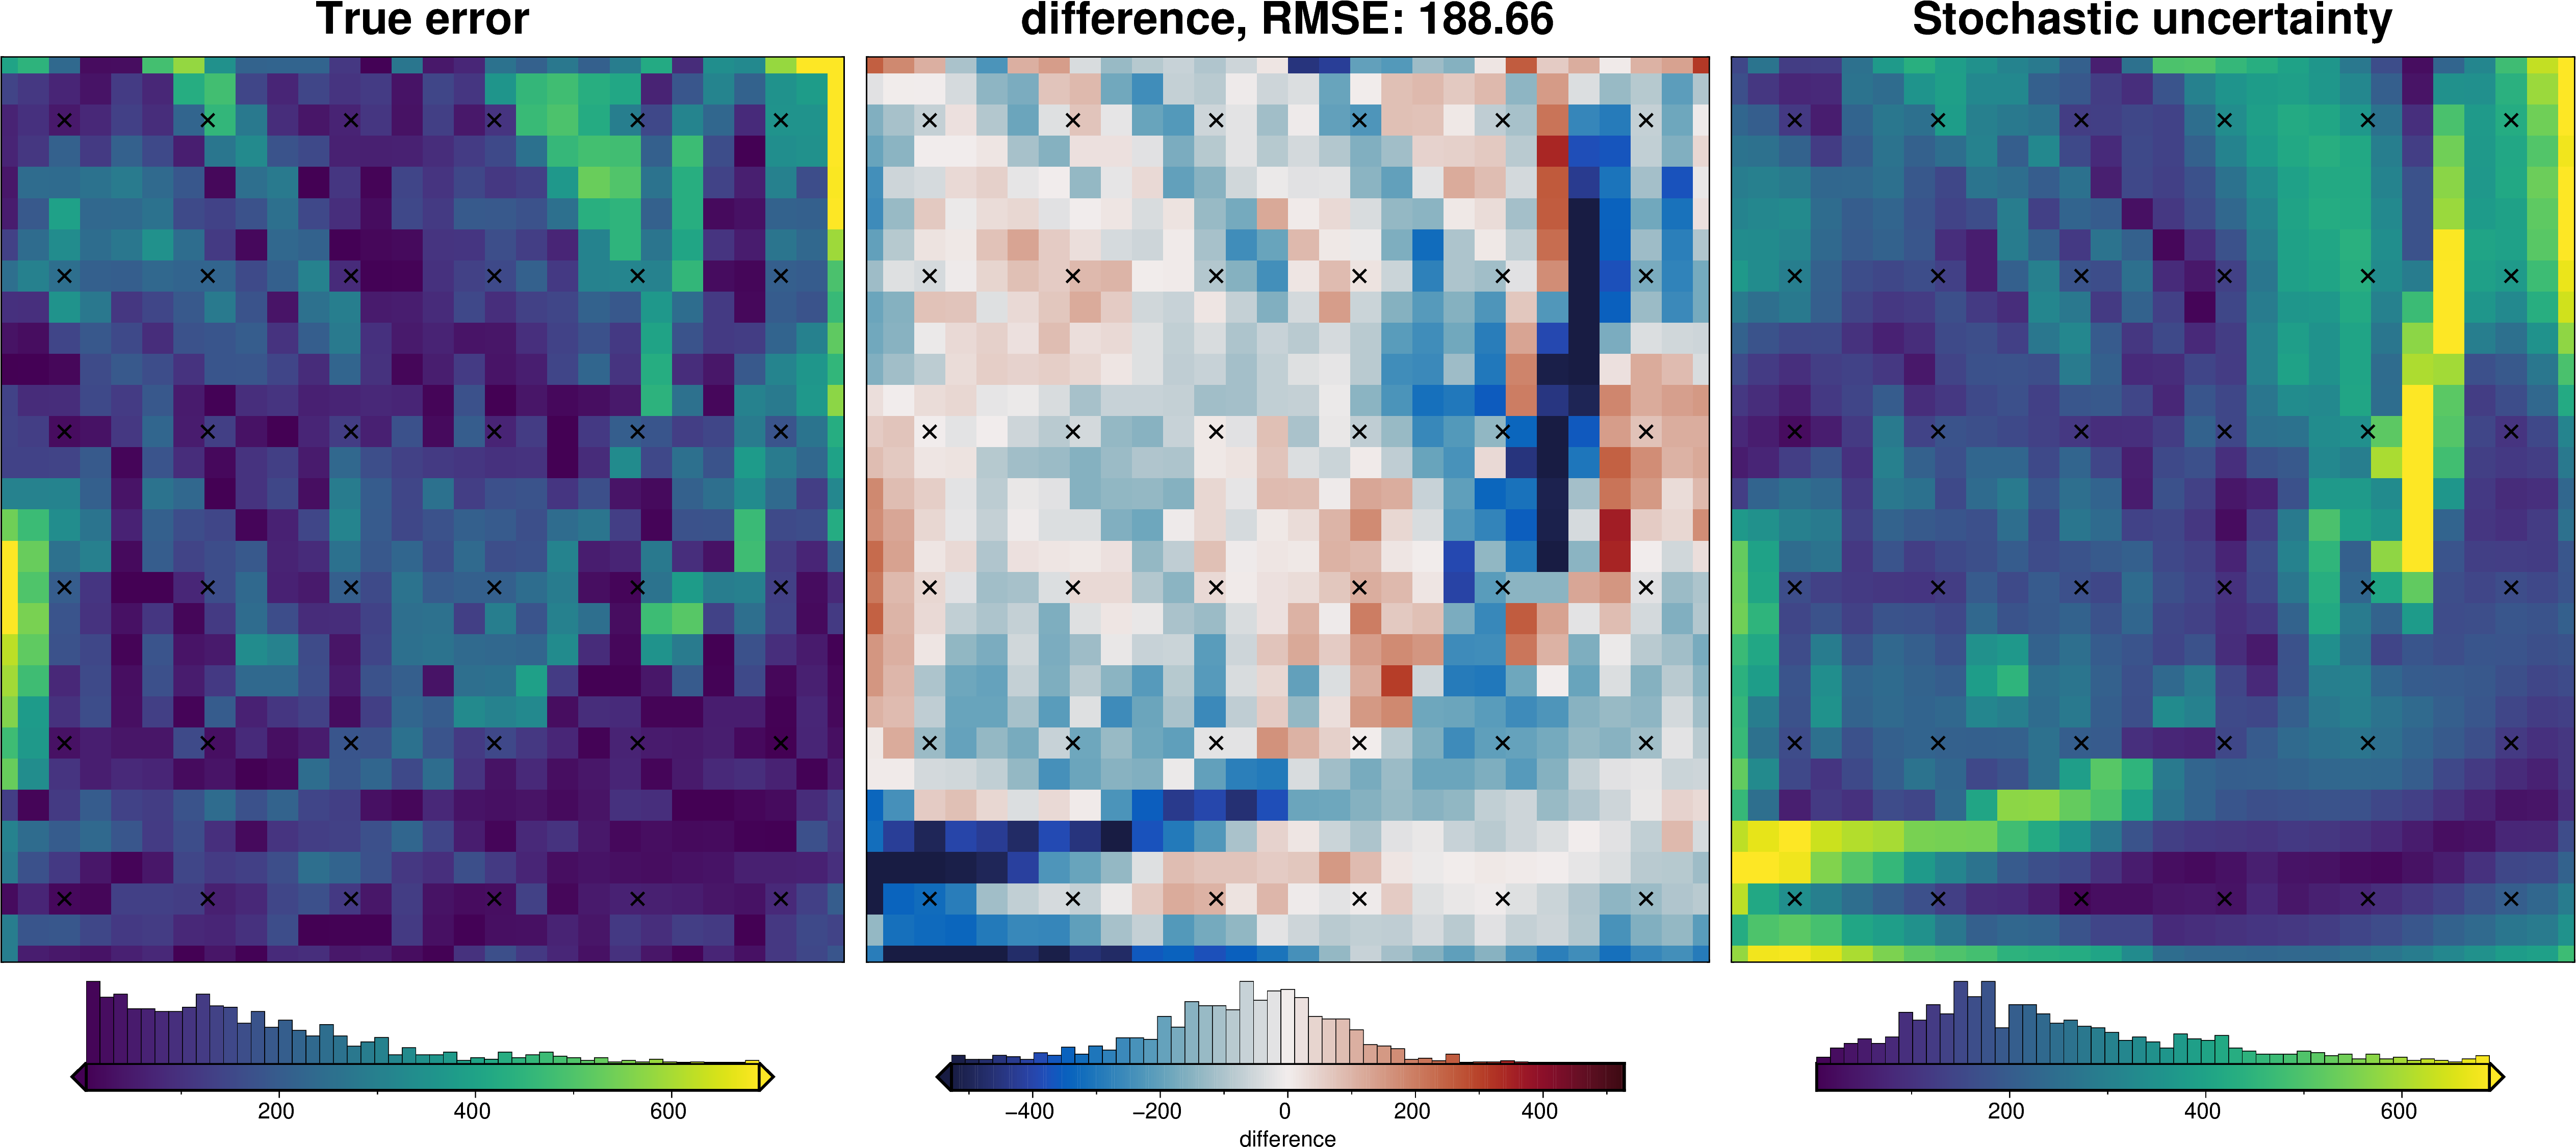

In [44]:
density_dict = {
    "density_contrast": {
        "distribution": "normal",
        "loc": best_density_contrast,
        "scale": stdev,
    },
}

fname = "../tmp/bishop_uncertainty_density"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_density_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=density_dict,
    **uncert_kwargs,
)

uncert_plots(uncert_density_results)

### Zref component

In [45]:
# load study
with pathlib.Path("../tmp/bishop_model_zref_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

study_df = study.trials_dataframe()
study_df = study_df.sort_values("value")

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2 = study_df[(np.abs(study_df.value_zscore) < 2)]

stdev = study_df2.params_zref.std()
print(f"calculated stdev: {stdev}")

# manually pick a stdev
# stdev = 20
print(f"using stdev: {stdev}")

calculated stdev: 1287.9715049618599
using stdev: 1287.9715049618599


best: -6290.718052642159 
std: 1287.9715049618599 
+1std: -5002.746547680299 
-1std: -7578.689557604019


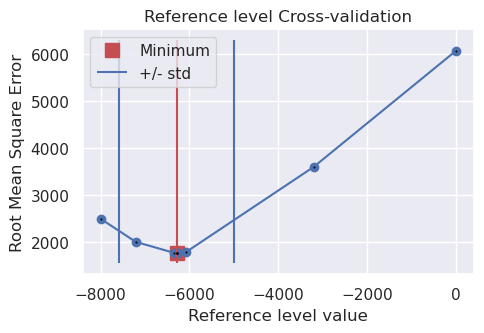

In [46]:
fig = plotting.plot_cv_scores(
    study.trials_dataframe().value.values,
    study.trials_dataframe().params_zref.values,
    param_name="Reference level",
    logx=False,
    logy=False,
)
ax = fig.axes[0]

best = study_df2.params_zref.iloc[0]
upper = best + stdev
lower = best - stdev

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

INFO:invert4geom:Sampled 'zref' parameter values; mean: -6290.718052642159, min: -8409.242653988822, max: -4172.193451295498
INFO:invert4geom:No pickle files starting with '../tmp/bishop_uncertainty_zref' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../tmp/bishop_uncertainty_zref'



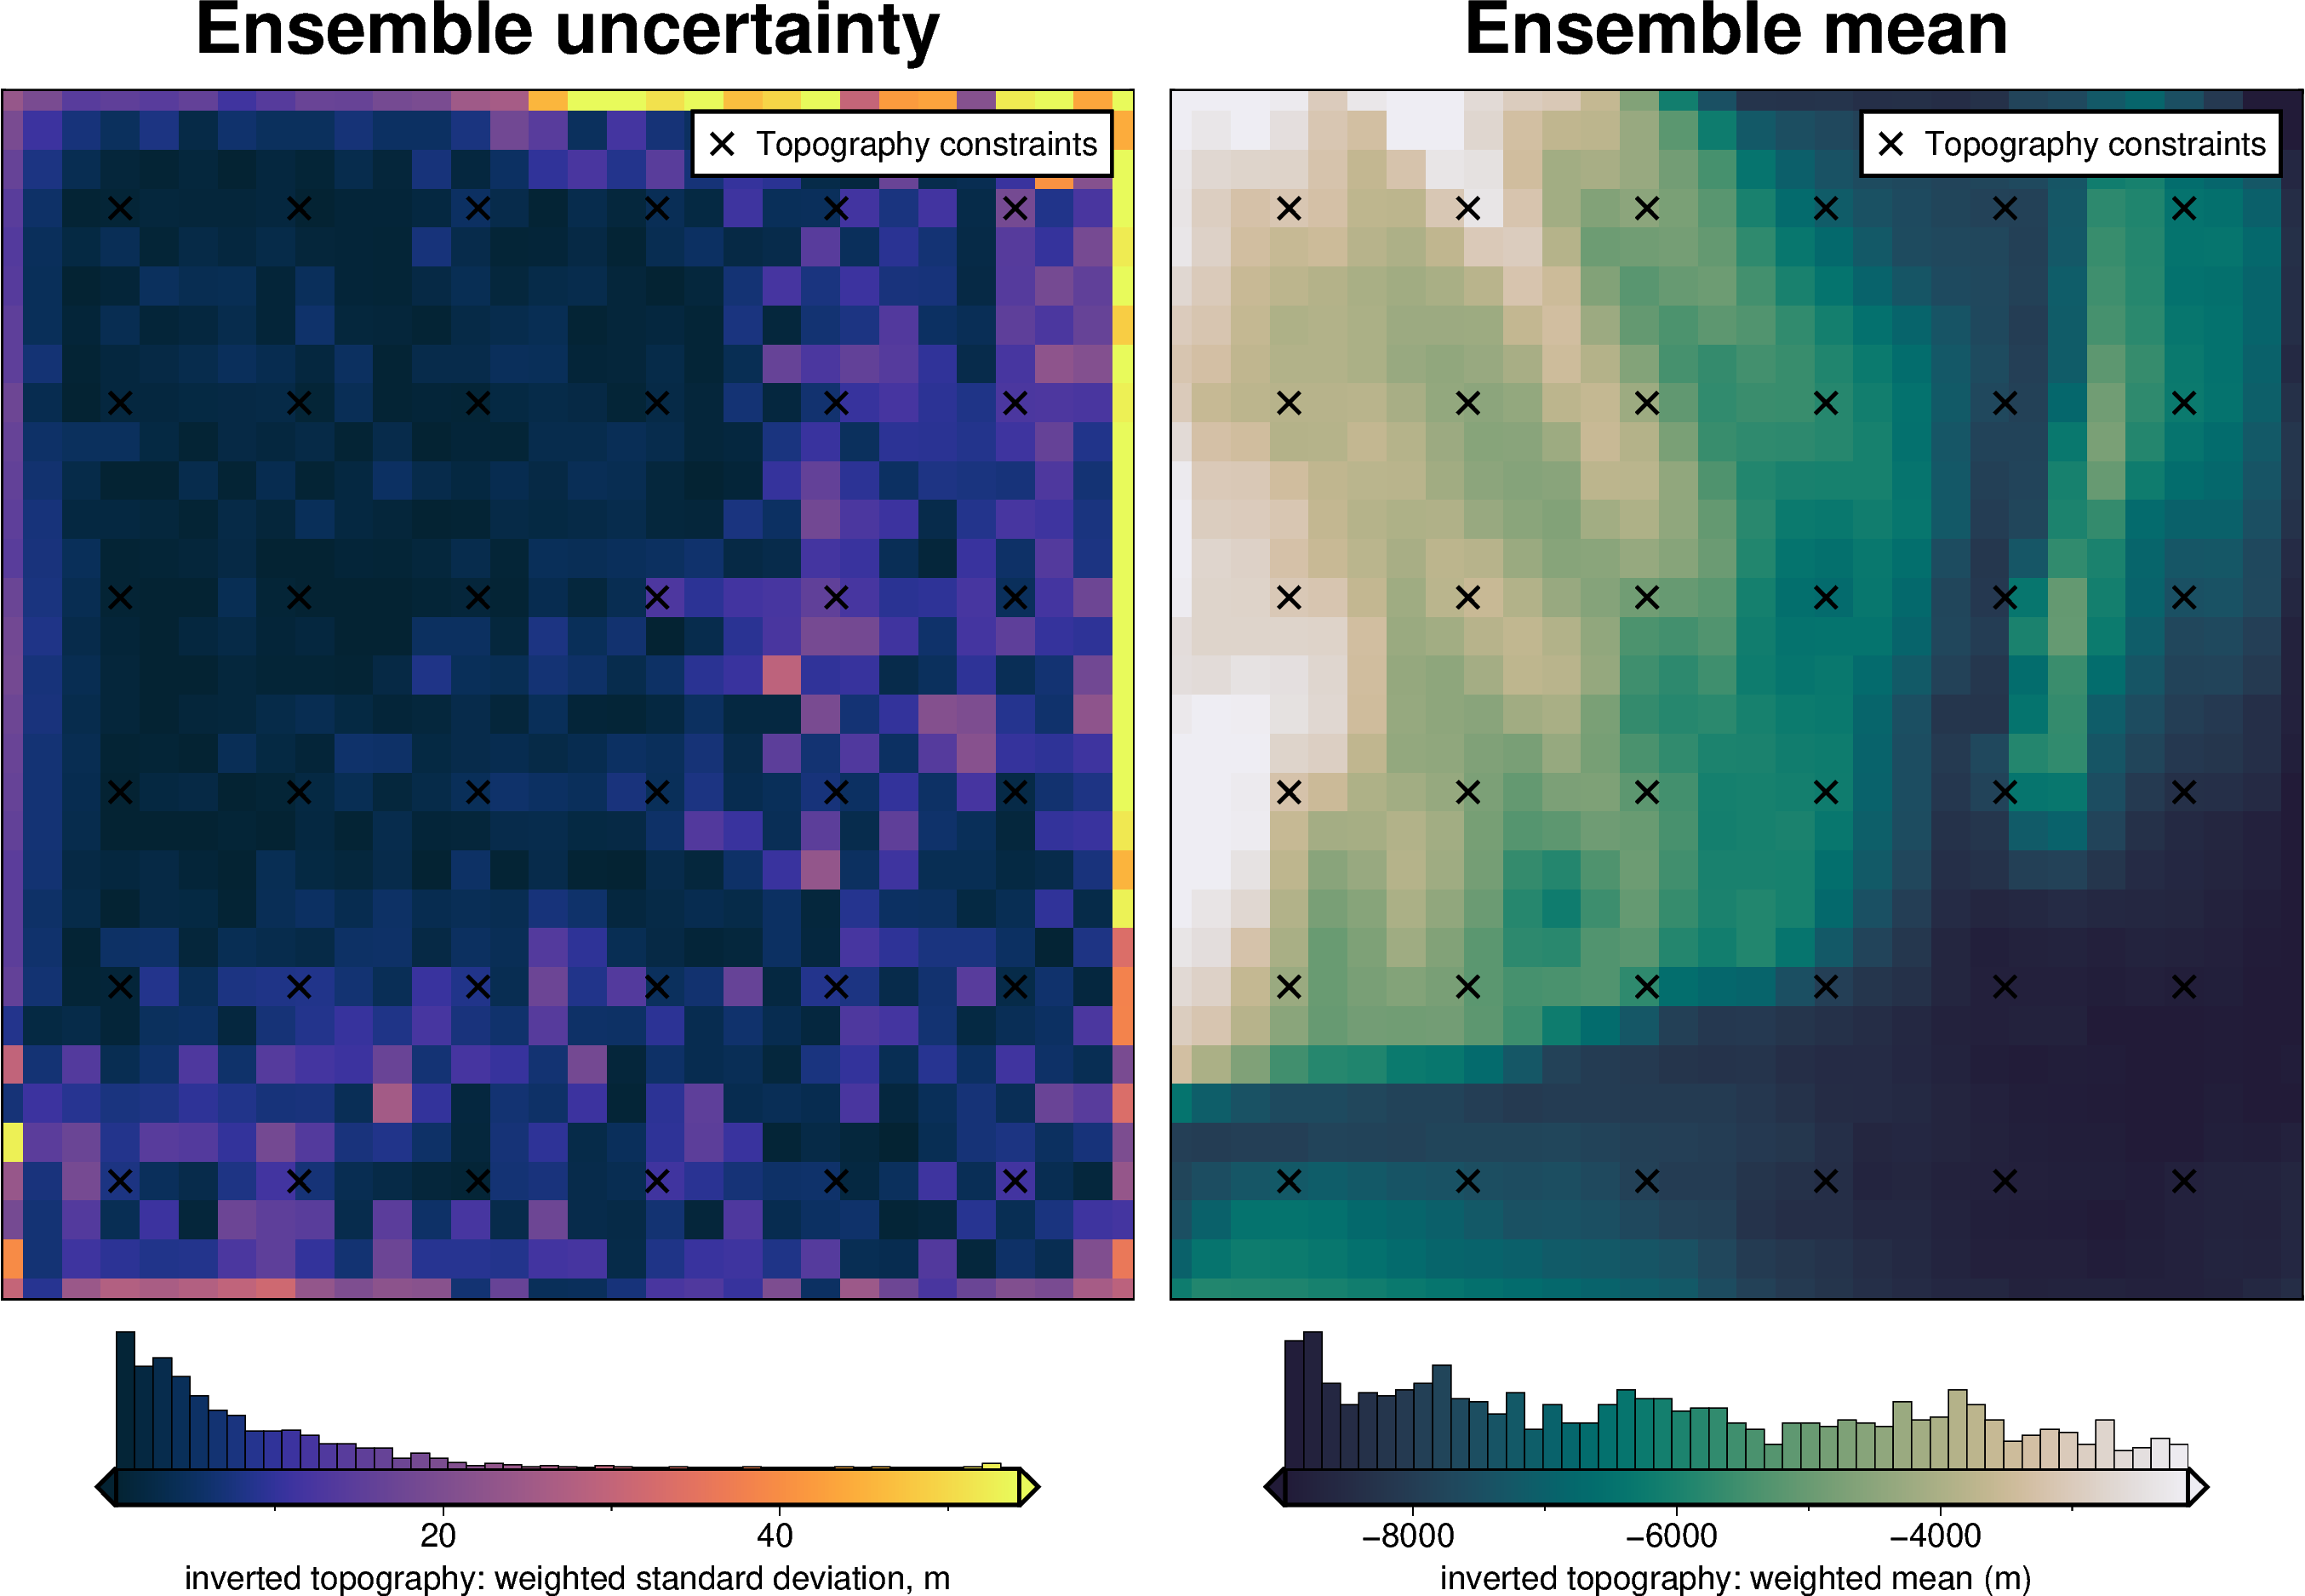

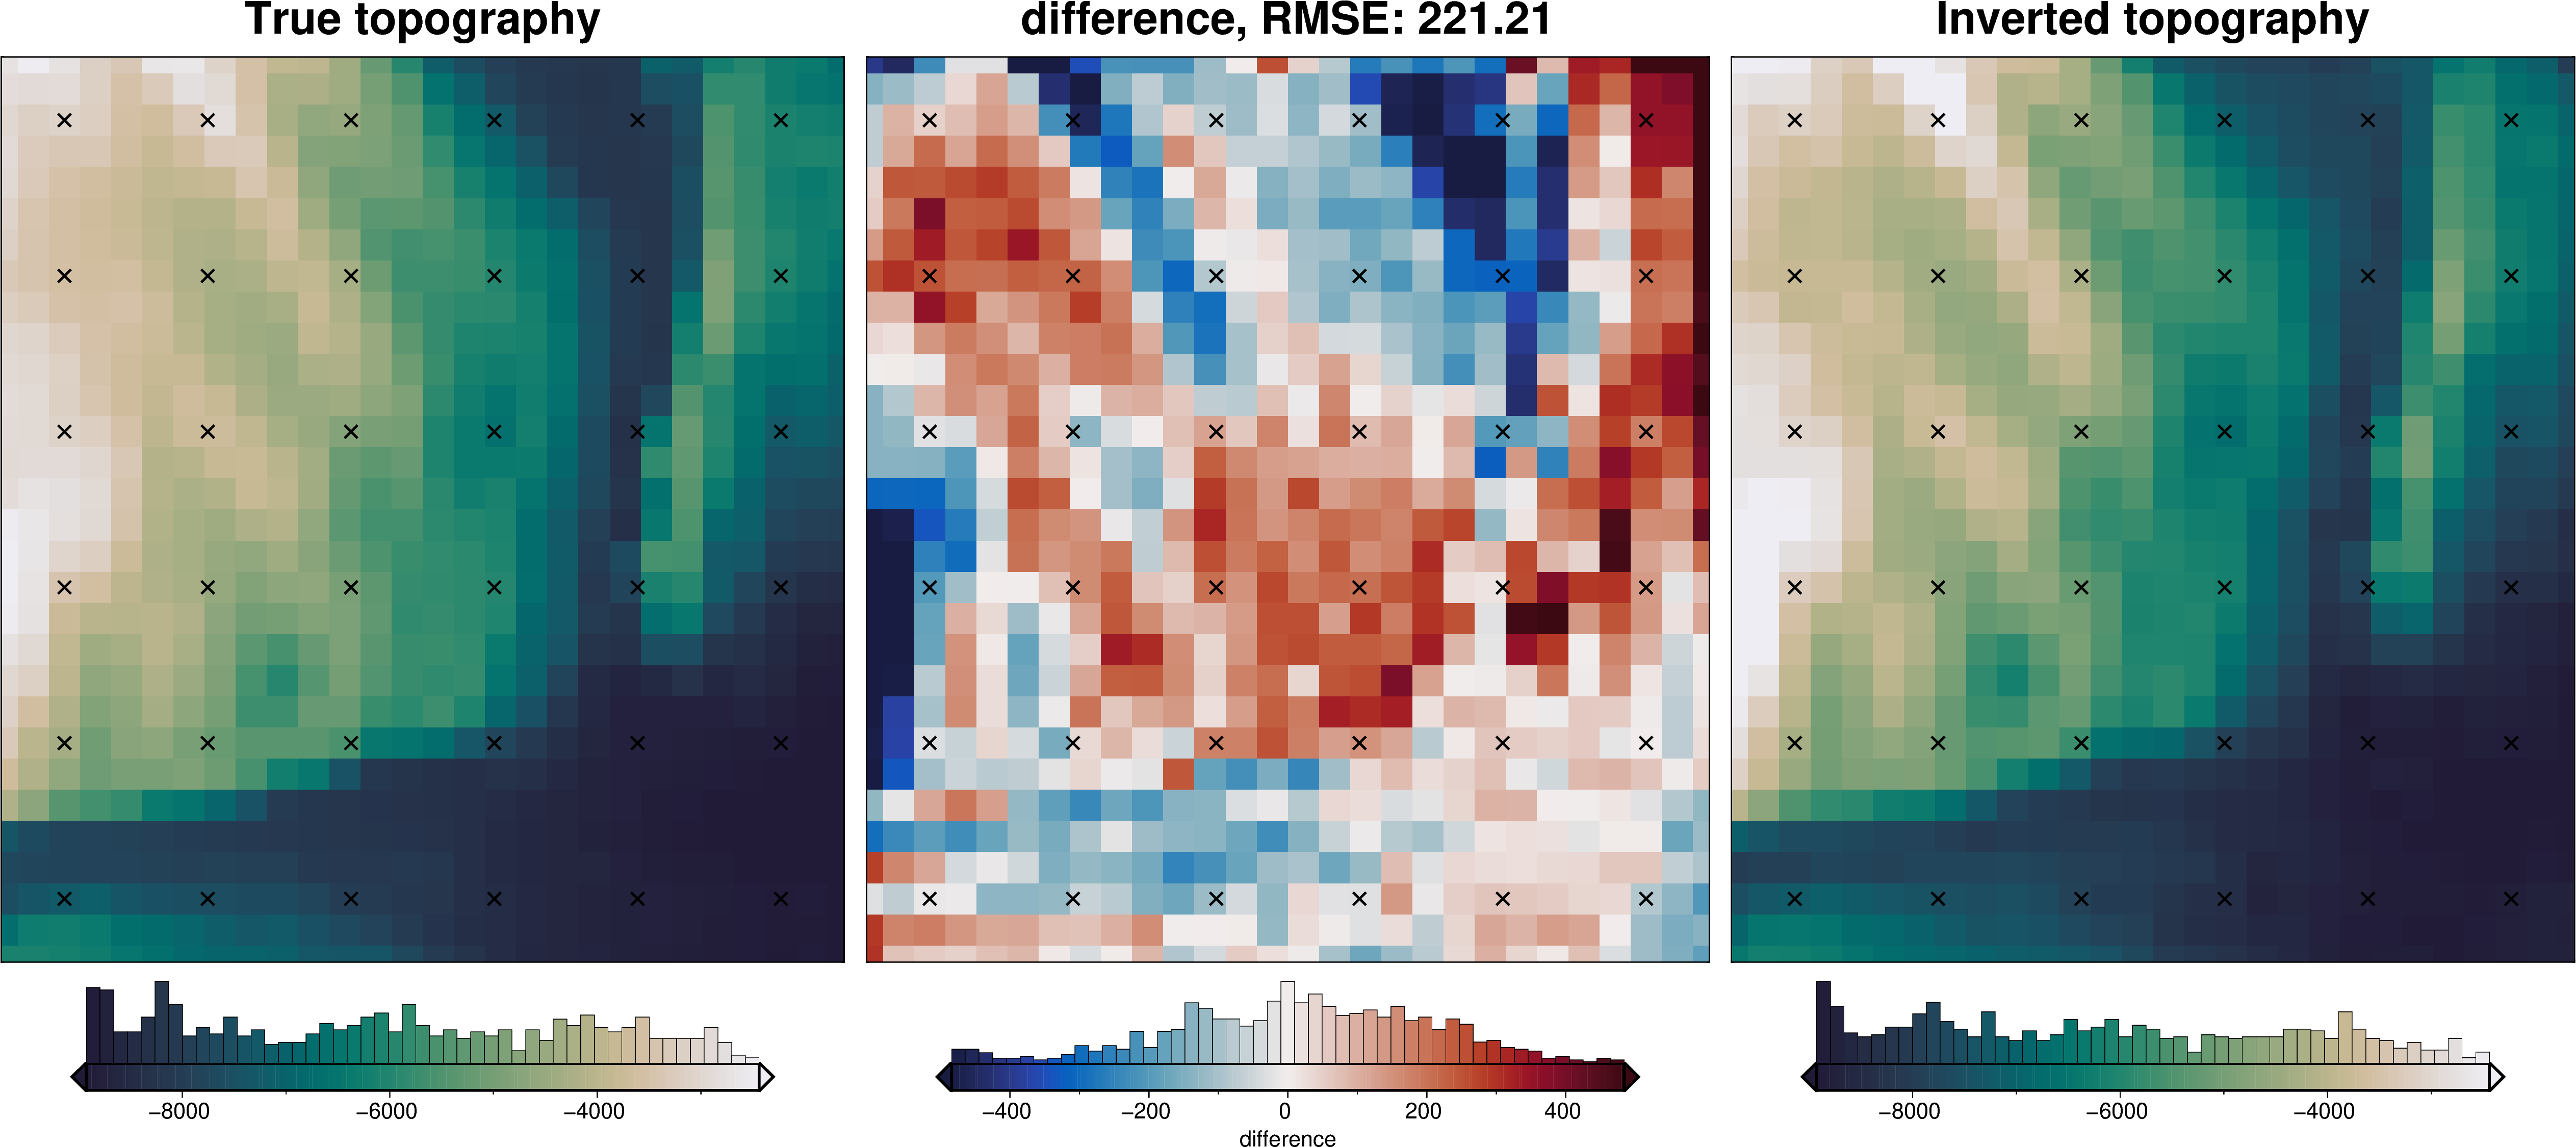

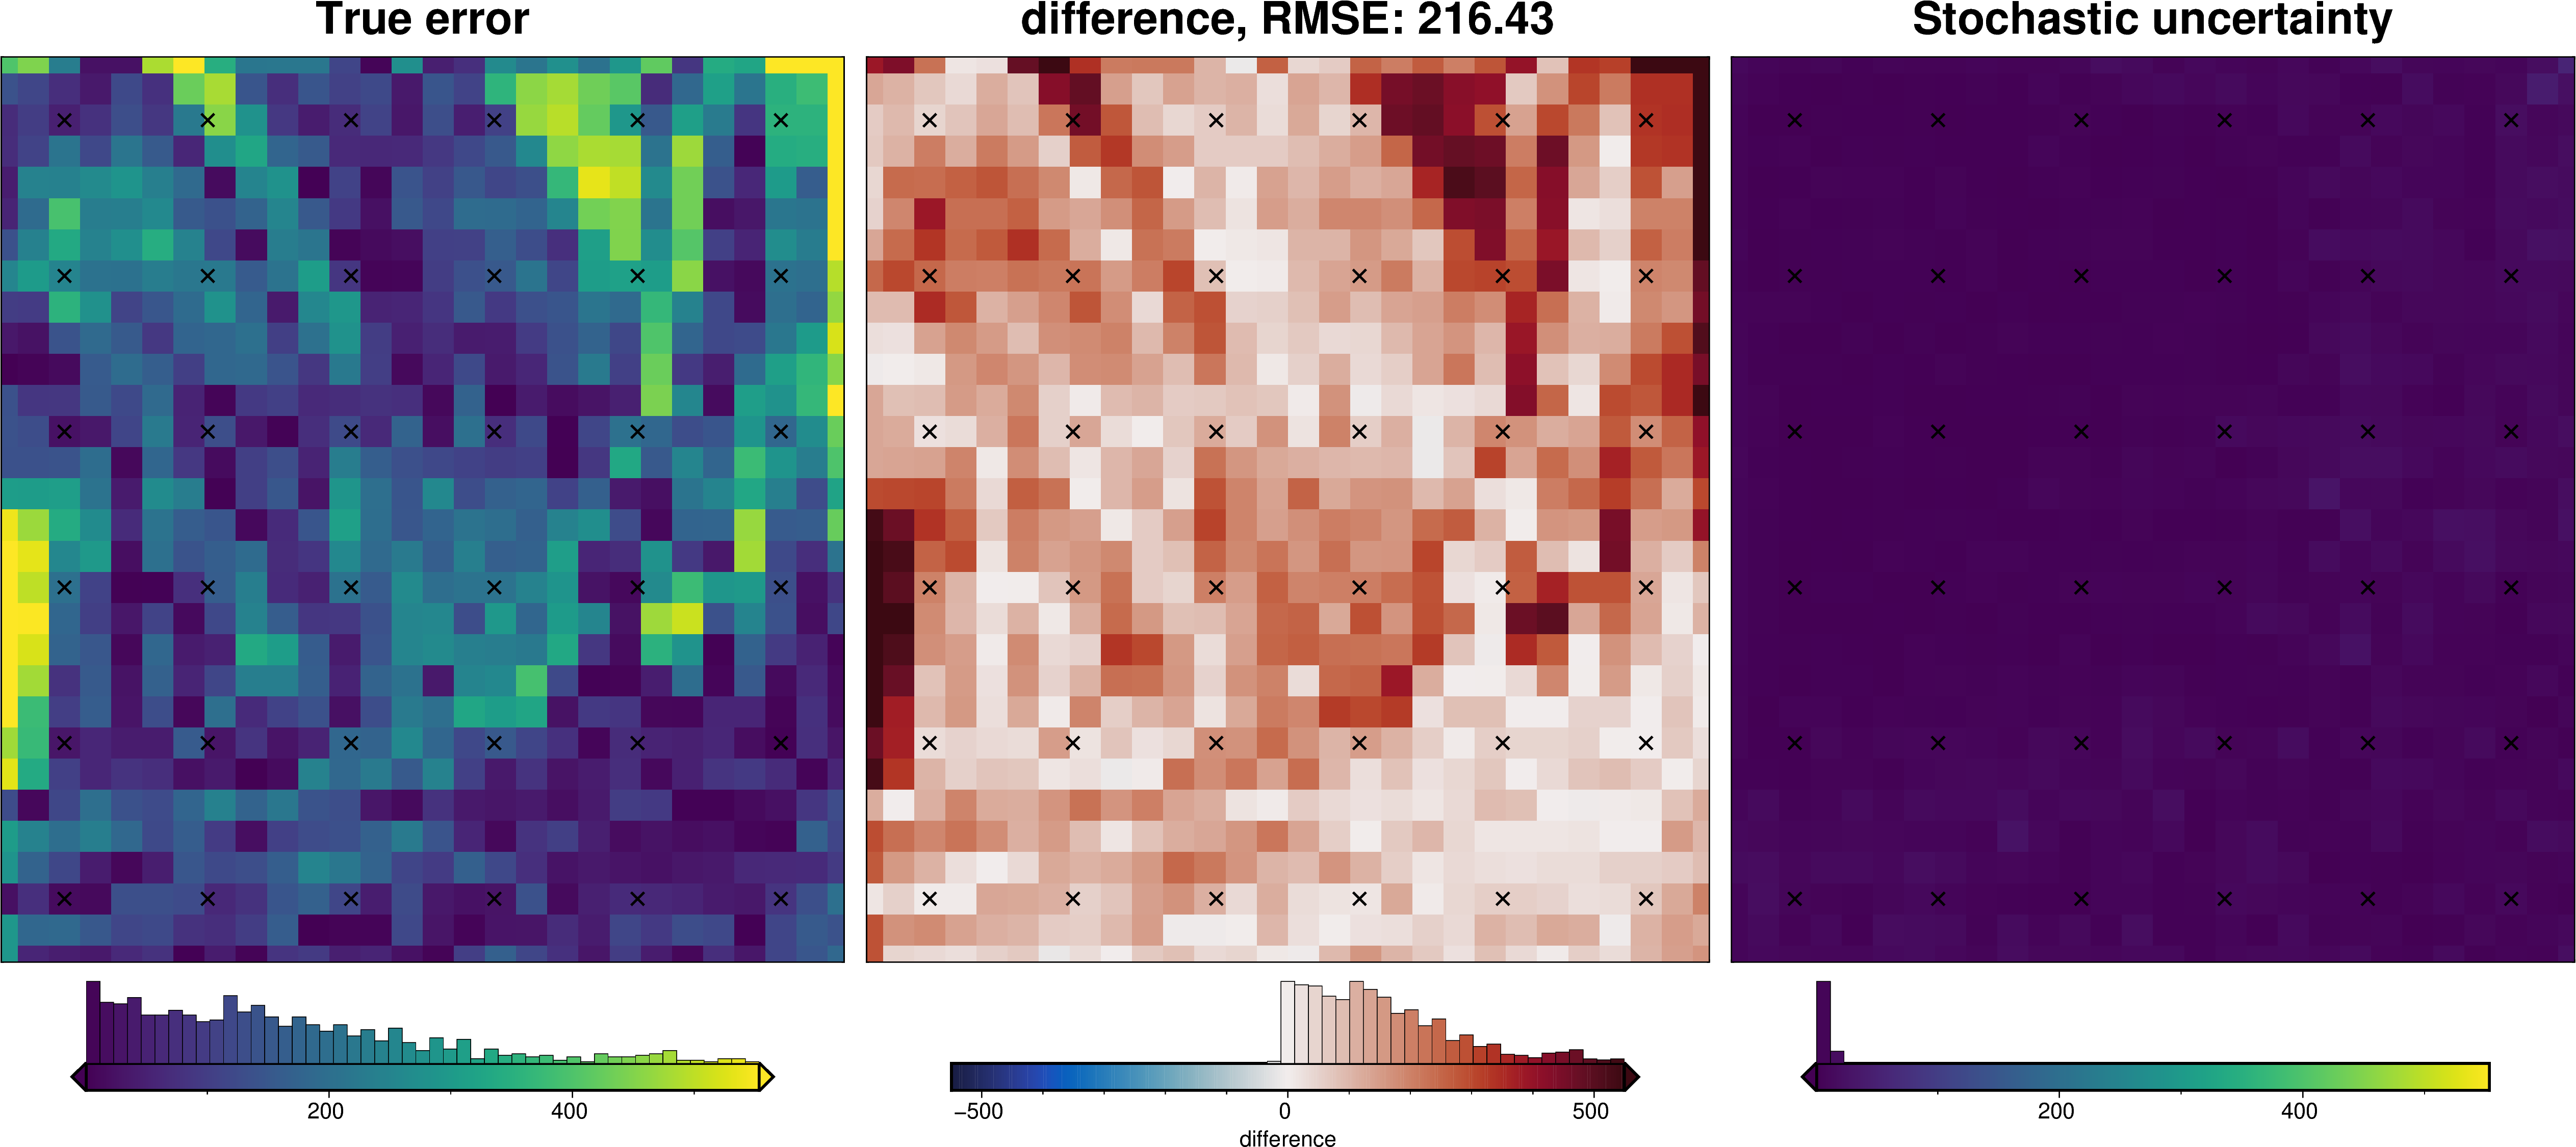

In [47]:
zref_dict = {
    "zref": {
        "distribution": "normal",
        "loc": best_zref,
        "scale": stdev,
    },
}

fname = "../tmp/bishop_uncertainty_zref"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_zref_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=zref_dict,
    **uncert_kwargs,
)

uncert_plots(uncert_zref_results)

### Damping component

In [48]:
# load study
with pathlib.Path("../tmp/bishop_model_damping_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

study_df = study.trials_dataframe().drop(columns=["user_attrs_results"])
study_df = study_df.sort_values("value")

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2 = study_df[(np.abs(study_df.value_zscore) < 2)]

# pick damping standard deviation based on optimization
stdev = np.log10(study_df2.params_damping).std()
print(f"calculated stdev: {stdev}")
# stdev = 0.4
print(f"using stdev: {stdev}")

calculated stdev: 0.43940624542559564
using stdev: 0.43940624542559564


best: 0.004809585422671533 
std: 0.43940624542559564 
+1std: 0.013228600102574772 
-1std: 0.0017486439803613188


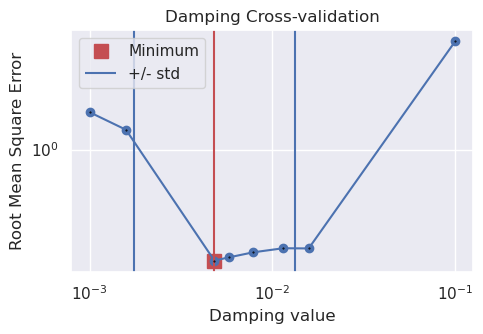

In [49]:
fig = plotting.plot_cv_scores(
    study_df.value,
    study_df.params_damping,
    param_name="Damping",
    logx=True,
    logy=True,
)
ax = fig.axes[0]

best = float(study_df2.params_damping.iloc[0])
upper = float(10 ** (np.log10(best) + stdev))
lower = float(10 ** (np.log10(best) - stdev))

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.007372708077833259, min: 0.0009106441166537271, max: 0.025401923226579724
INFO:invert4geom:No pickle files starting with '../tmp/bishop_uncertainty_damping' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../tmp/bishop_uncertainty_damping'



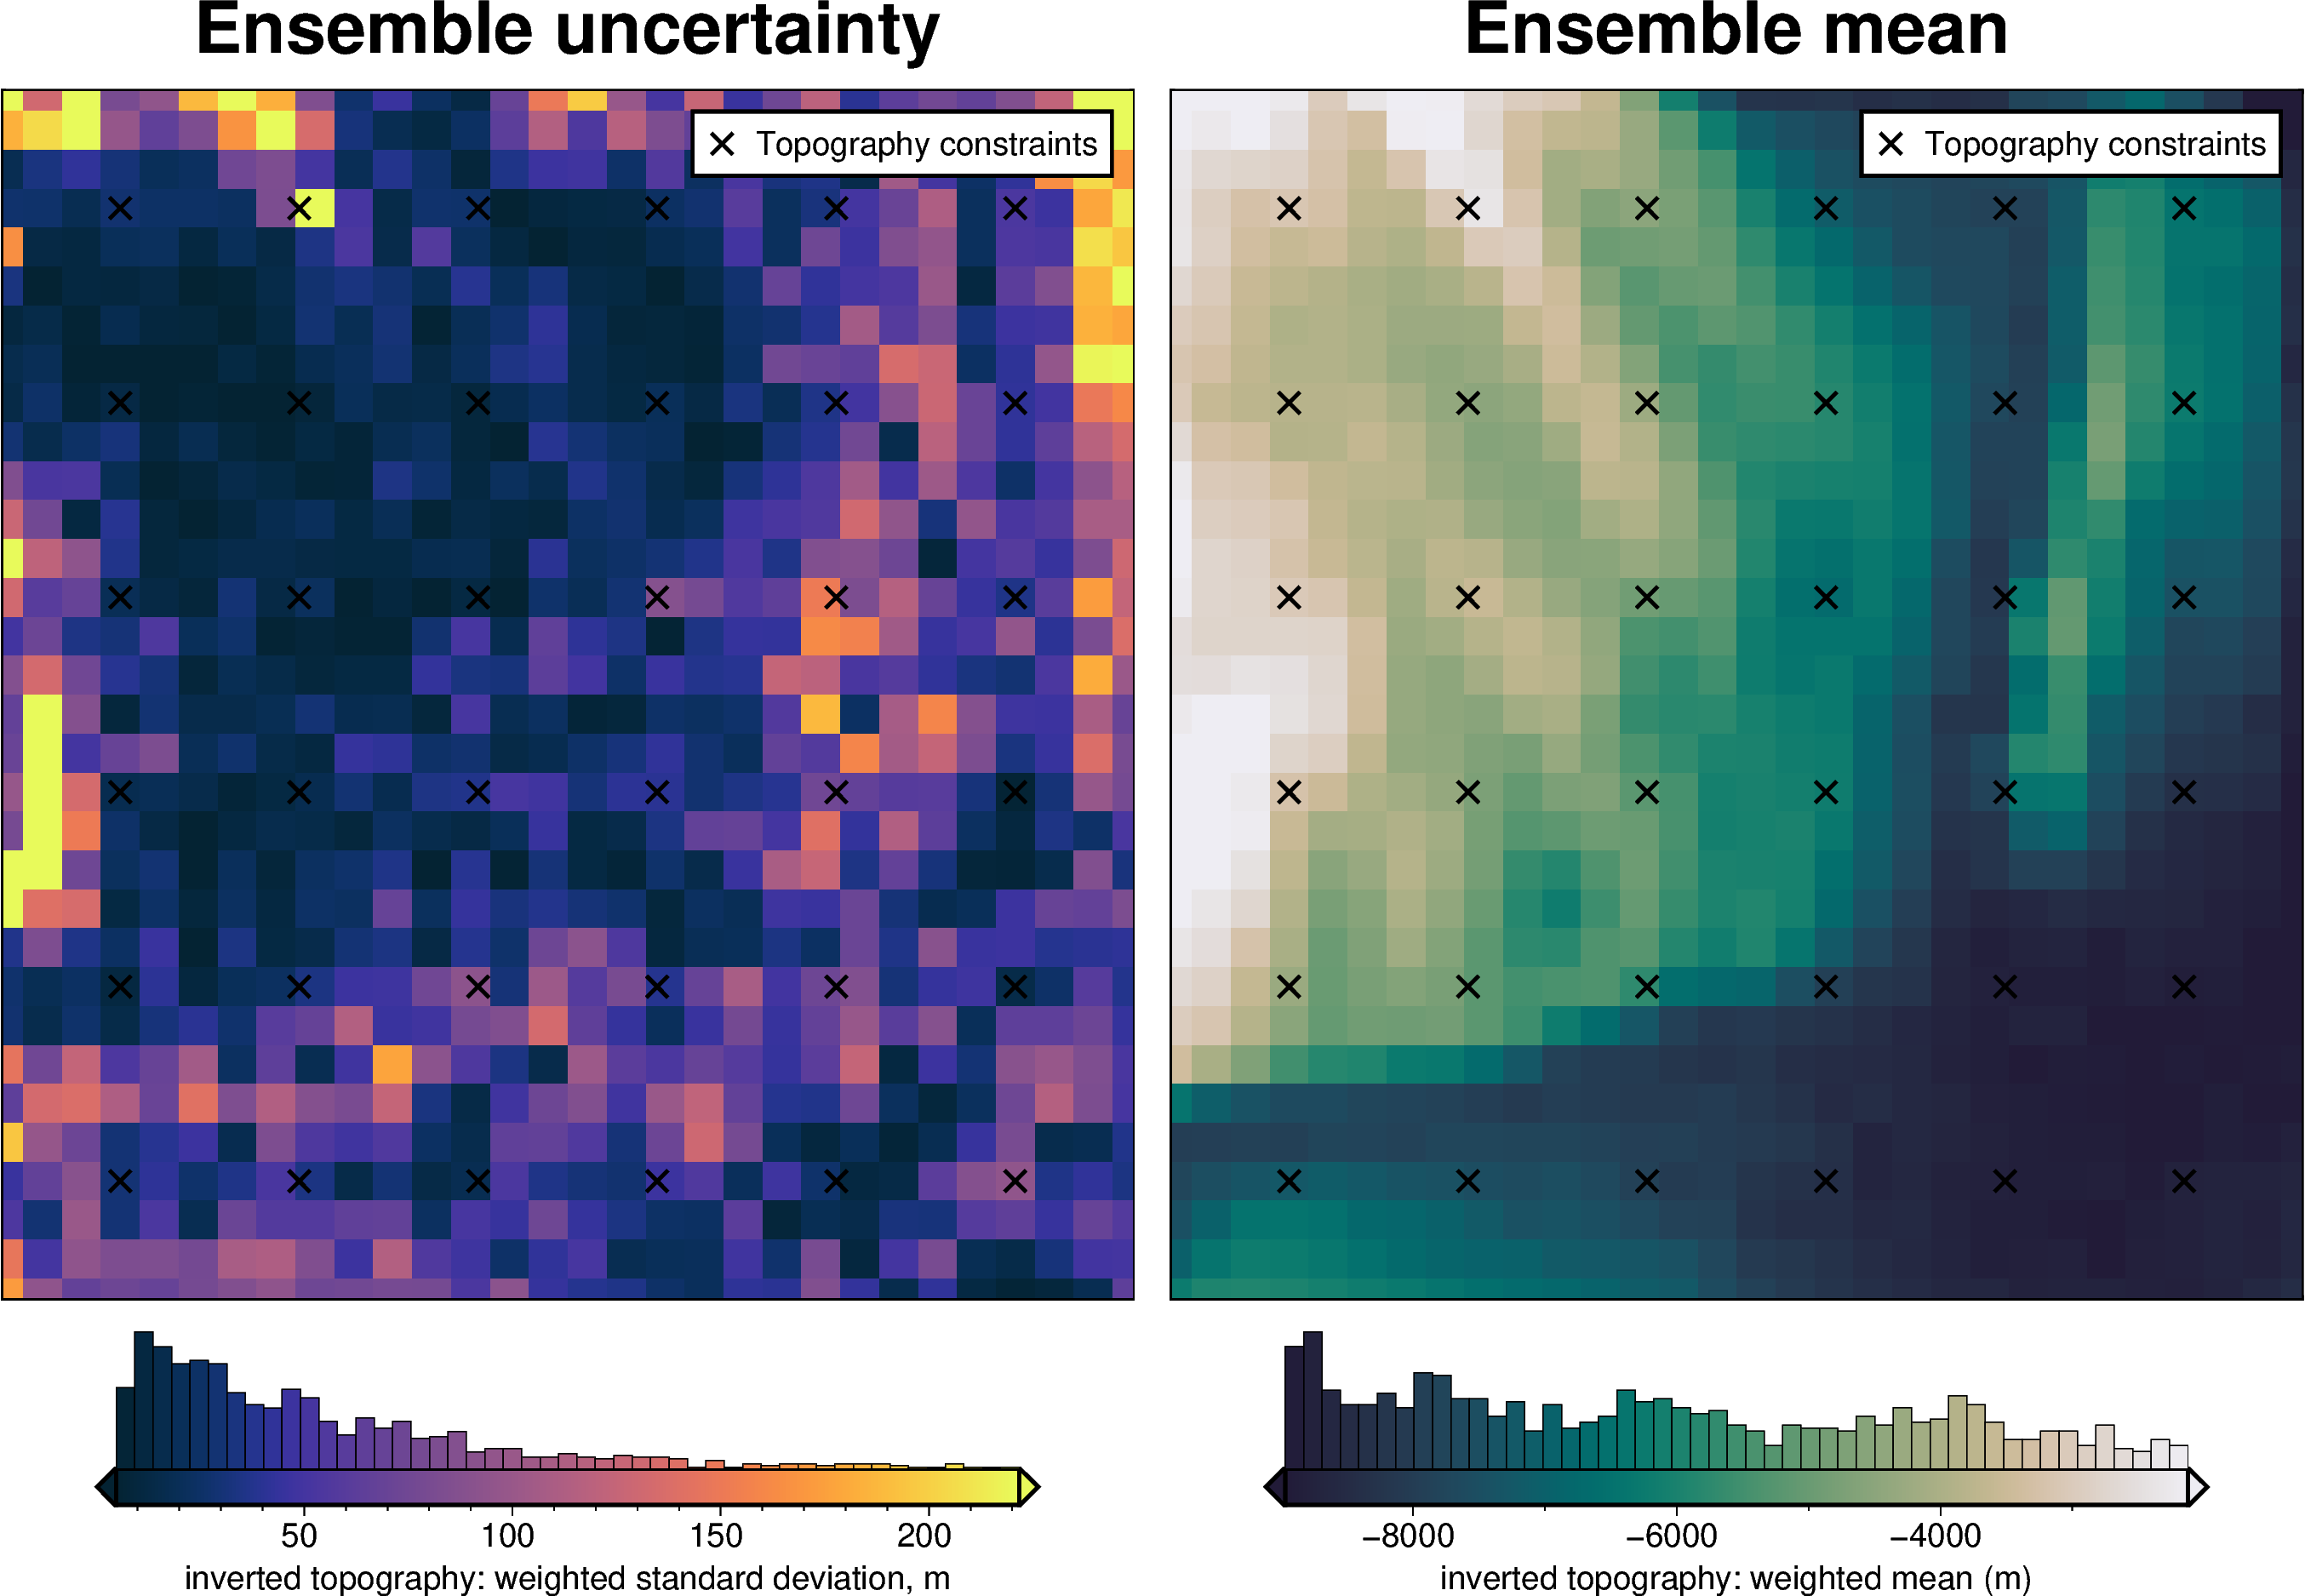

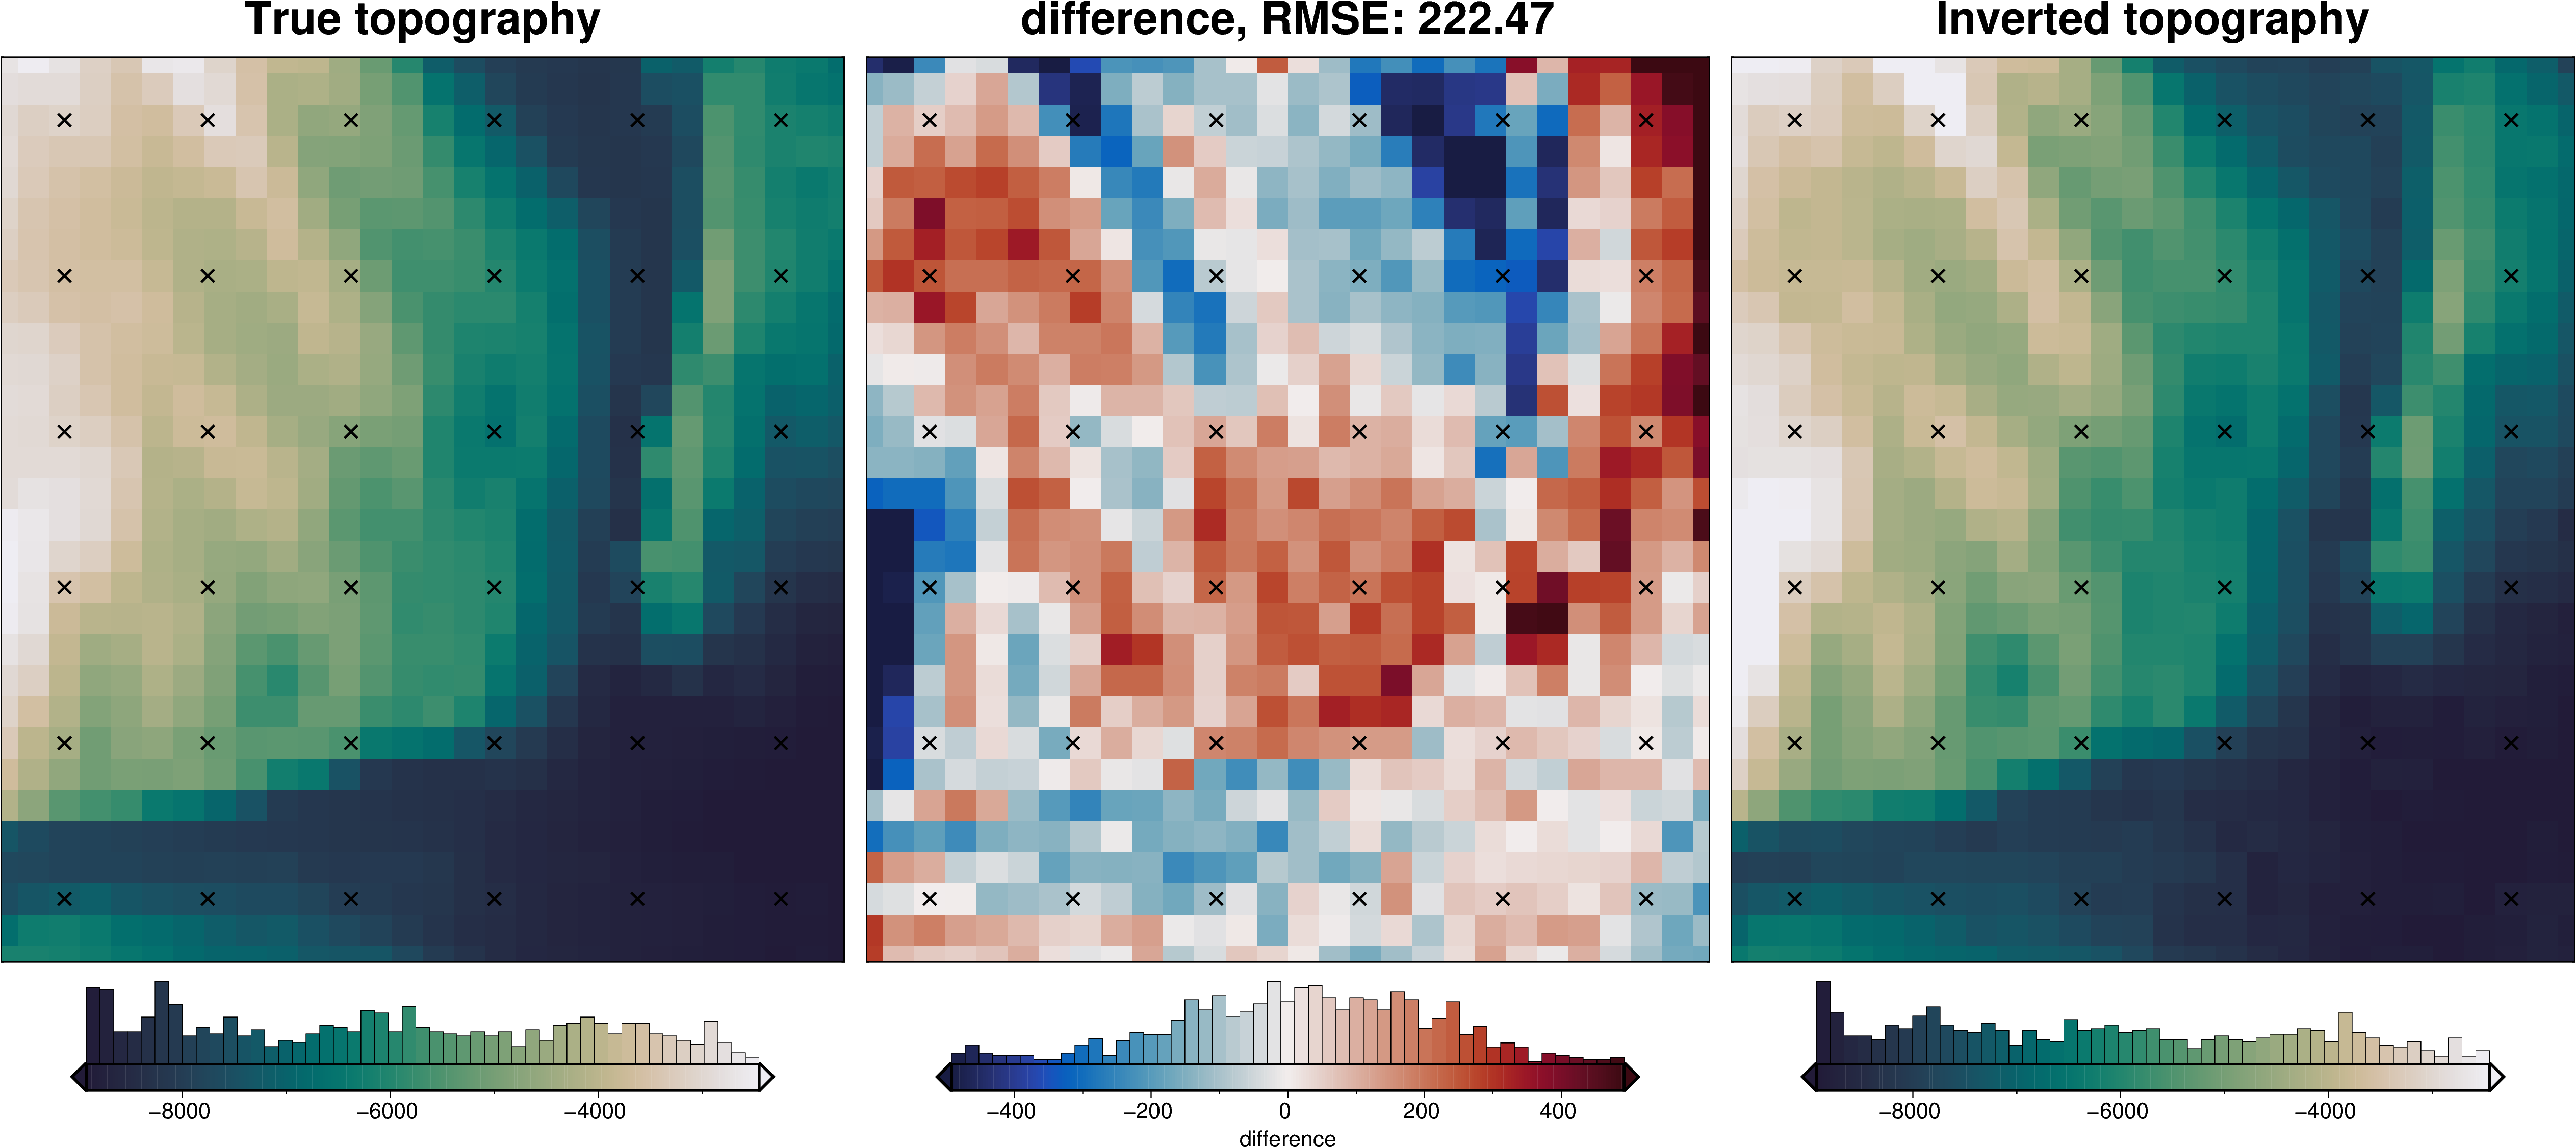

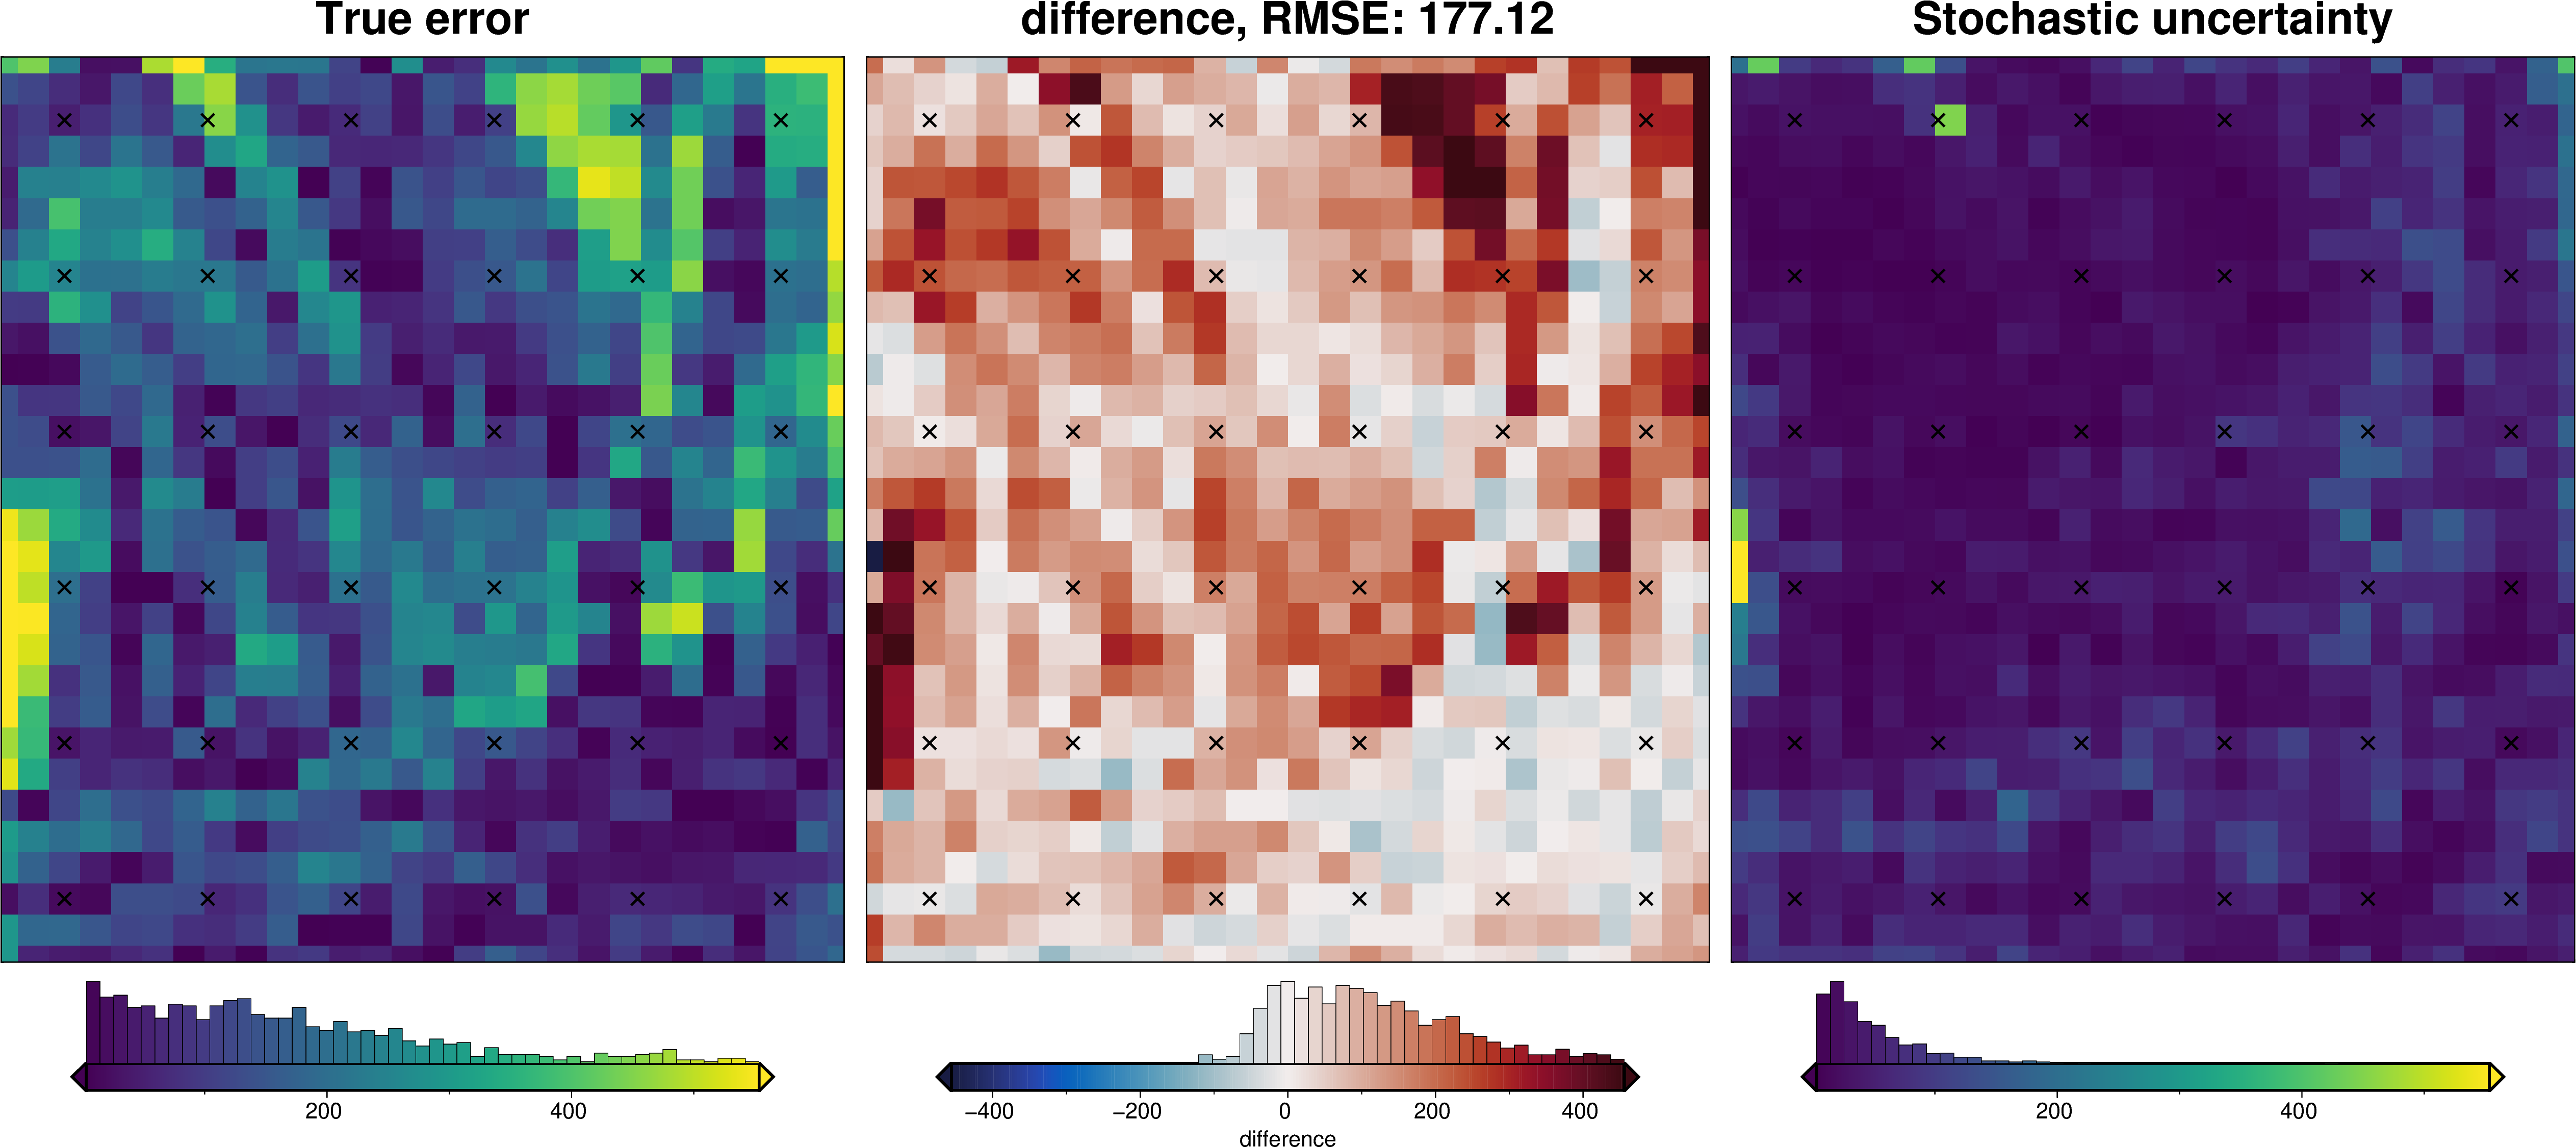

In [50]:
solver_dict = {
    "solver_damping": {
        "distribution": "normal",
        "loc": np.log10(best_damping),  # mean base 10 exponent
        "scale": stdev,  # standard deviation of base 10 exponent
        "log": True,
    },
}

fname = "../tmp/bishop_uncertainty_damping"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_damping_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=solver_dict,
    **uncert_kwargs,
)

uncert_plots(uncert_damping_results)

### Gravity component

INFO:invert4geom:No pickle files starting with '../tmp/bishop_uncertainty_grav' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../tmp/bishop_uncertainty_grav'



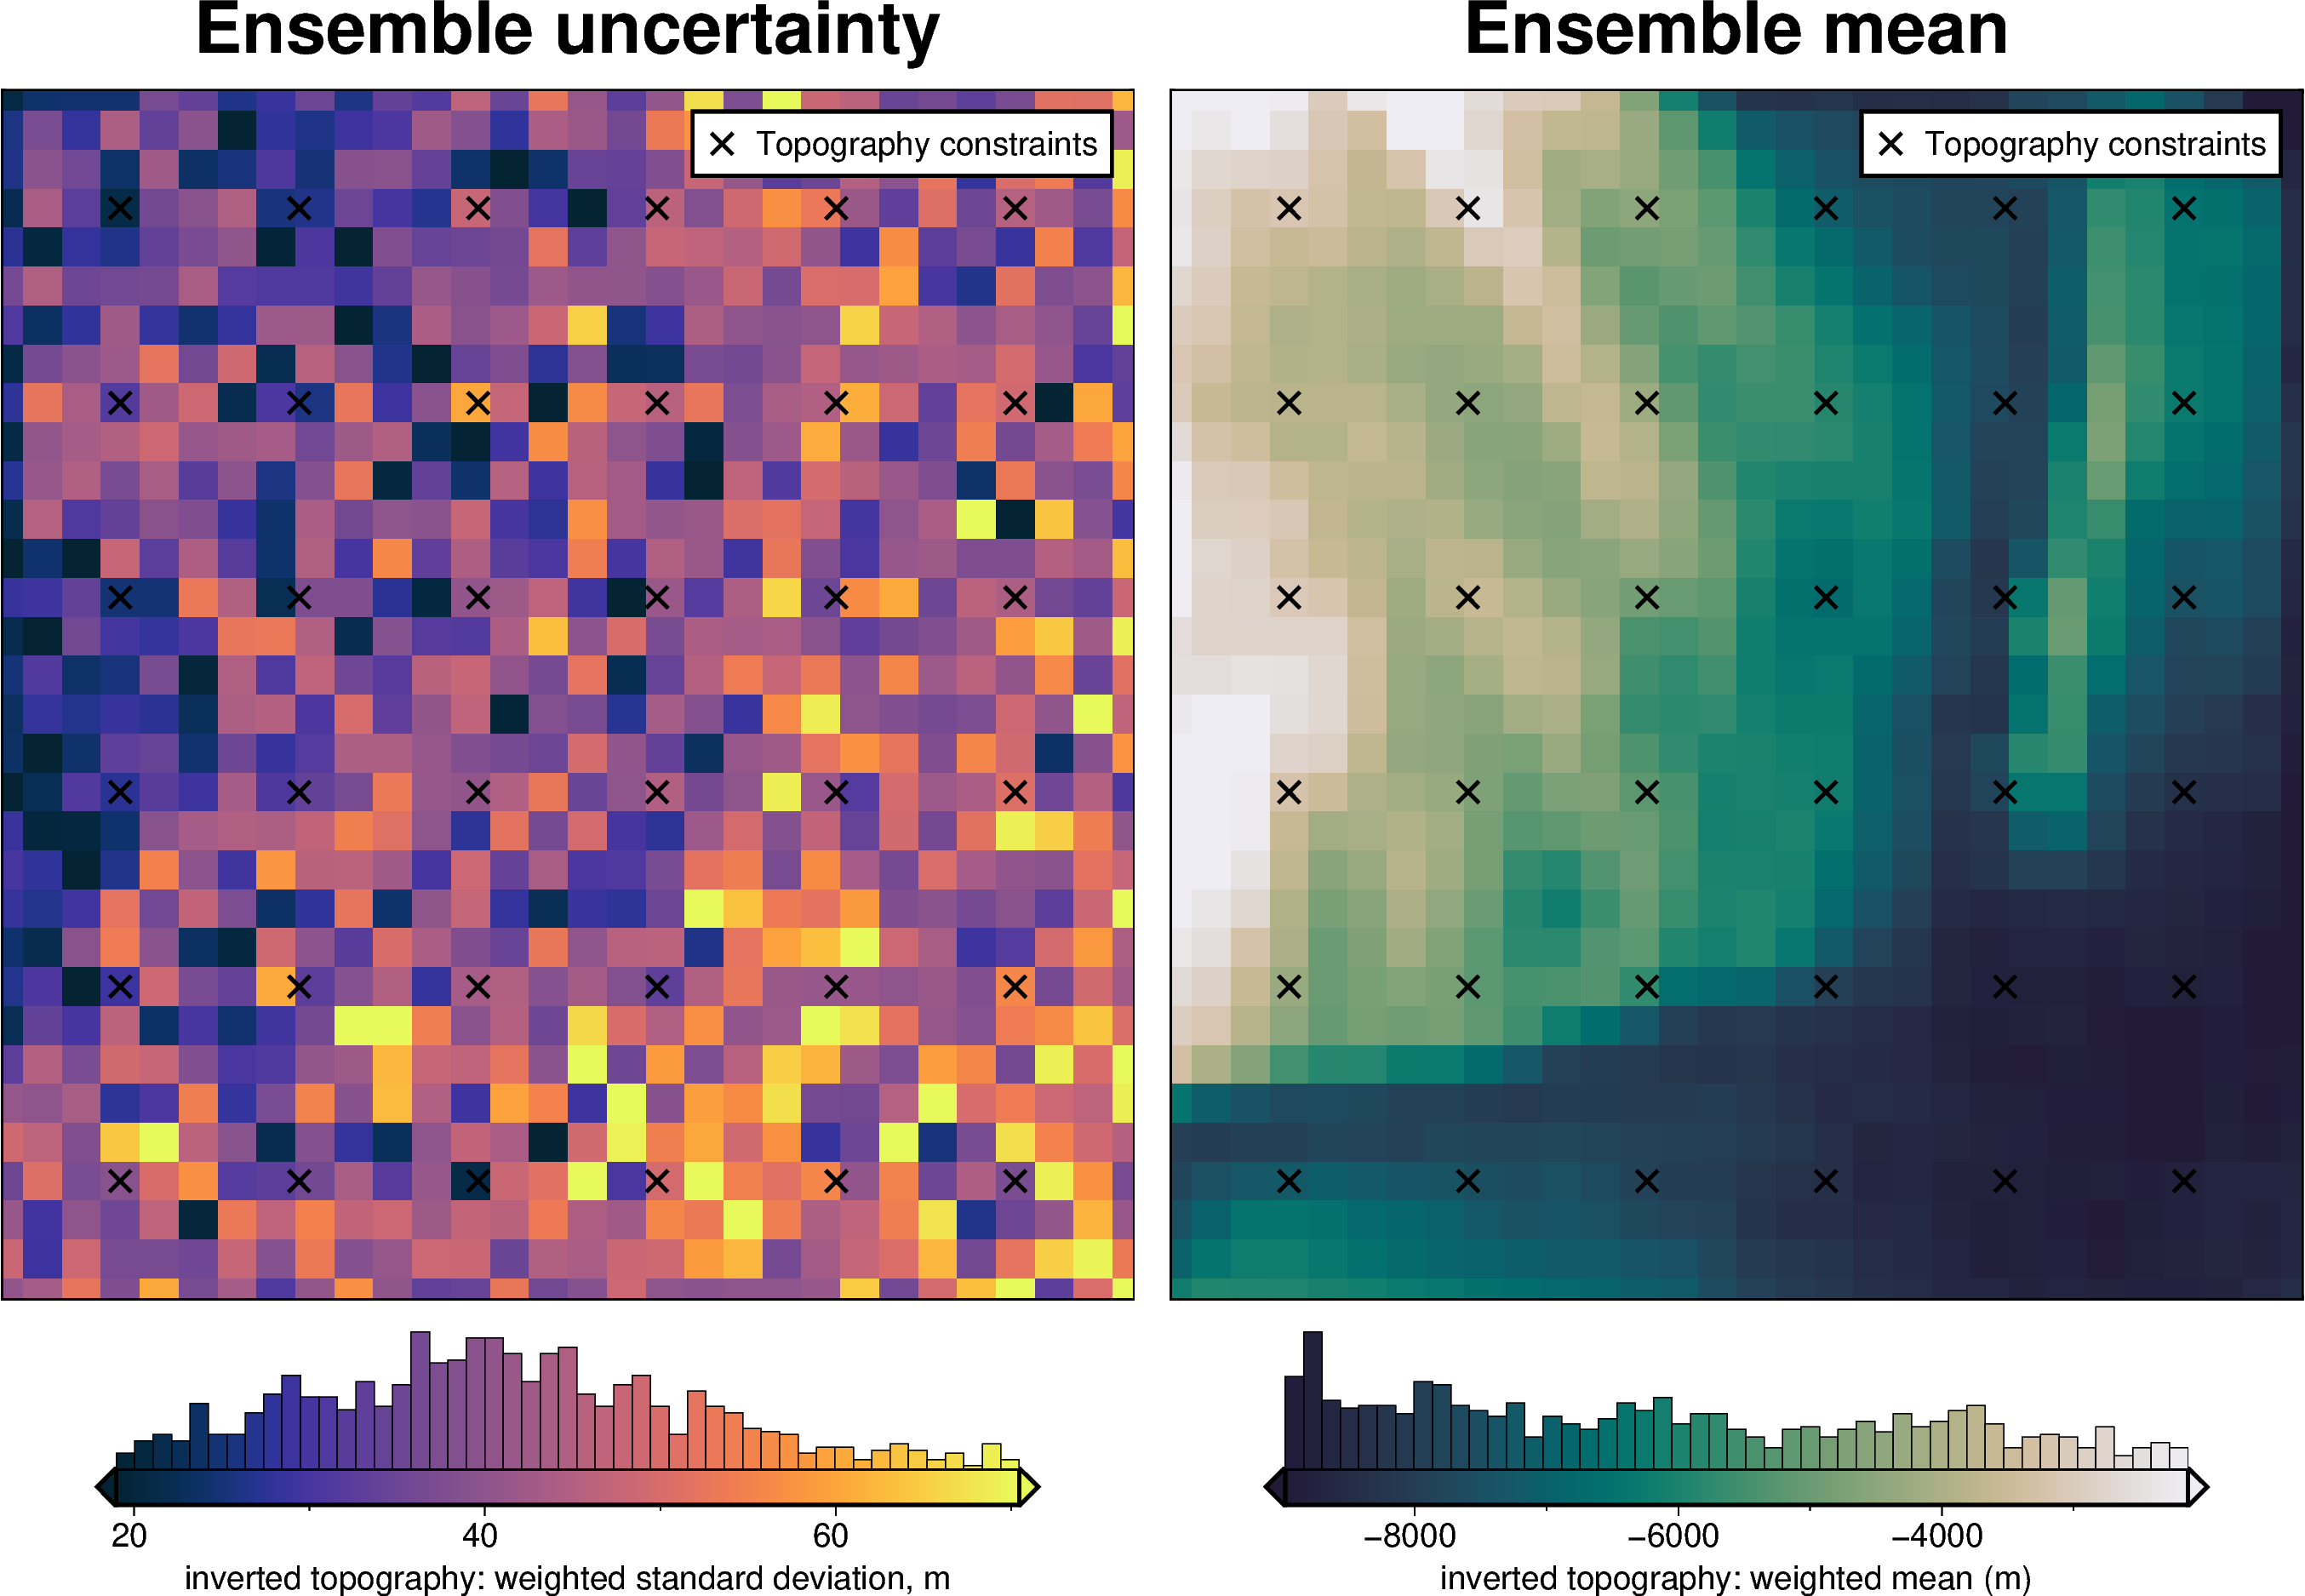

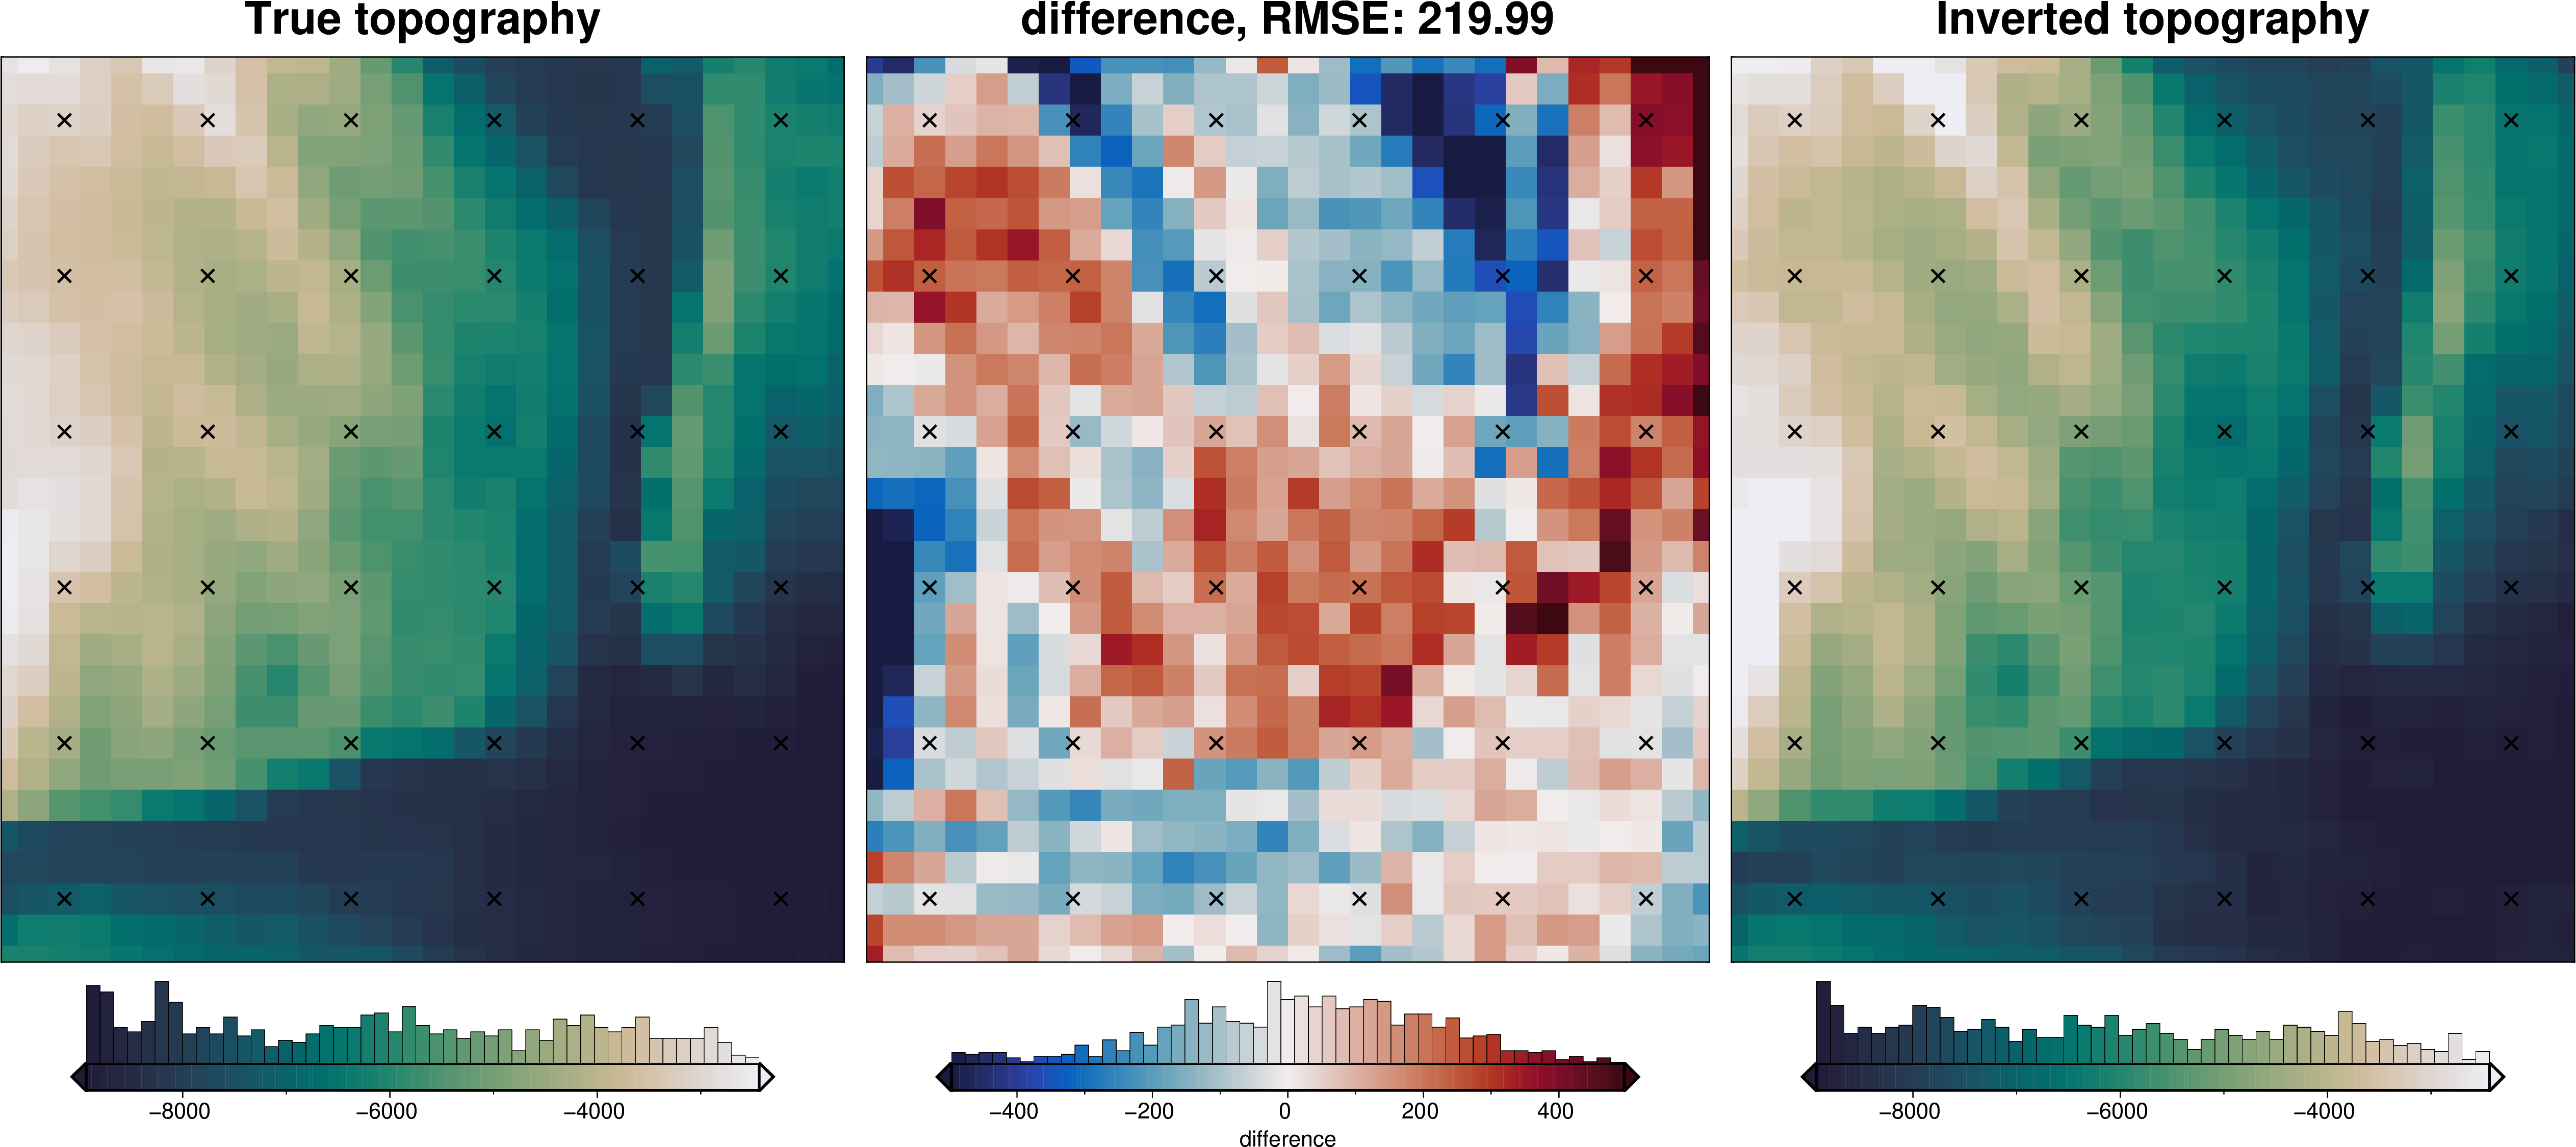

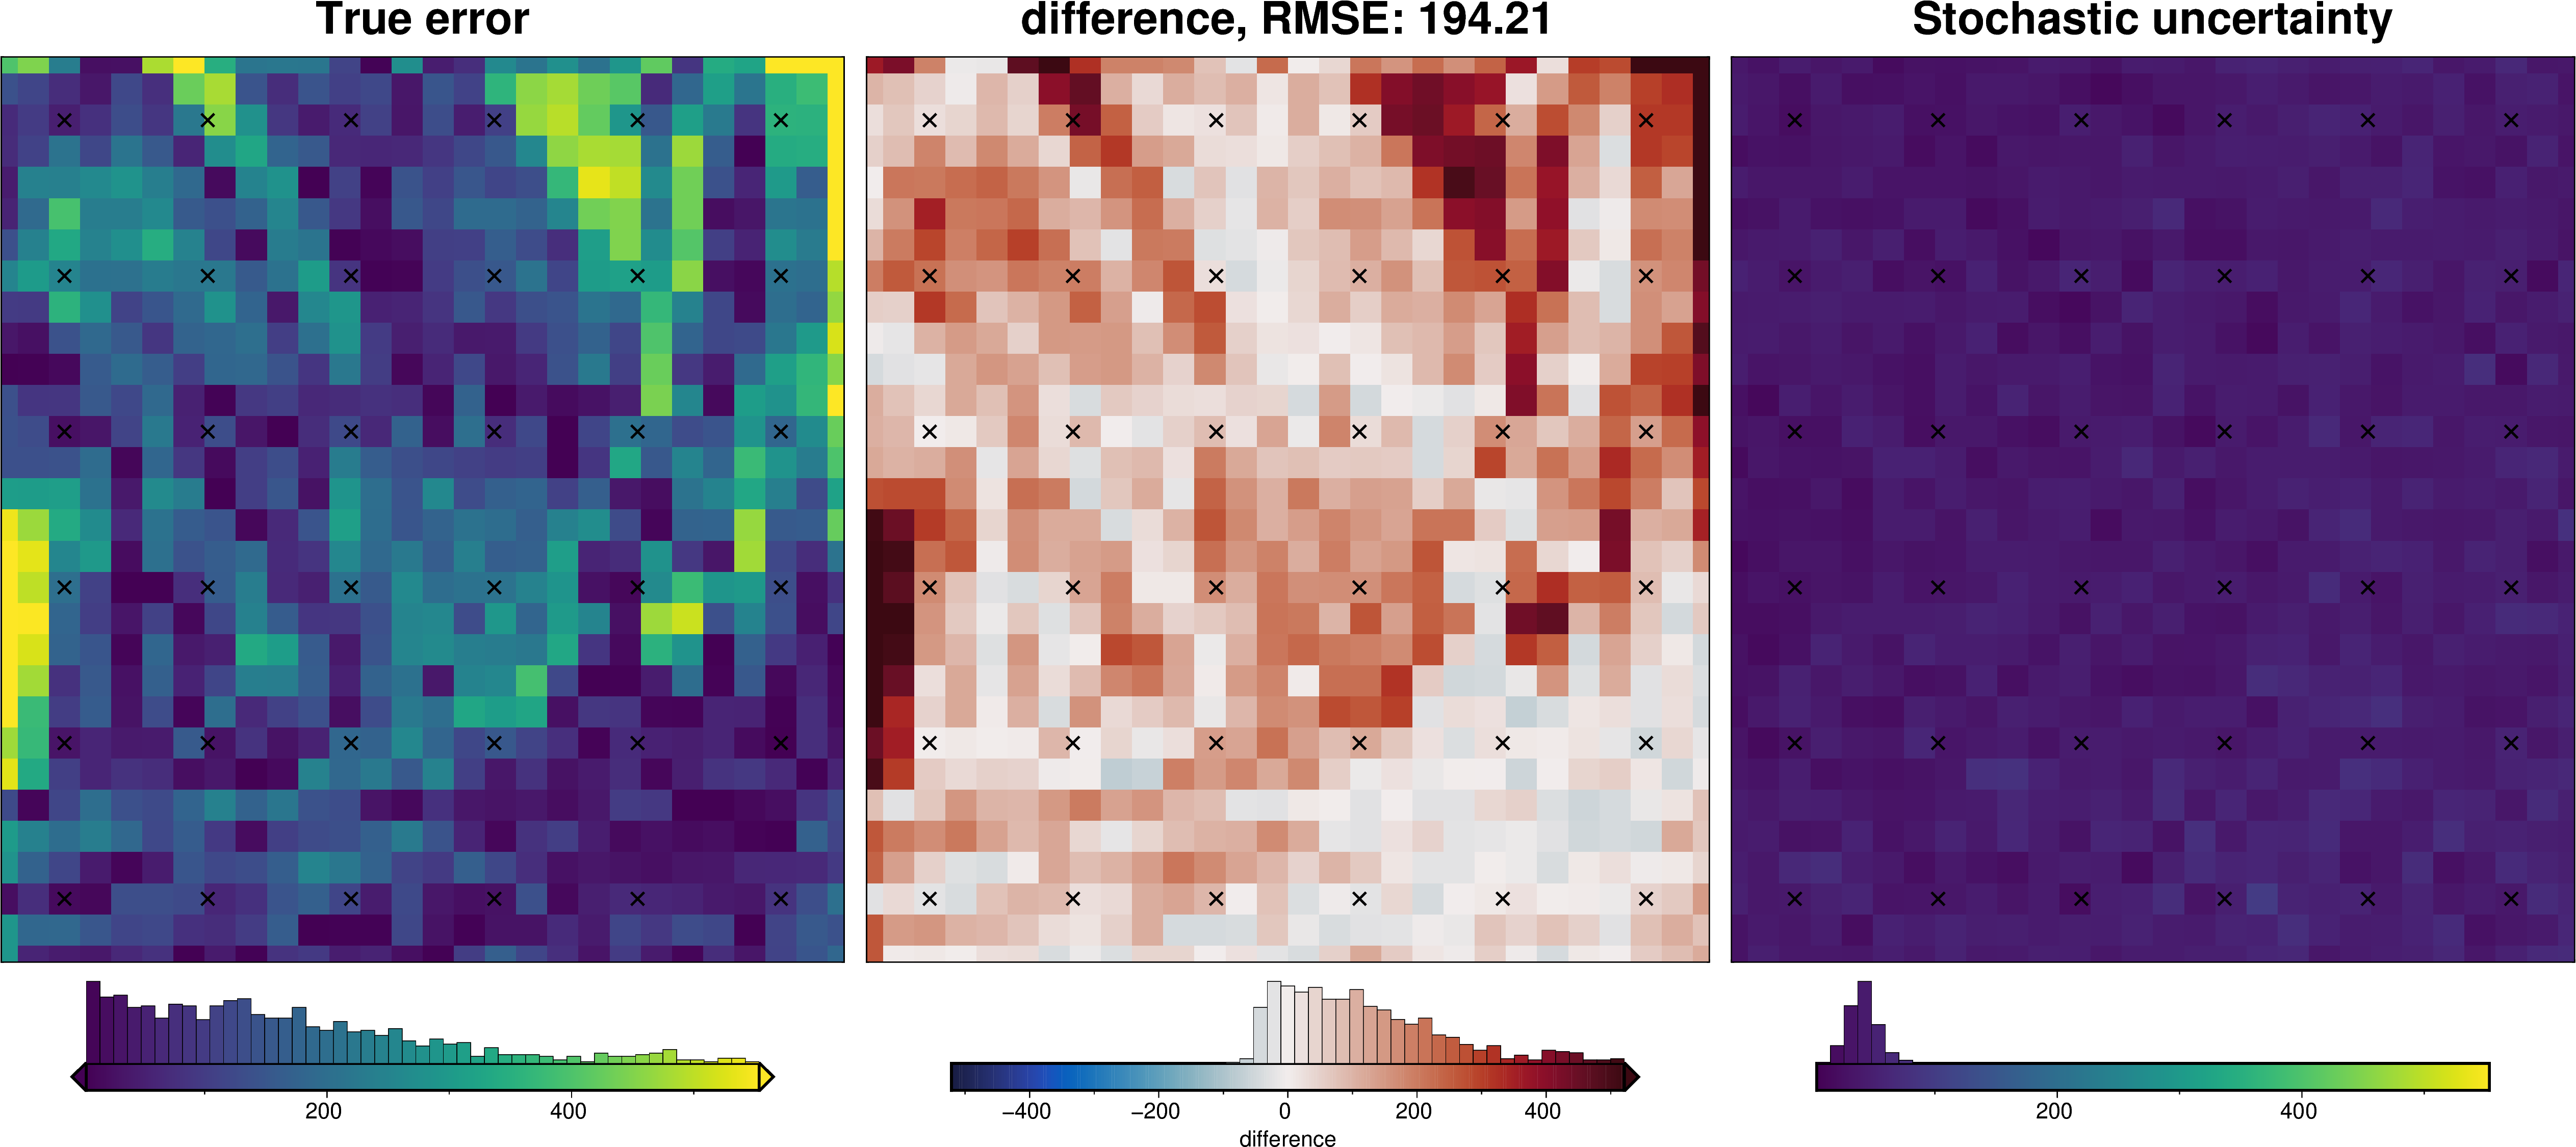

In [51]:
fname = "../tmp/bishop_uncertainty_grav"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_grav_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    sample_gravity=True,
    **uncert_kwargs,
)

uncert_plots(uncert_grav_results)

### Constraints component

INFO:invert4geom:No pickle files starting with '../tmp/bishop_uncertainty_constraints' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../tmp/bishop_uncertainty_constraints'



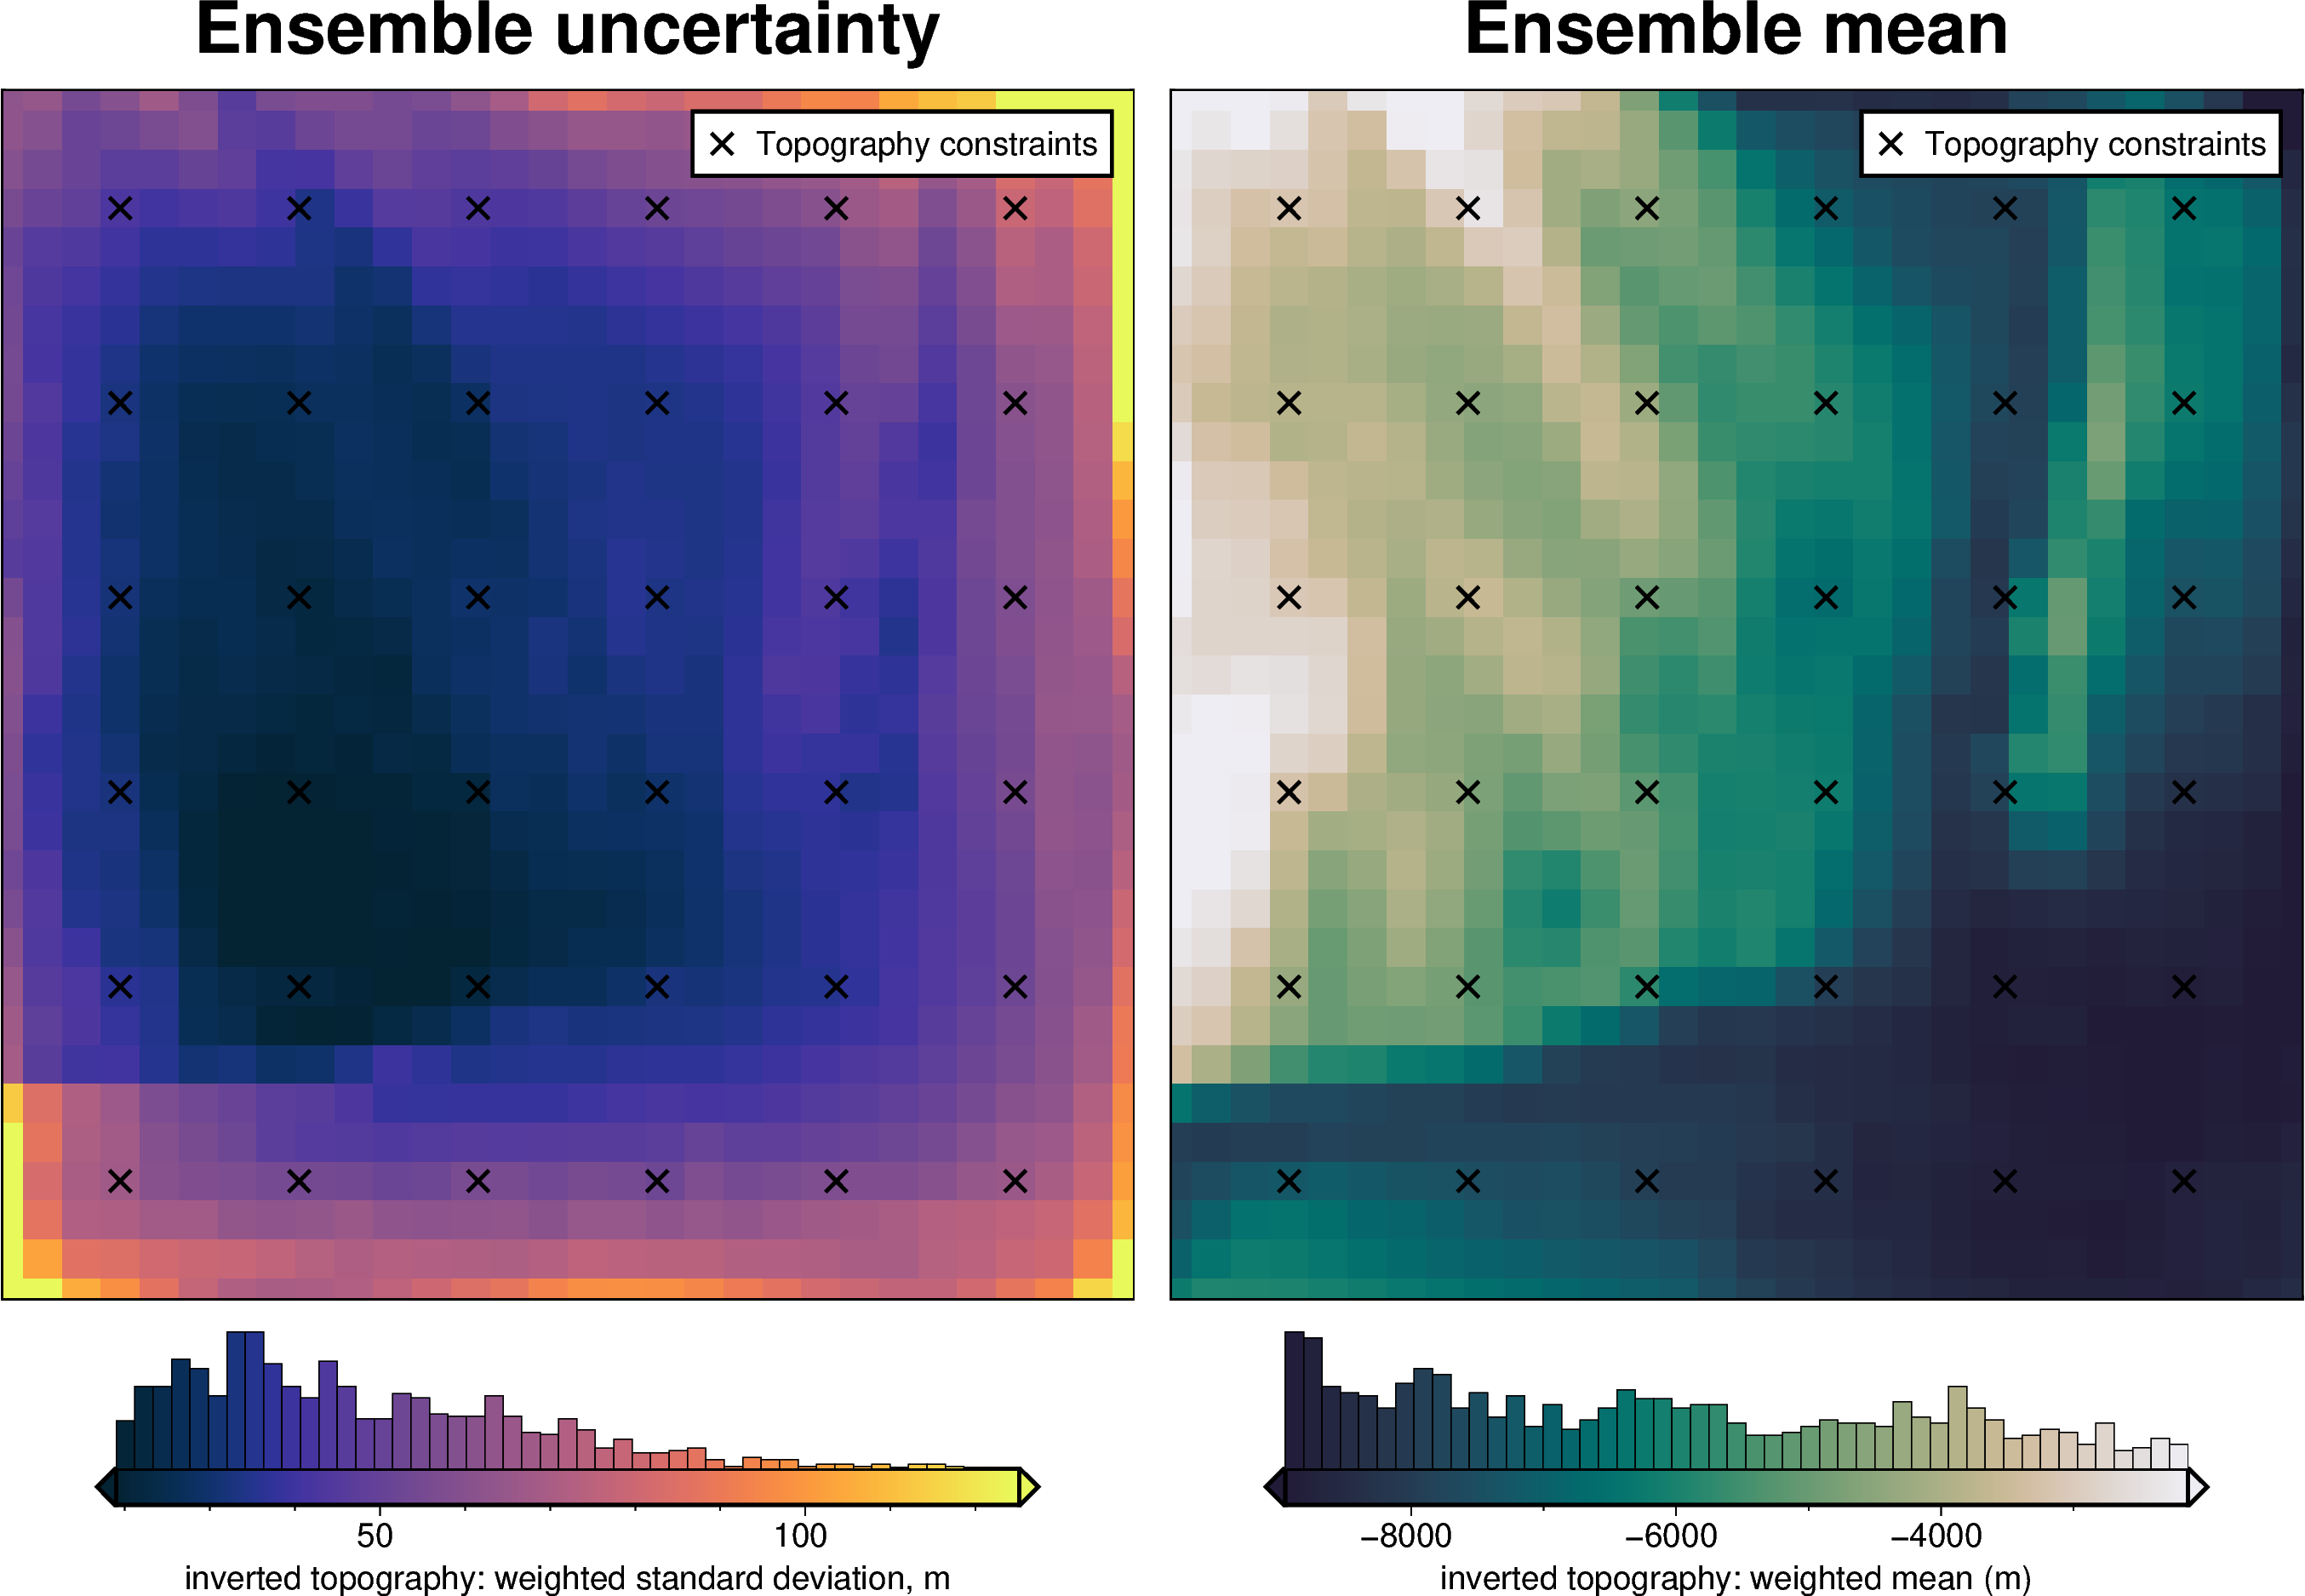

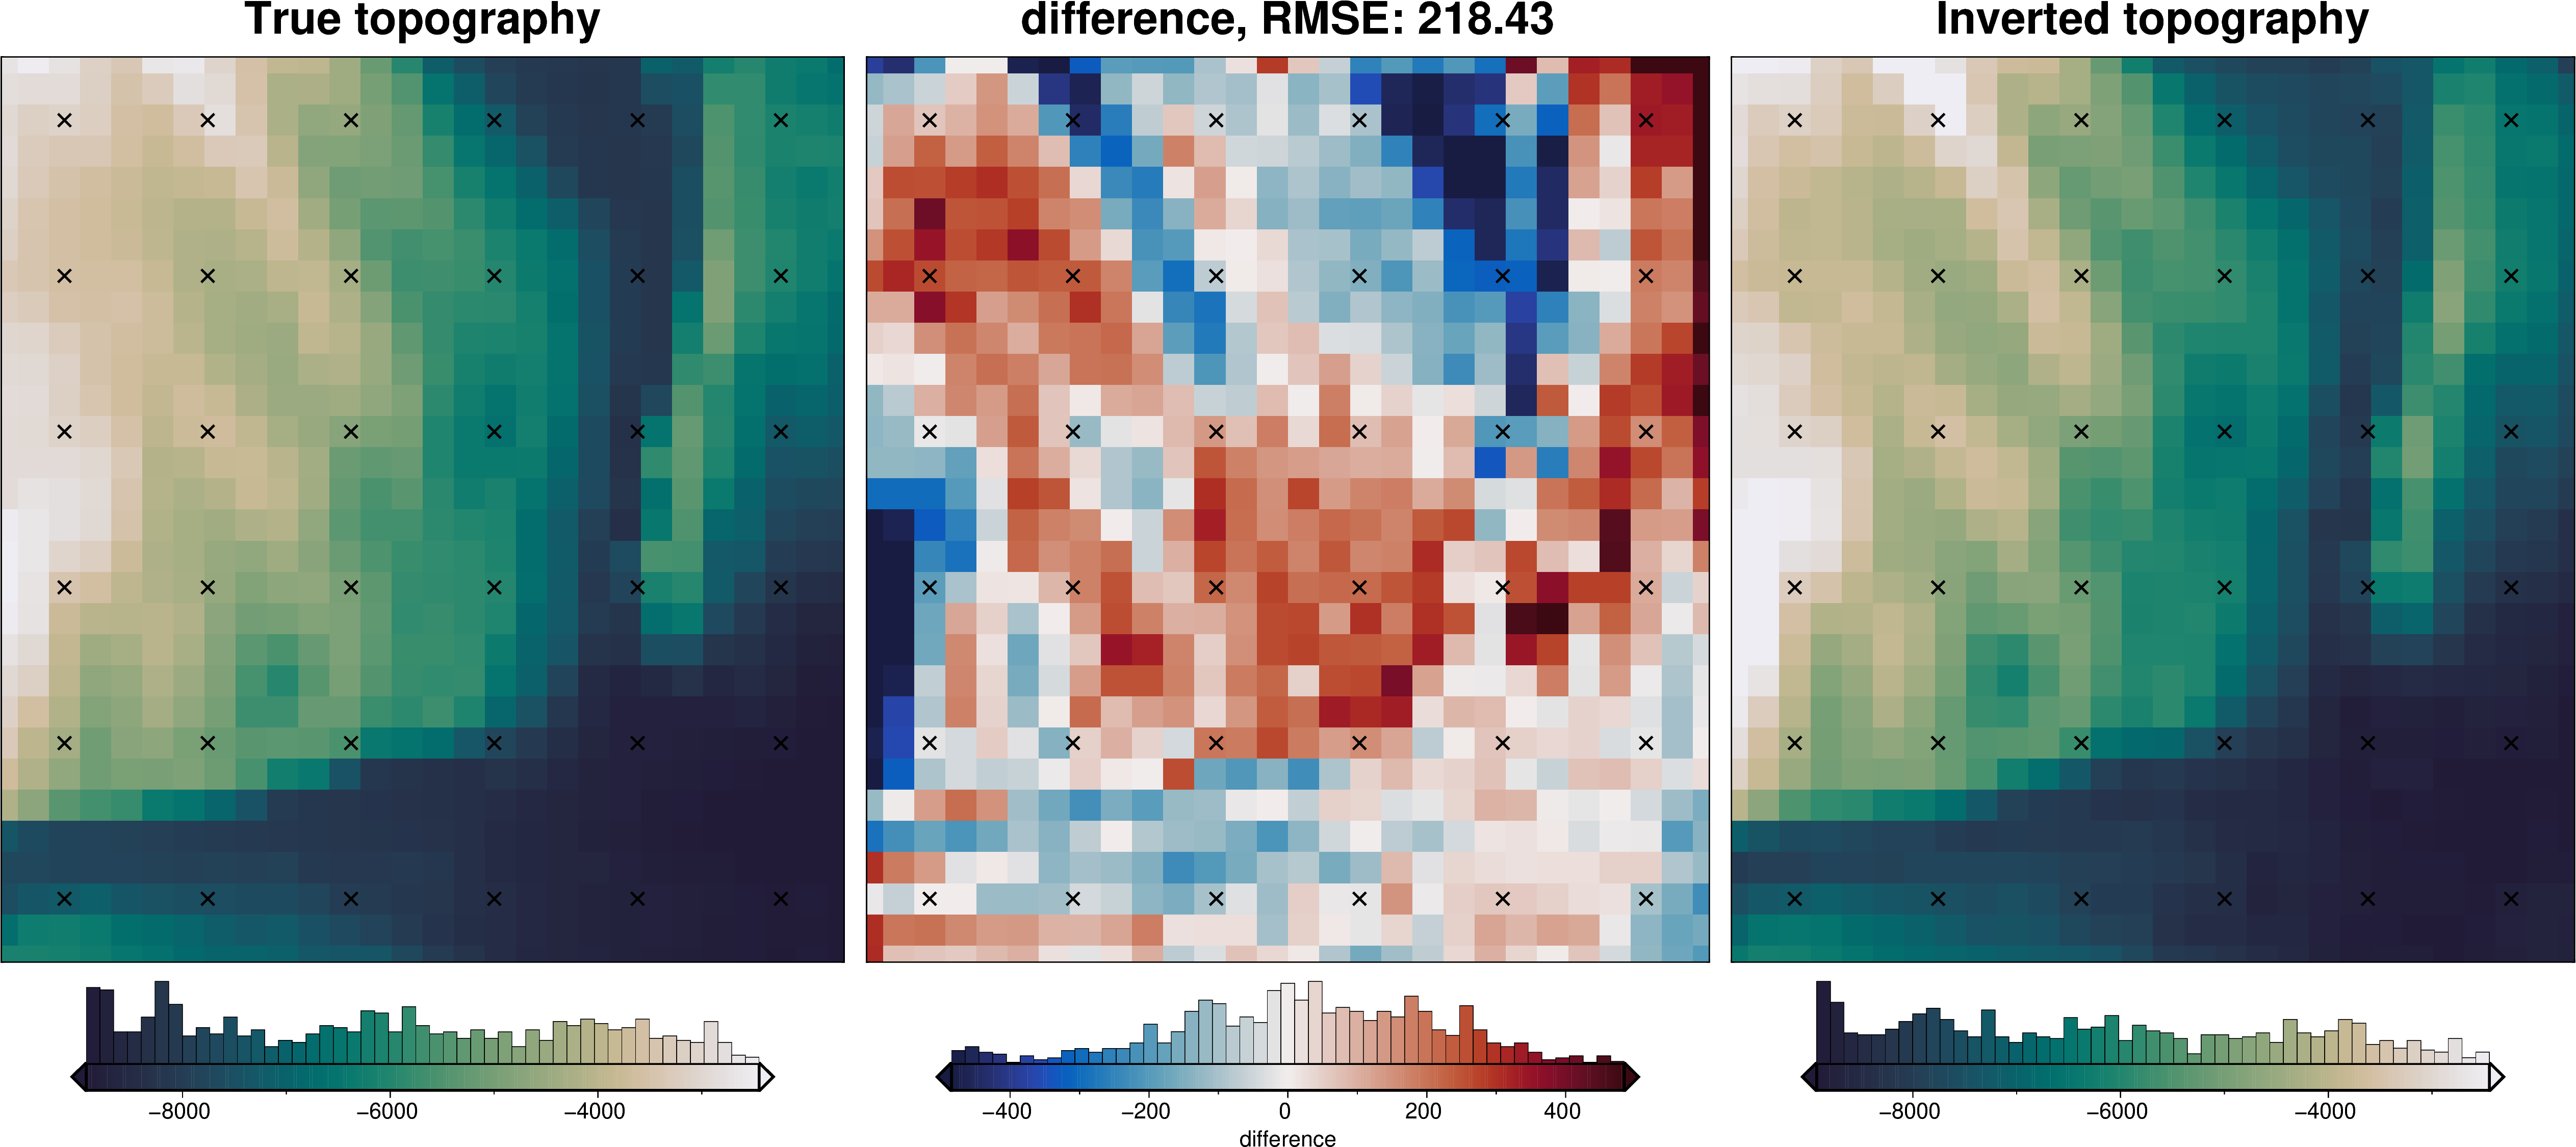

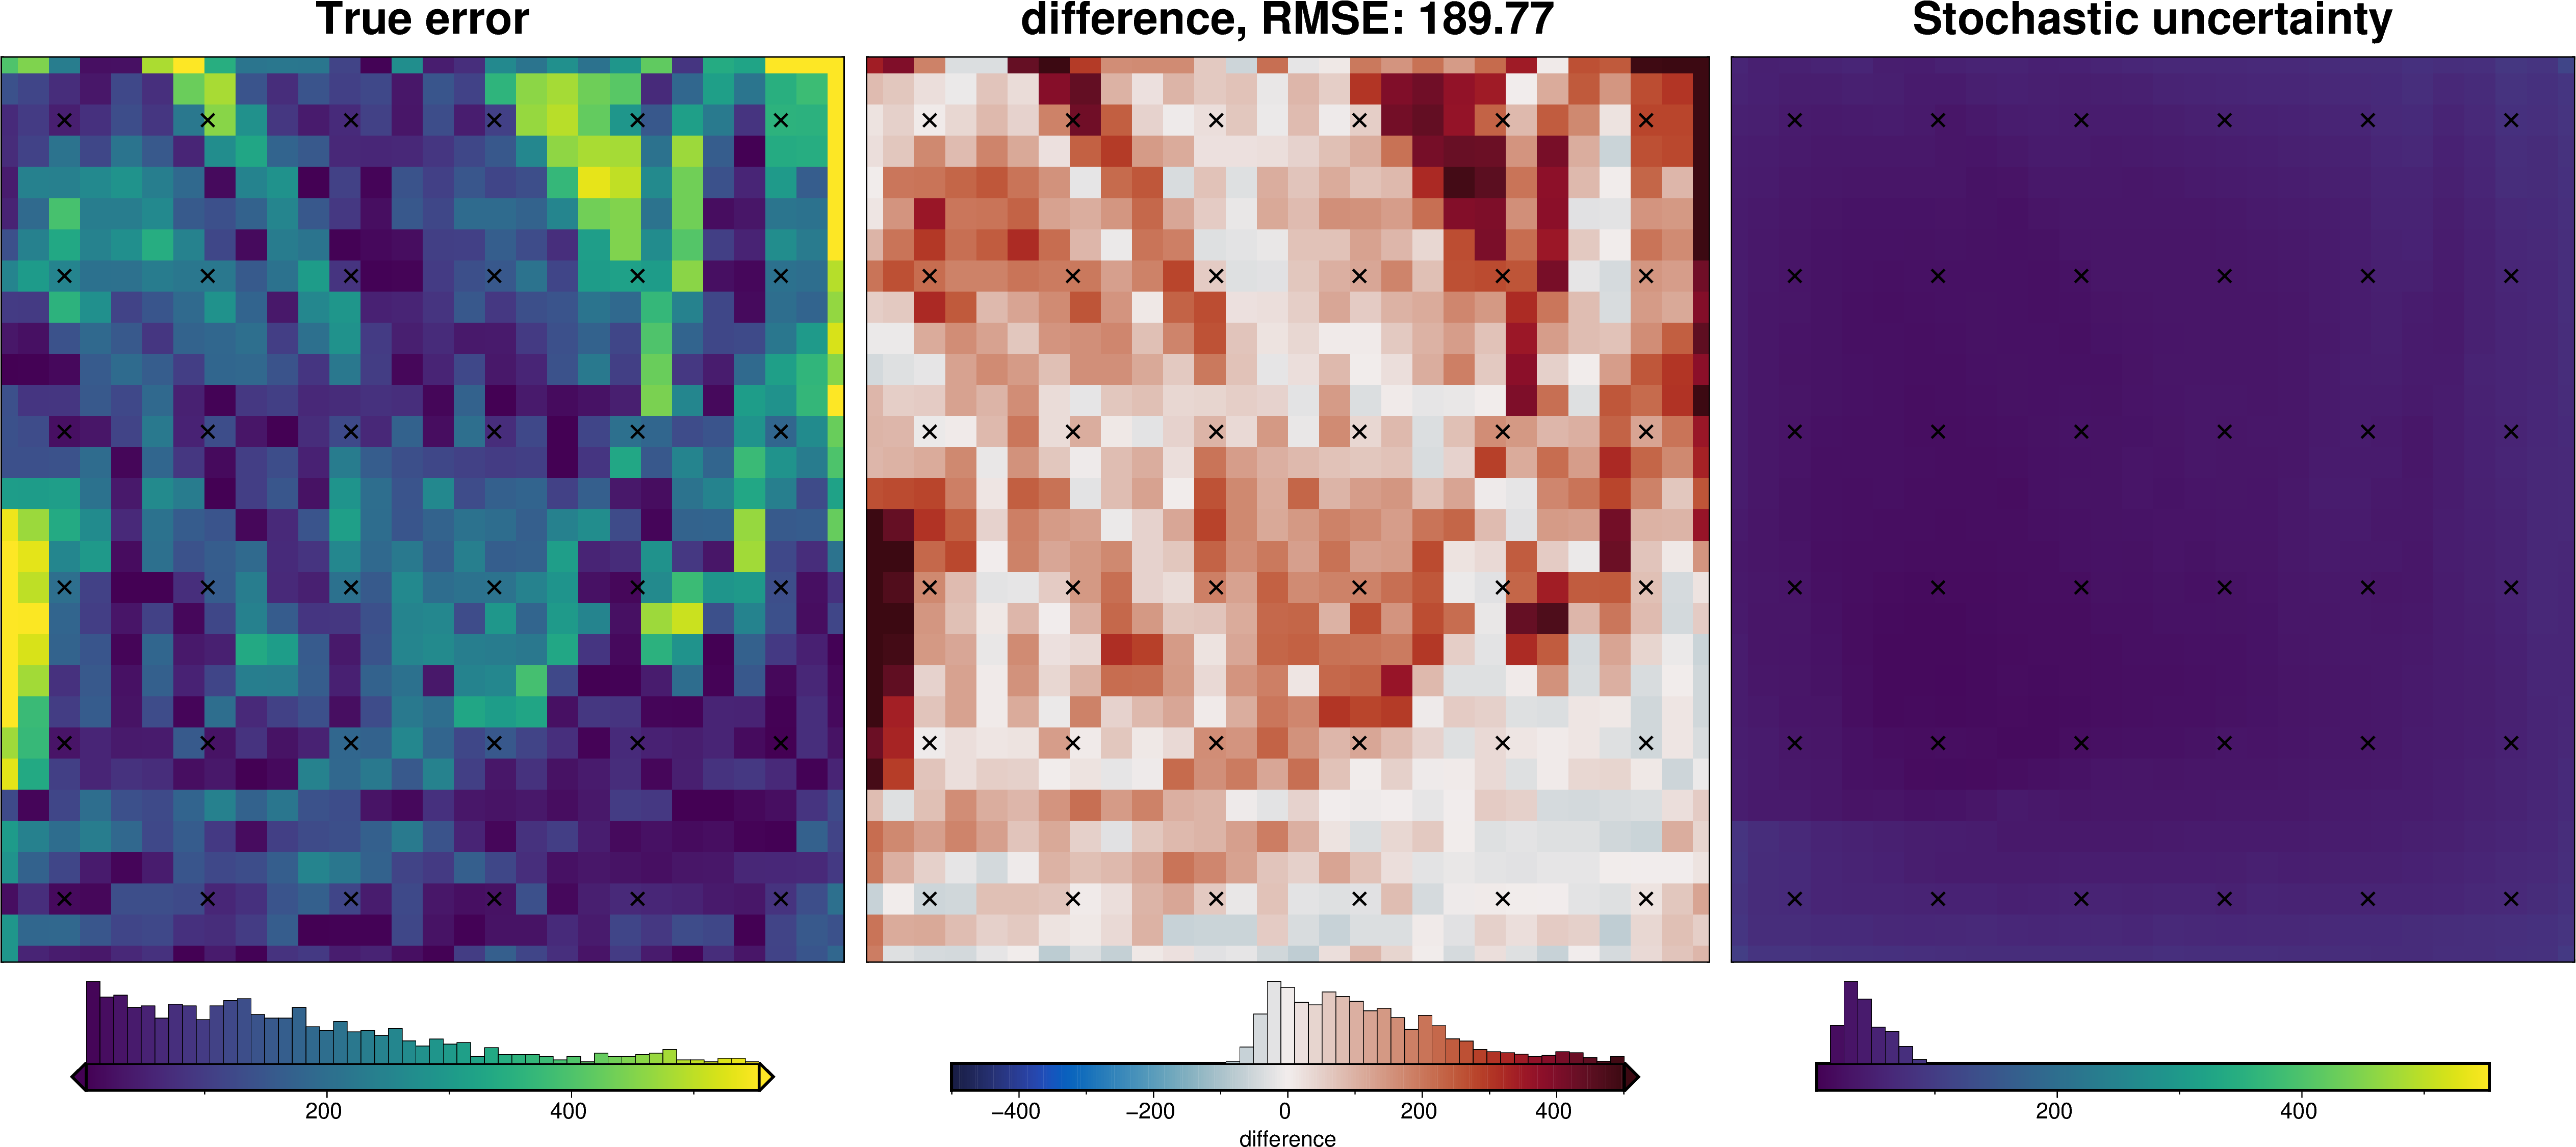

In [52]:
fname = "../tmp/bishop_uncertainty_constraints"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_constraints_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    sample_constraints=True,
    constraints_df=constraint_points,
    starting_topography_kwargs=starting_topography_kwargs,
    **uncert_kwargs,
)

uncert_plots(uncert_constraints_results)

### Regional gravity component

INFO:invert4geom:Sampled 'depth' parameter values; mean: 974124.3677063866, min: -2230459.630940934, max: 4178708.3663537065
INFO:invert4geom:Sampled 'damping' parameter values; mean: 0.0691067267805829, min: 0.004082833742144754, max: 0.2576093935897783
INFO:invert4geom:No pickle files starting with '../tmp/bishop_uncertainty_regional' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../tmp/bishop_uncertainty_regional'



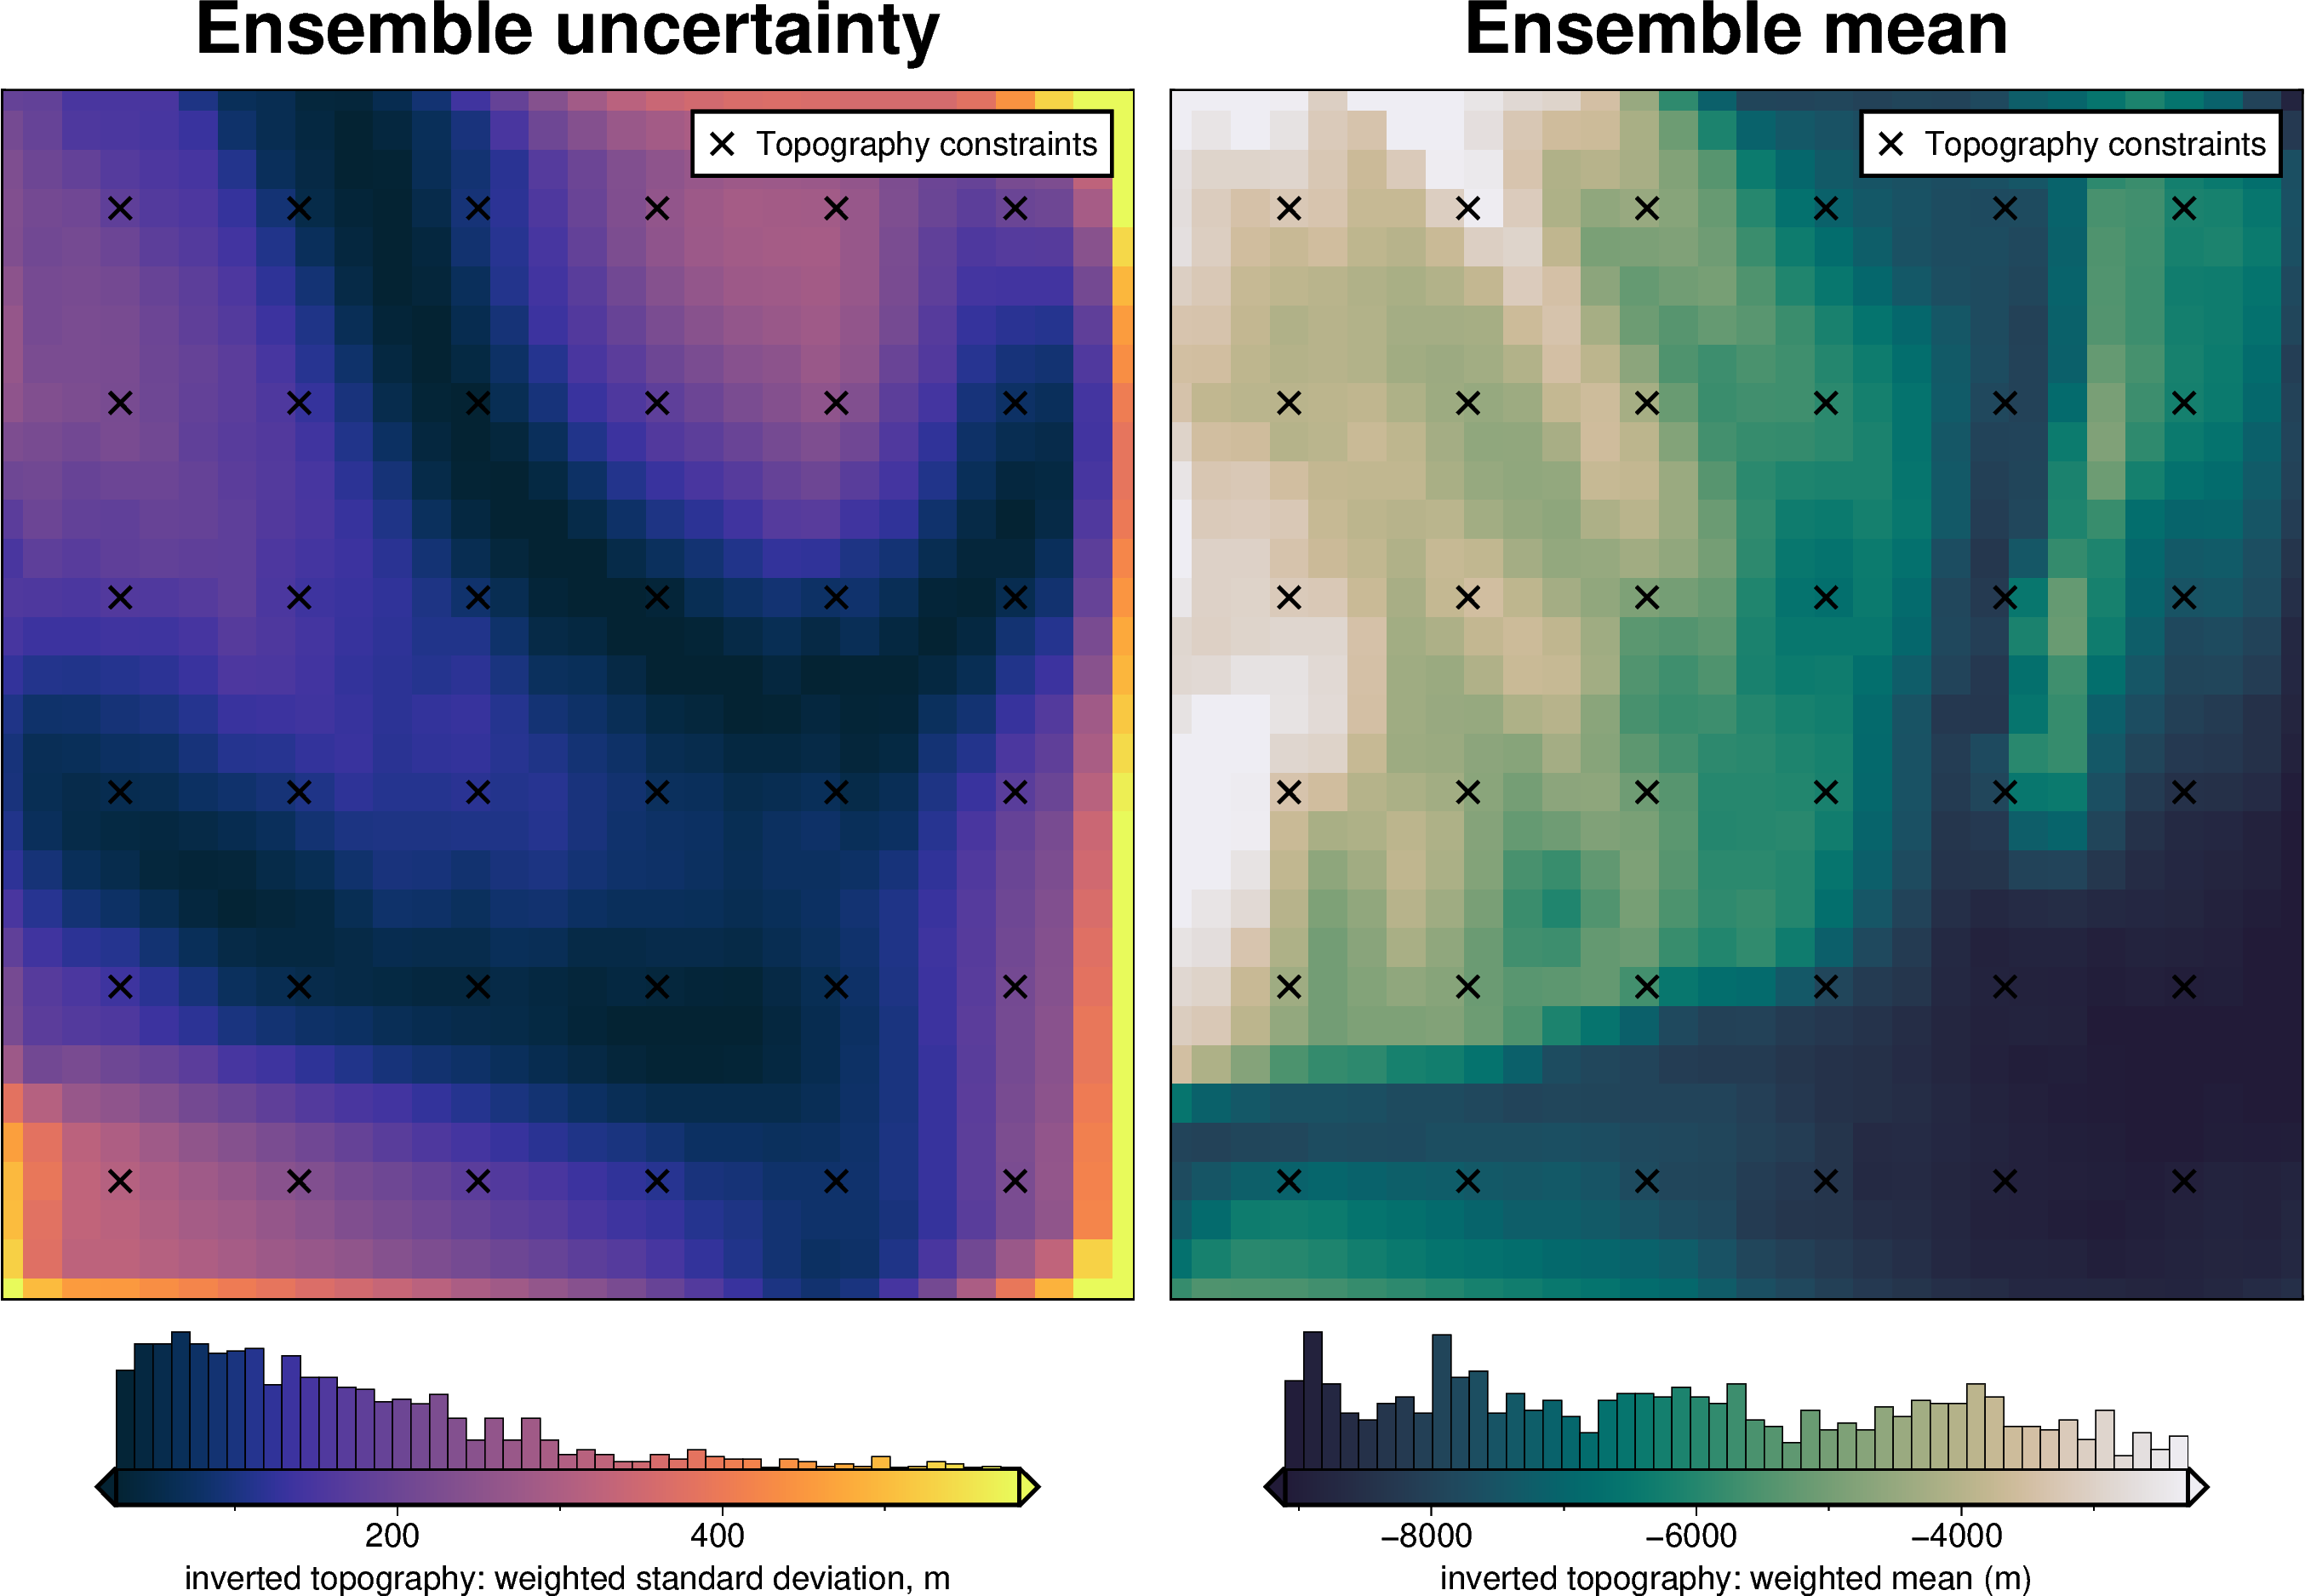

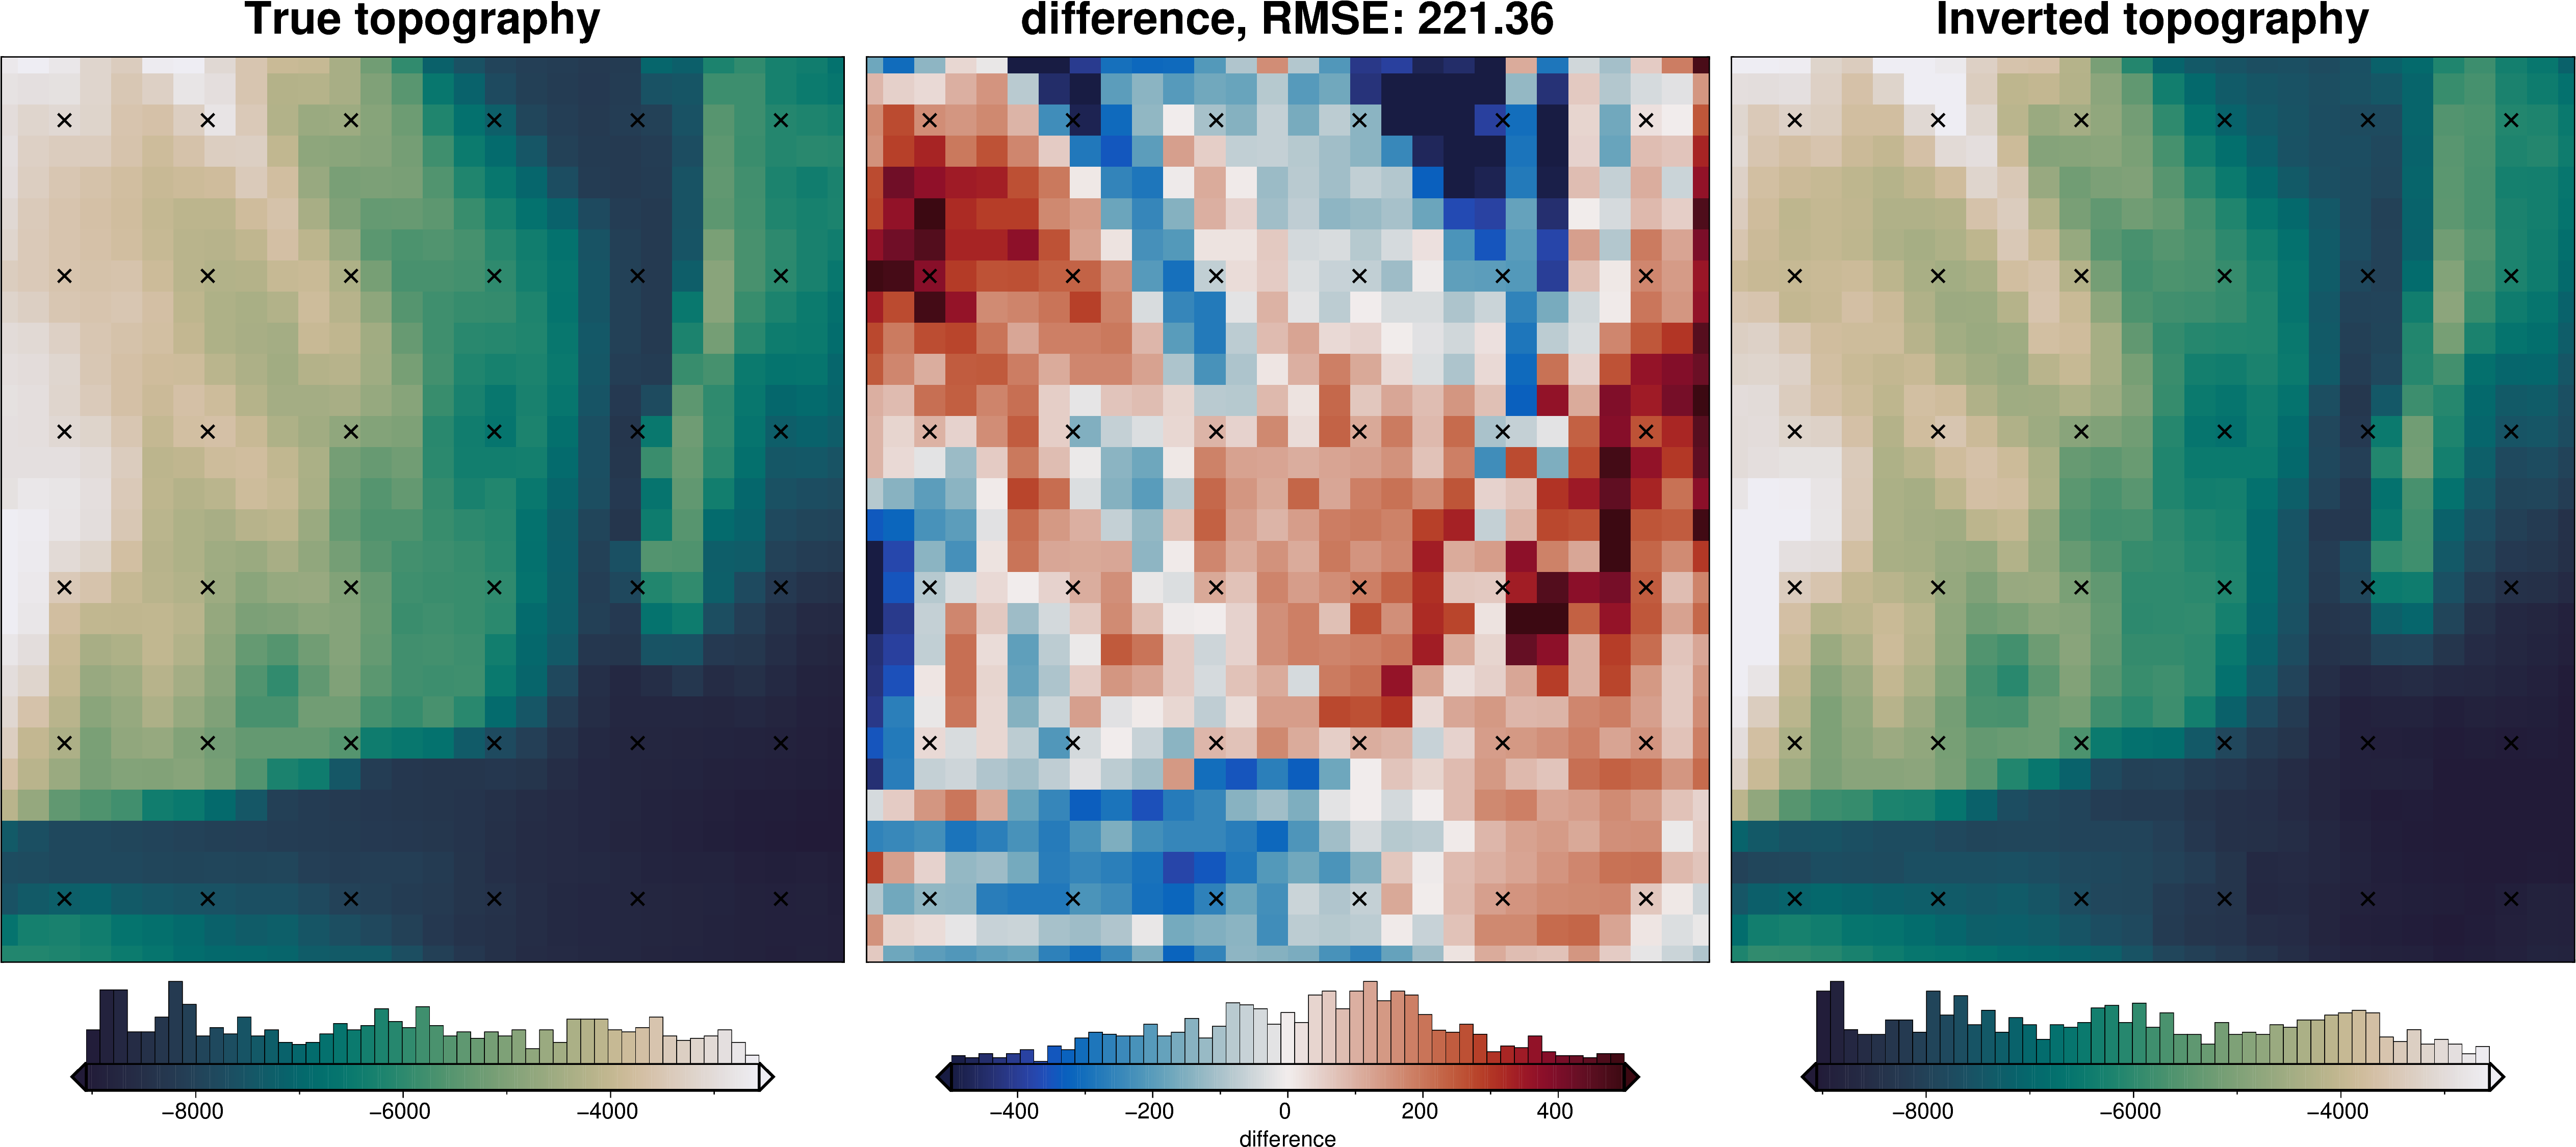

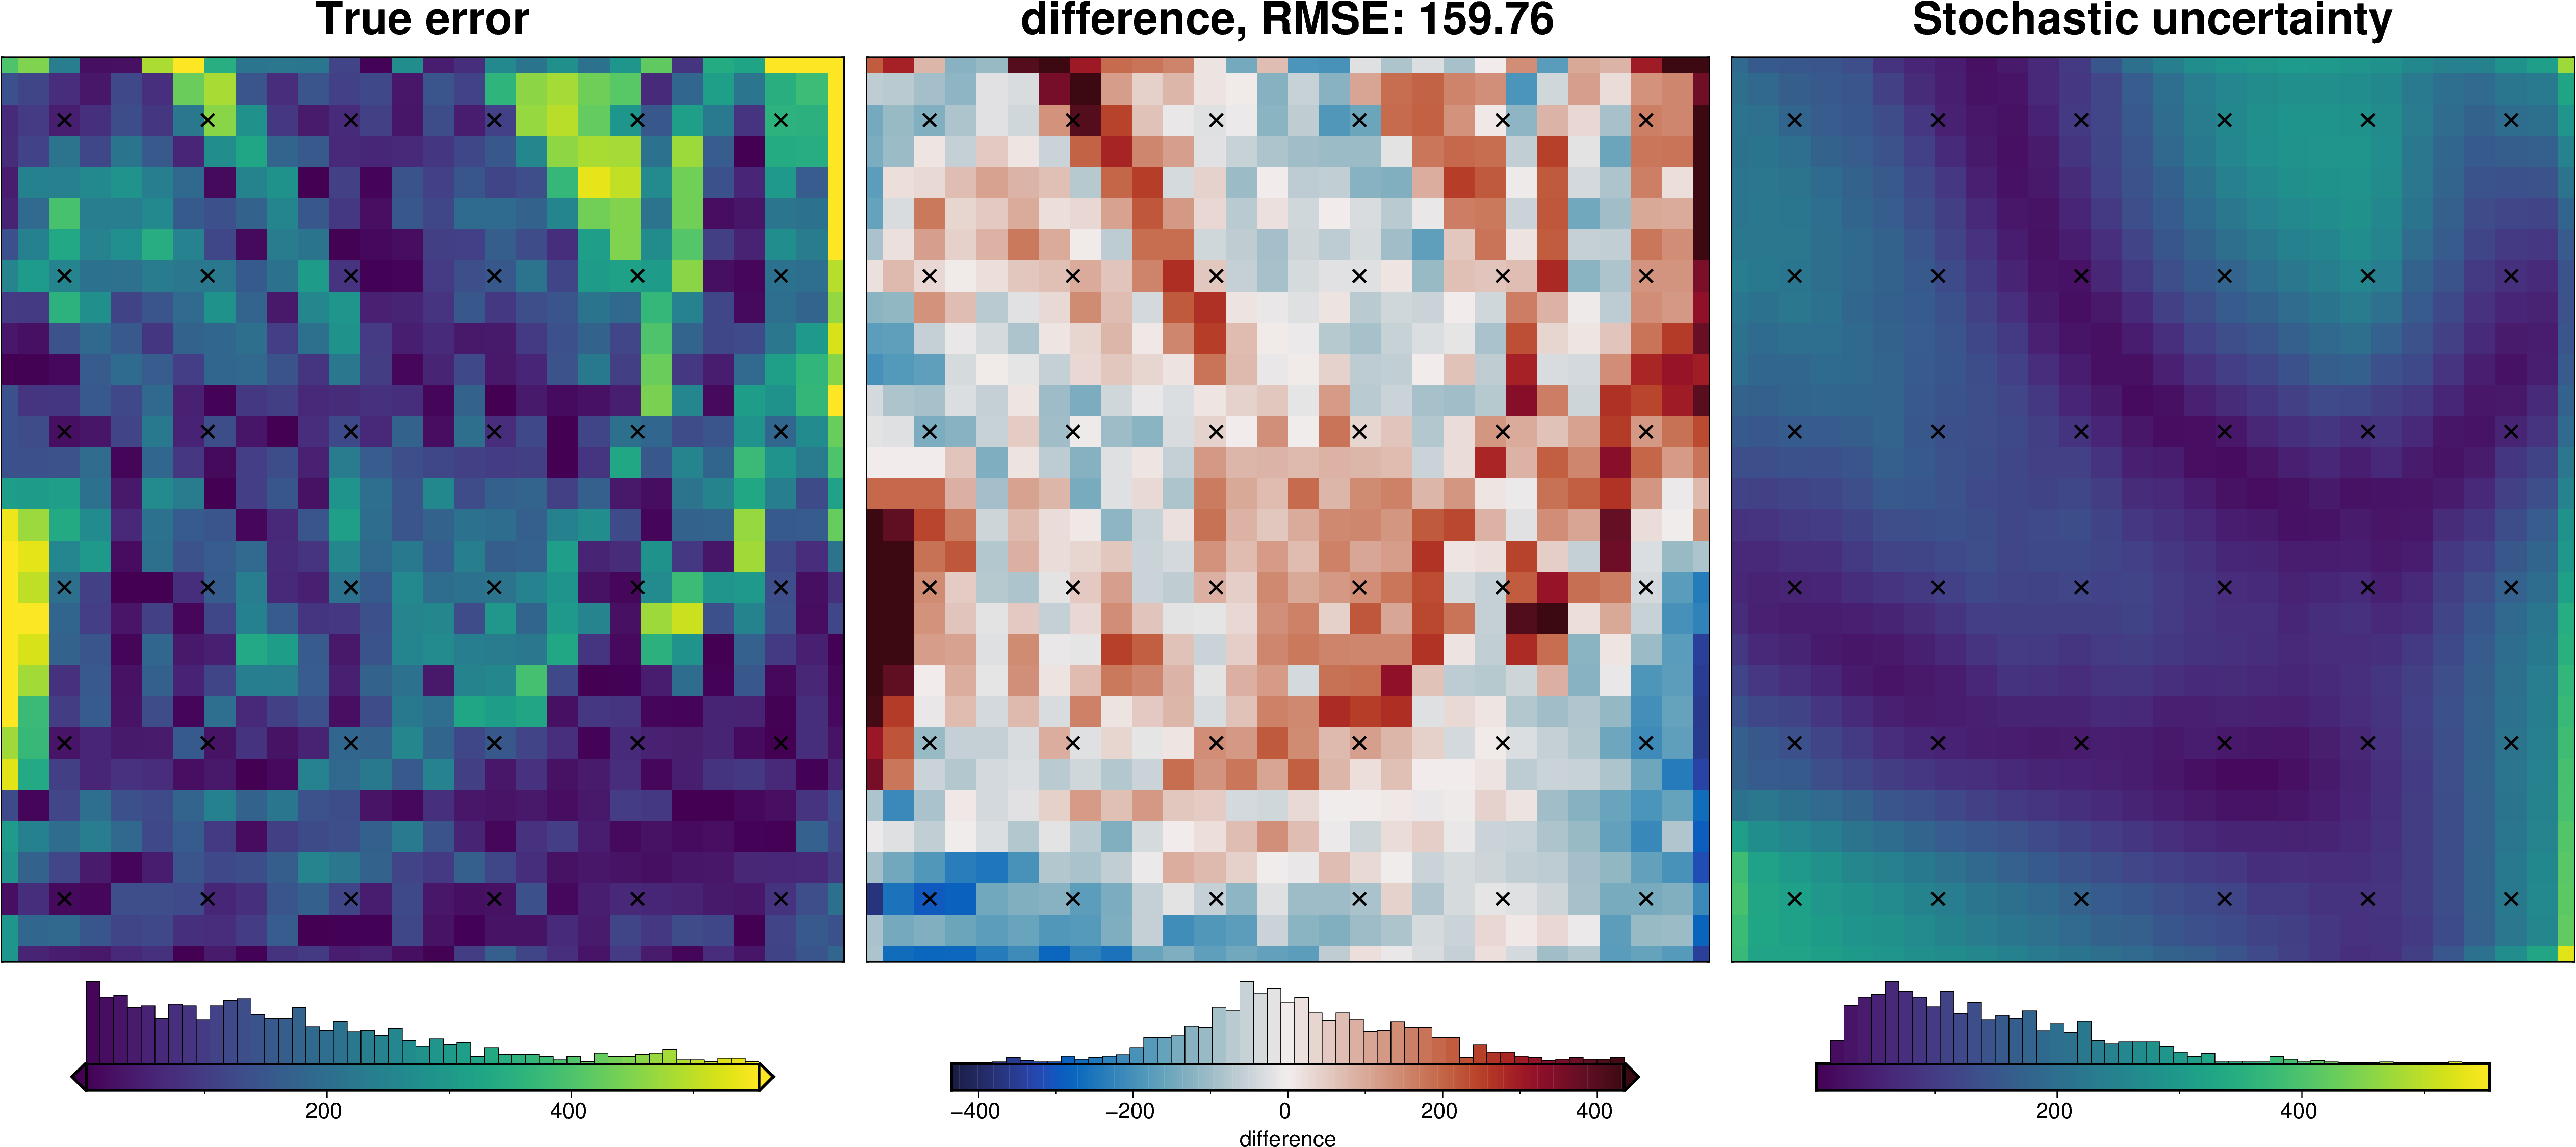

In [53]:
fname = "../tmp/bishop_uncertainty_regional"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_regional_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    **uncert_kwargs,
)

uncert_plots(uncert_regional_results)

### Total Uncertainty

INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 281.00000000000006, min: -30.779080004182674, max: 592.779080004183
INFO:invert4geom:Sampled 'zref' parameter values; mean: -6290.718052642159, min: -8815.095815481256, max: -3766.3402898030595
INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.00763617768106518, min: 0.0006620445686347722, max: 0.03494041494166497
INFO:invert4geom:Sampled 'depth' parameter values; mean: 974124.3677063871, min: -2844372.986628355, max: 4792621.722041131
INFO:invert4geom:Sampled 'damping' parameter values; mean: 0.06956522891938234, min: 0.003638829402930621, max: 0.28904249360926937
INFO:invert4geom:No pickle files starting with '../tmp/bishop_uncertainty_full' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: '../tmp/bishop_uncertainty_full'



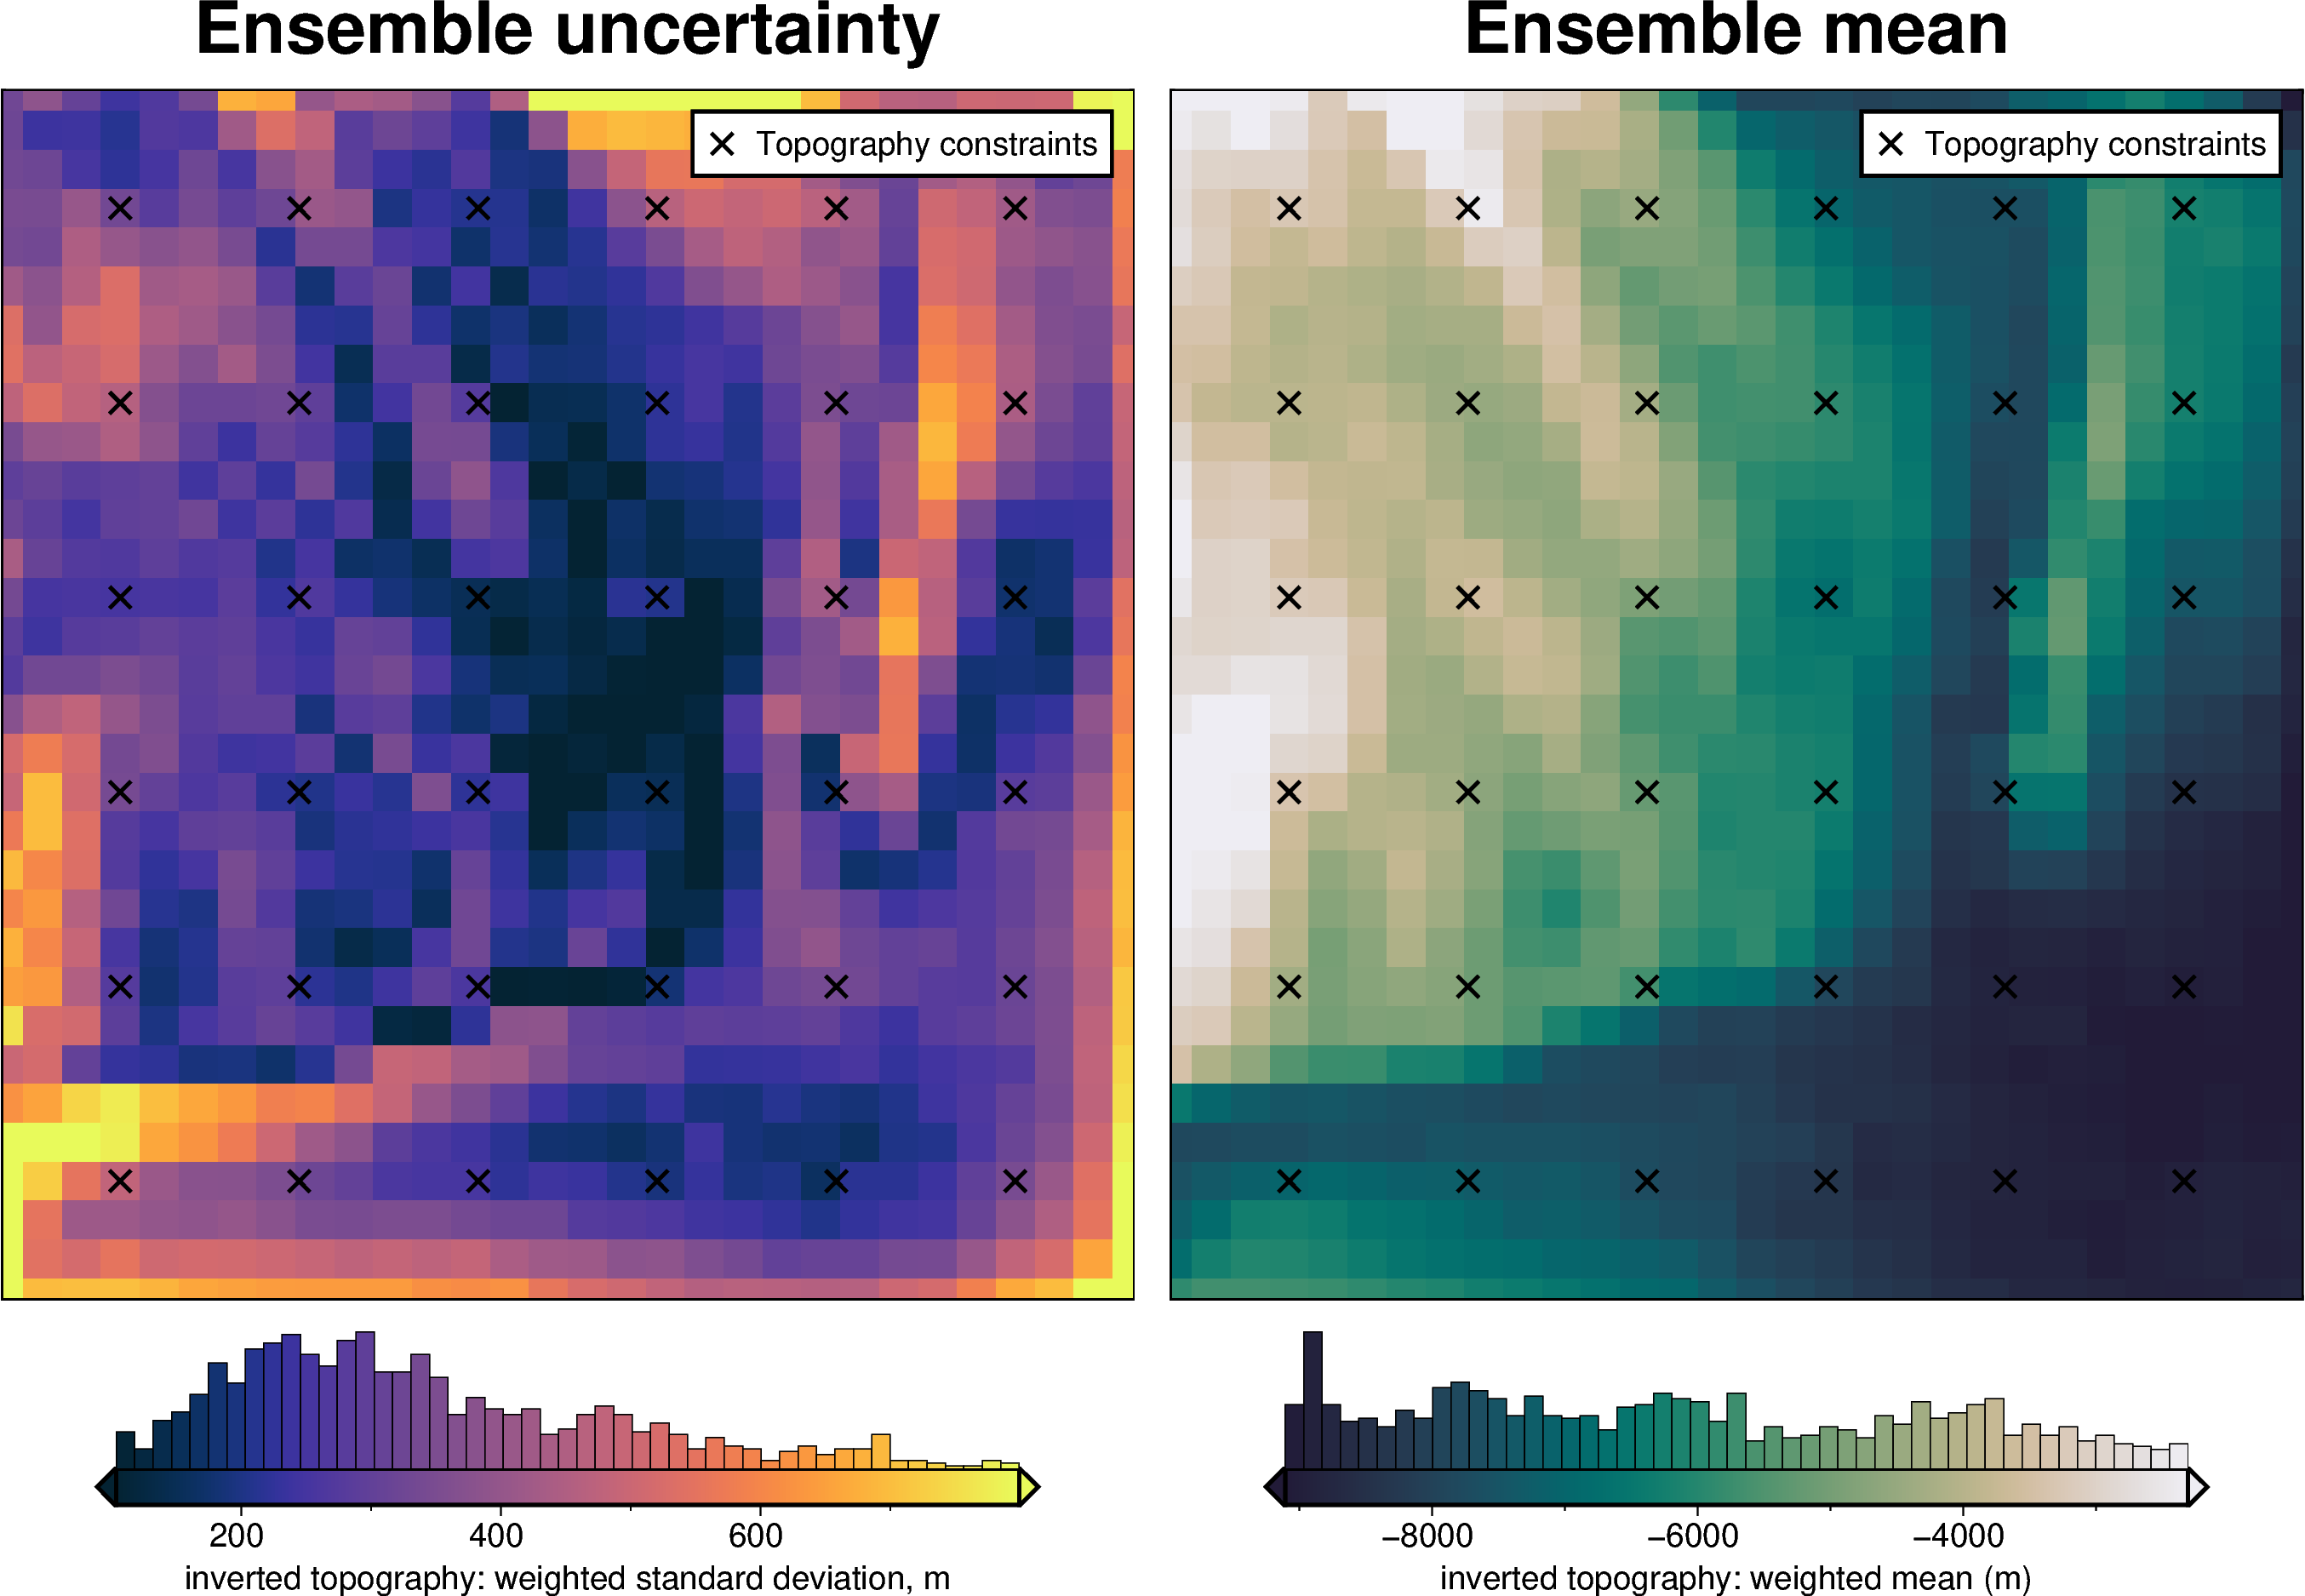

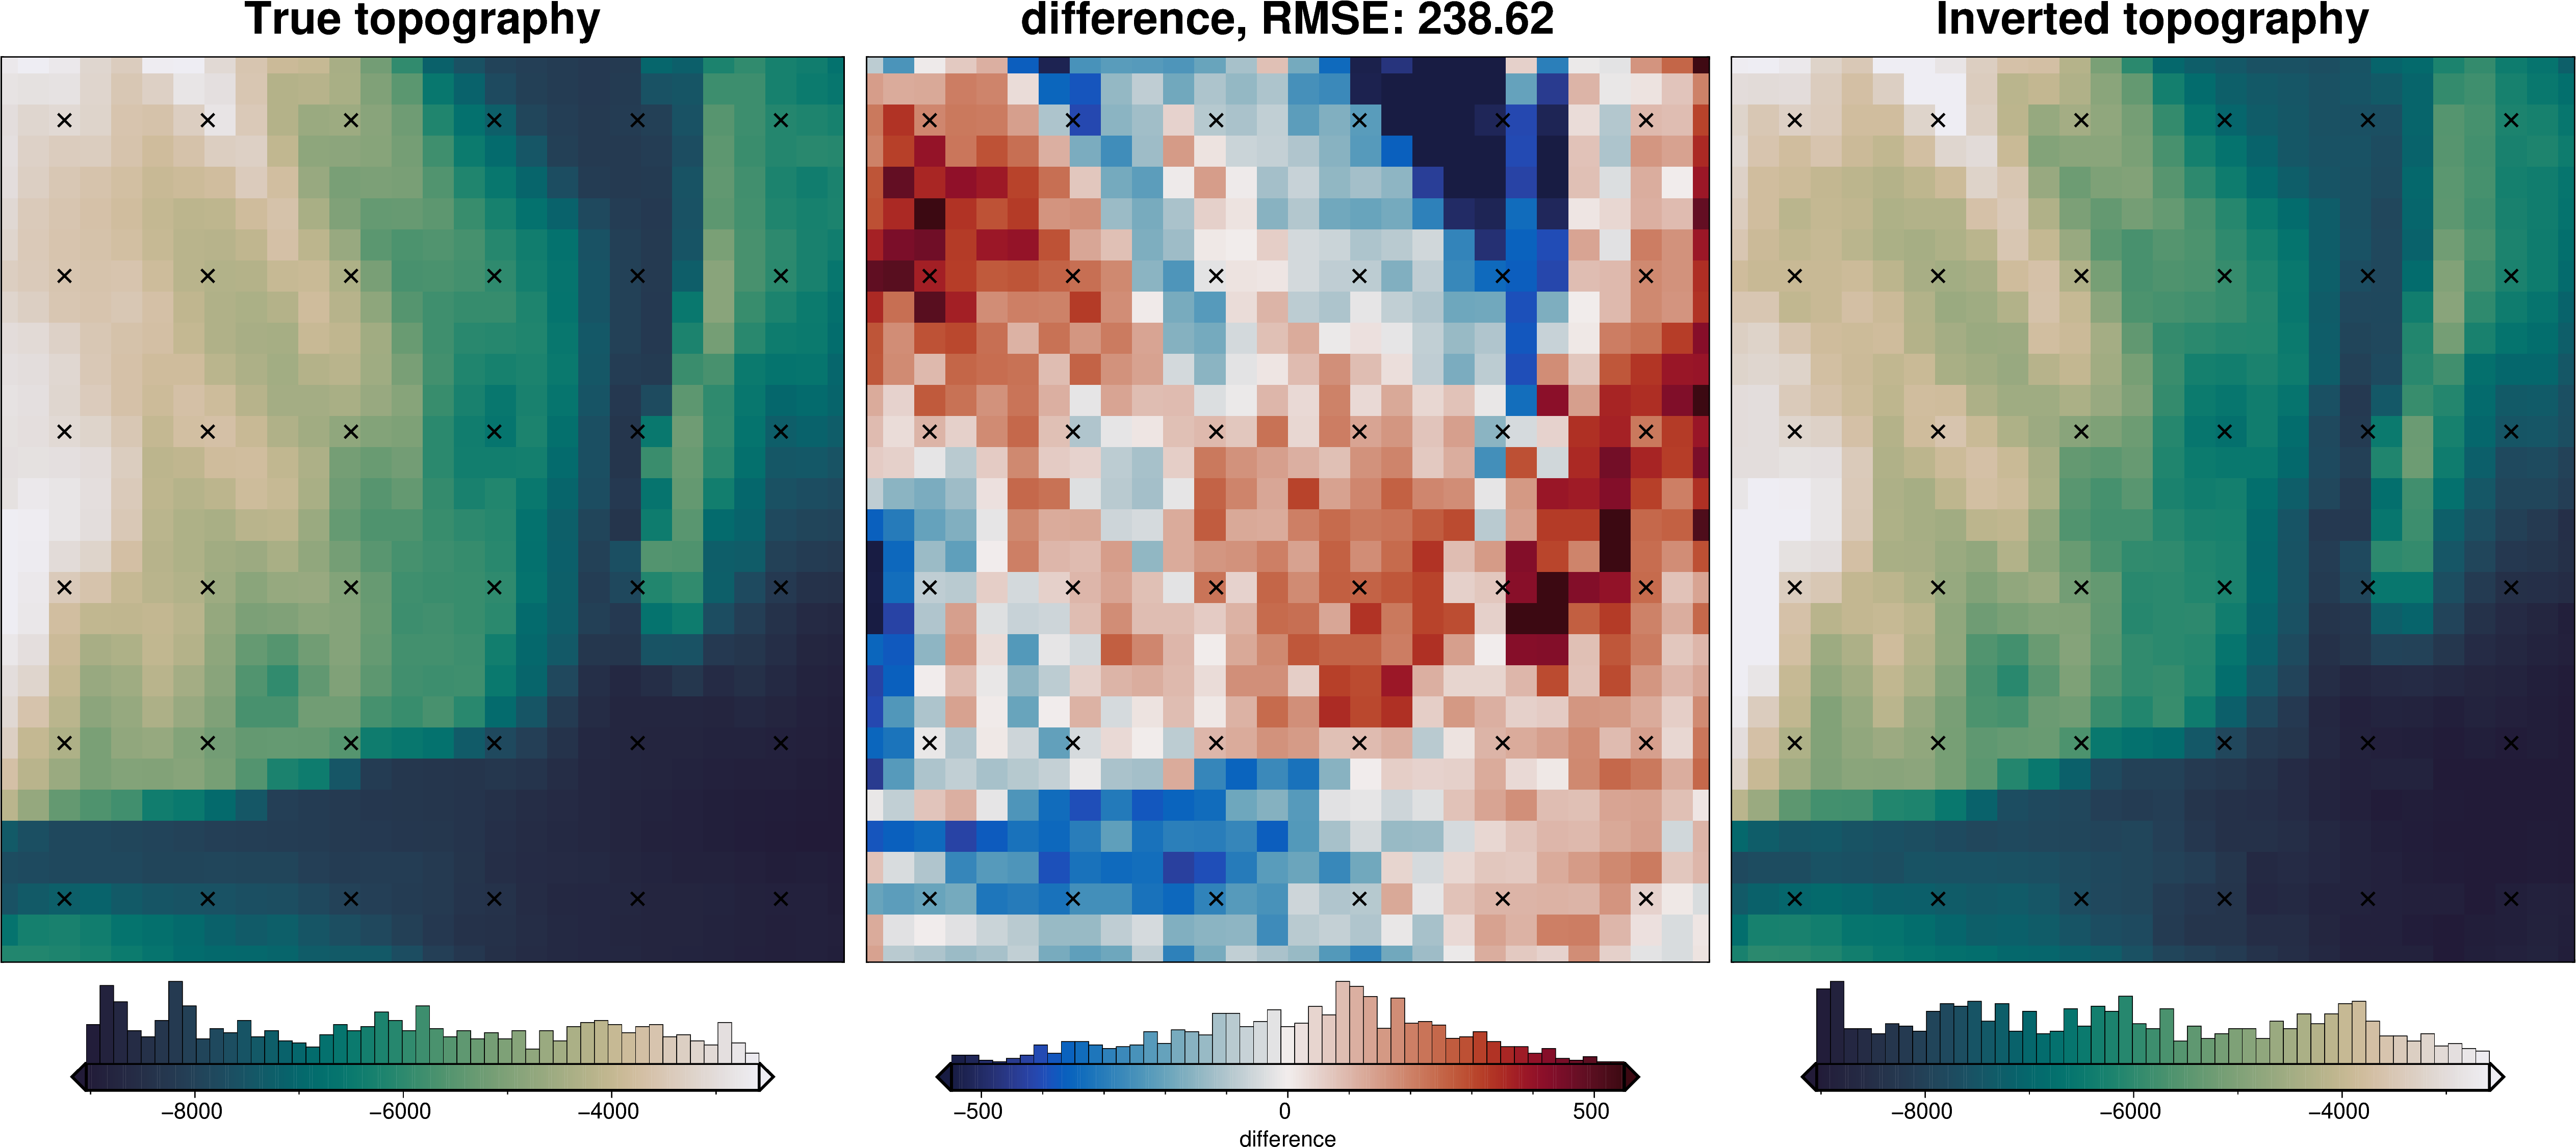

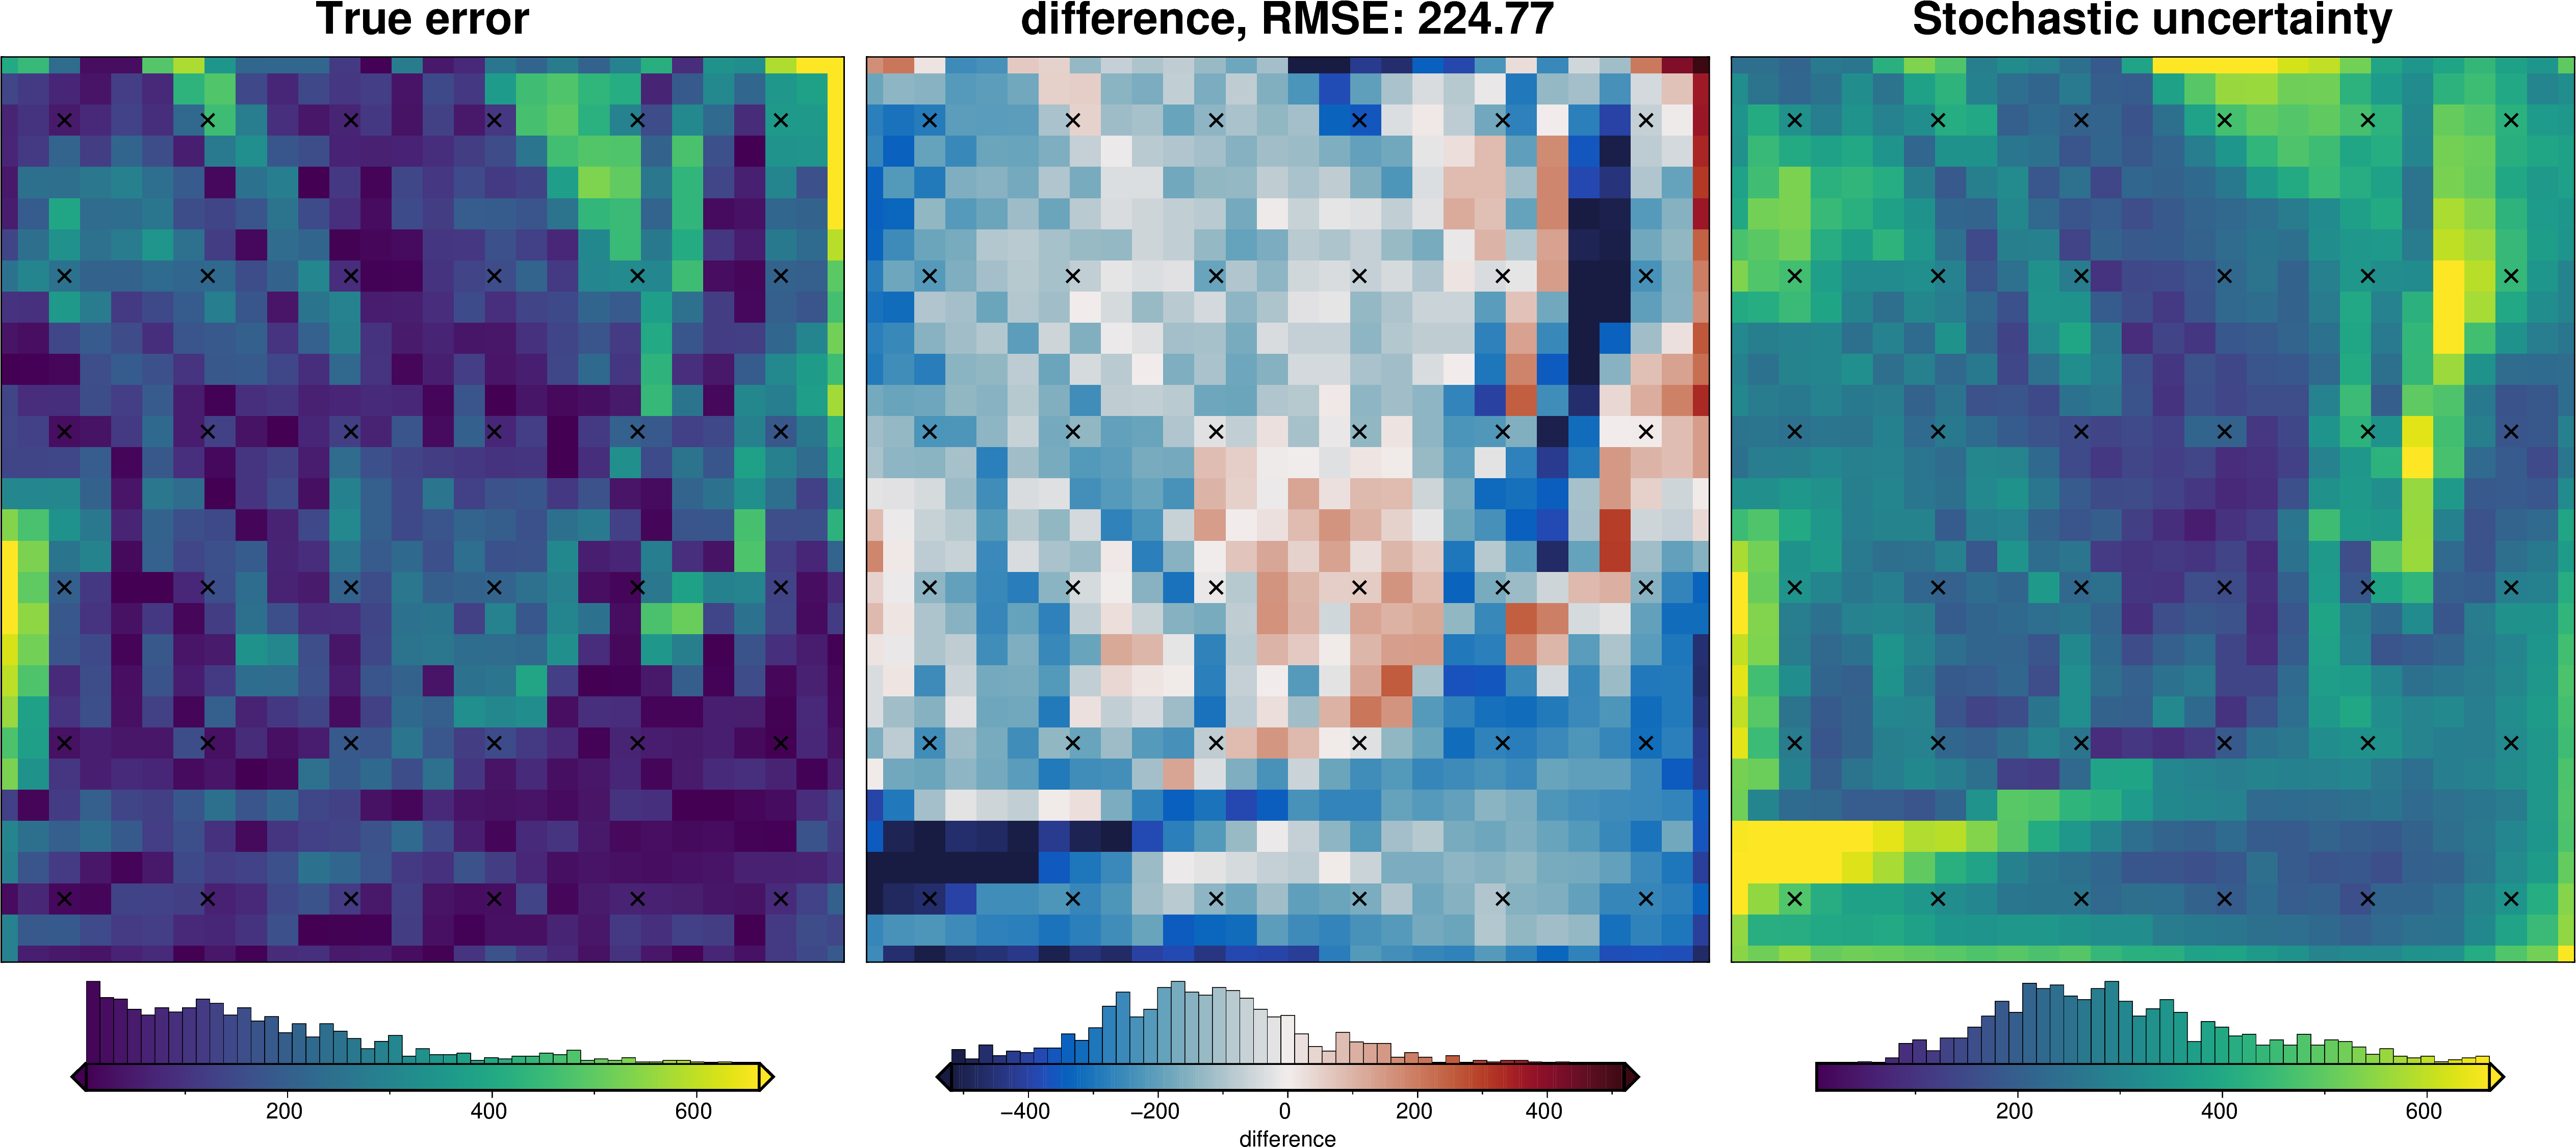

In [54]:
fname = "../tmp/bishop_uncertainty_full"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    sample_gravity=True,
    sample_constraints=True,
    constraints_df=constraint_points,
    starting_topography_kwargs=starting_topography_kwargs,
    parameter_dict=density_dict | zref_dict | solver_dict,
    regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    **uncert_kwargs,
)

uncert_plots(uncert_results)

## Comparing results

In [55]:
results = [
    uncert_results,
    uncert_grav_results,
    uncert_constraints_results,
    uncert_density_results,
    uncert_zref_results,
    uncert_damping_results,
    uncert_regional_results,
]

# get cell-wise stats for each ensemble
stats = []
for r in results:
    ds = uncertainty.merged_stats(
        results=r,
        plot=False,
        constraints_df=constraint_points,
        weight_by="constraints",
    )
    stats.append(ds)

In [56]:
names = [
    "full",
    "grav",
    "constraints",
    "density",
    "zref",
    "damping",
    "regional",
]

# get the standard deviation of the ensemble of ensembles
stdevs = []
for i, s in enumerate(stats):
    stdevs.append(s.weighted_stdev.rename(f"{names[i]}_stdev"))

merged = xr.merge(stdevs)
merged

<xarray.Dataset> Size: 86kB
Dimensions:            (northing: 40, easting: 38)
Coordinates:
  * northing           (northing) float64 320B 1.459e+05 1.559e+05 ... 5.359e+05
  * easting            (easting) float64 304B 6.9e+03 1.69e+04 ... 3.769e+05
Data variables:
    full_stdev         (northing, easting) float64 12kB 334.3 316.2 ... 392.4
    grav_stdev         (northing, easting) float64 12kB 0.1962 0.2604 ... 0.2006
    constraints_stdev  (northing, easting) float64 12kB 425.1 401.1 ... 372.9
    density_stdev      (northing, easting) float64 12kB 6.061 8.395 ... 7.127
    zref_stdev         (northing, easting) float64 12kB 3.344 4.716 ... 0.3275
    damping_stdev      (northing, easting) float64 12kB 4.556 4.842 ... 1.183
    regional_stdev     (northing, easting) float64 12kB 5.474 7.285 ... 3.607

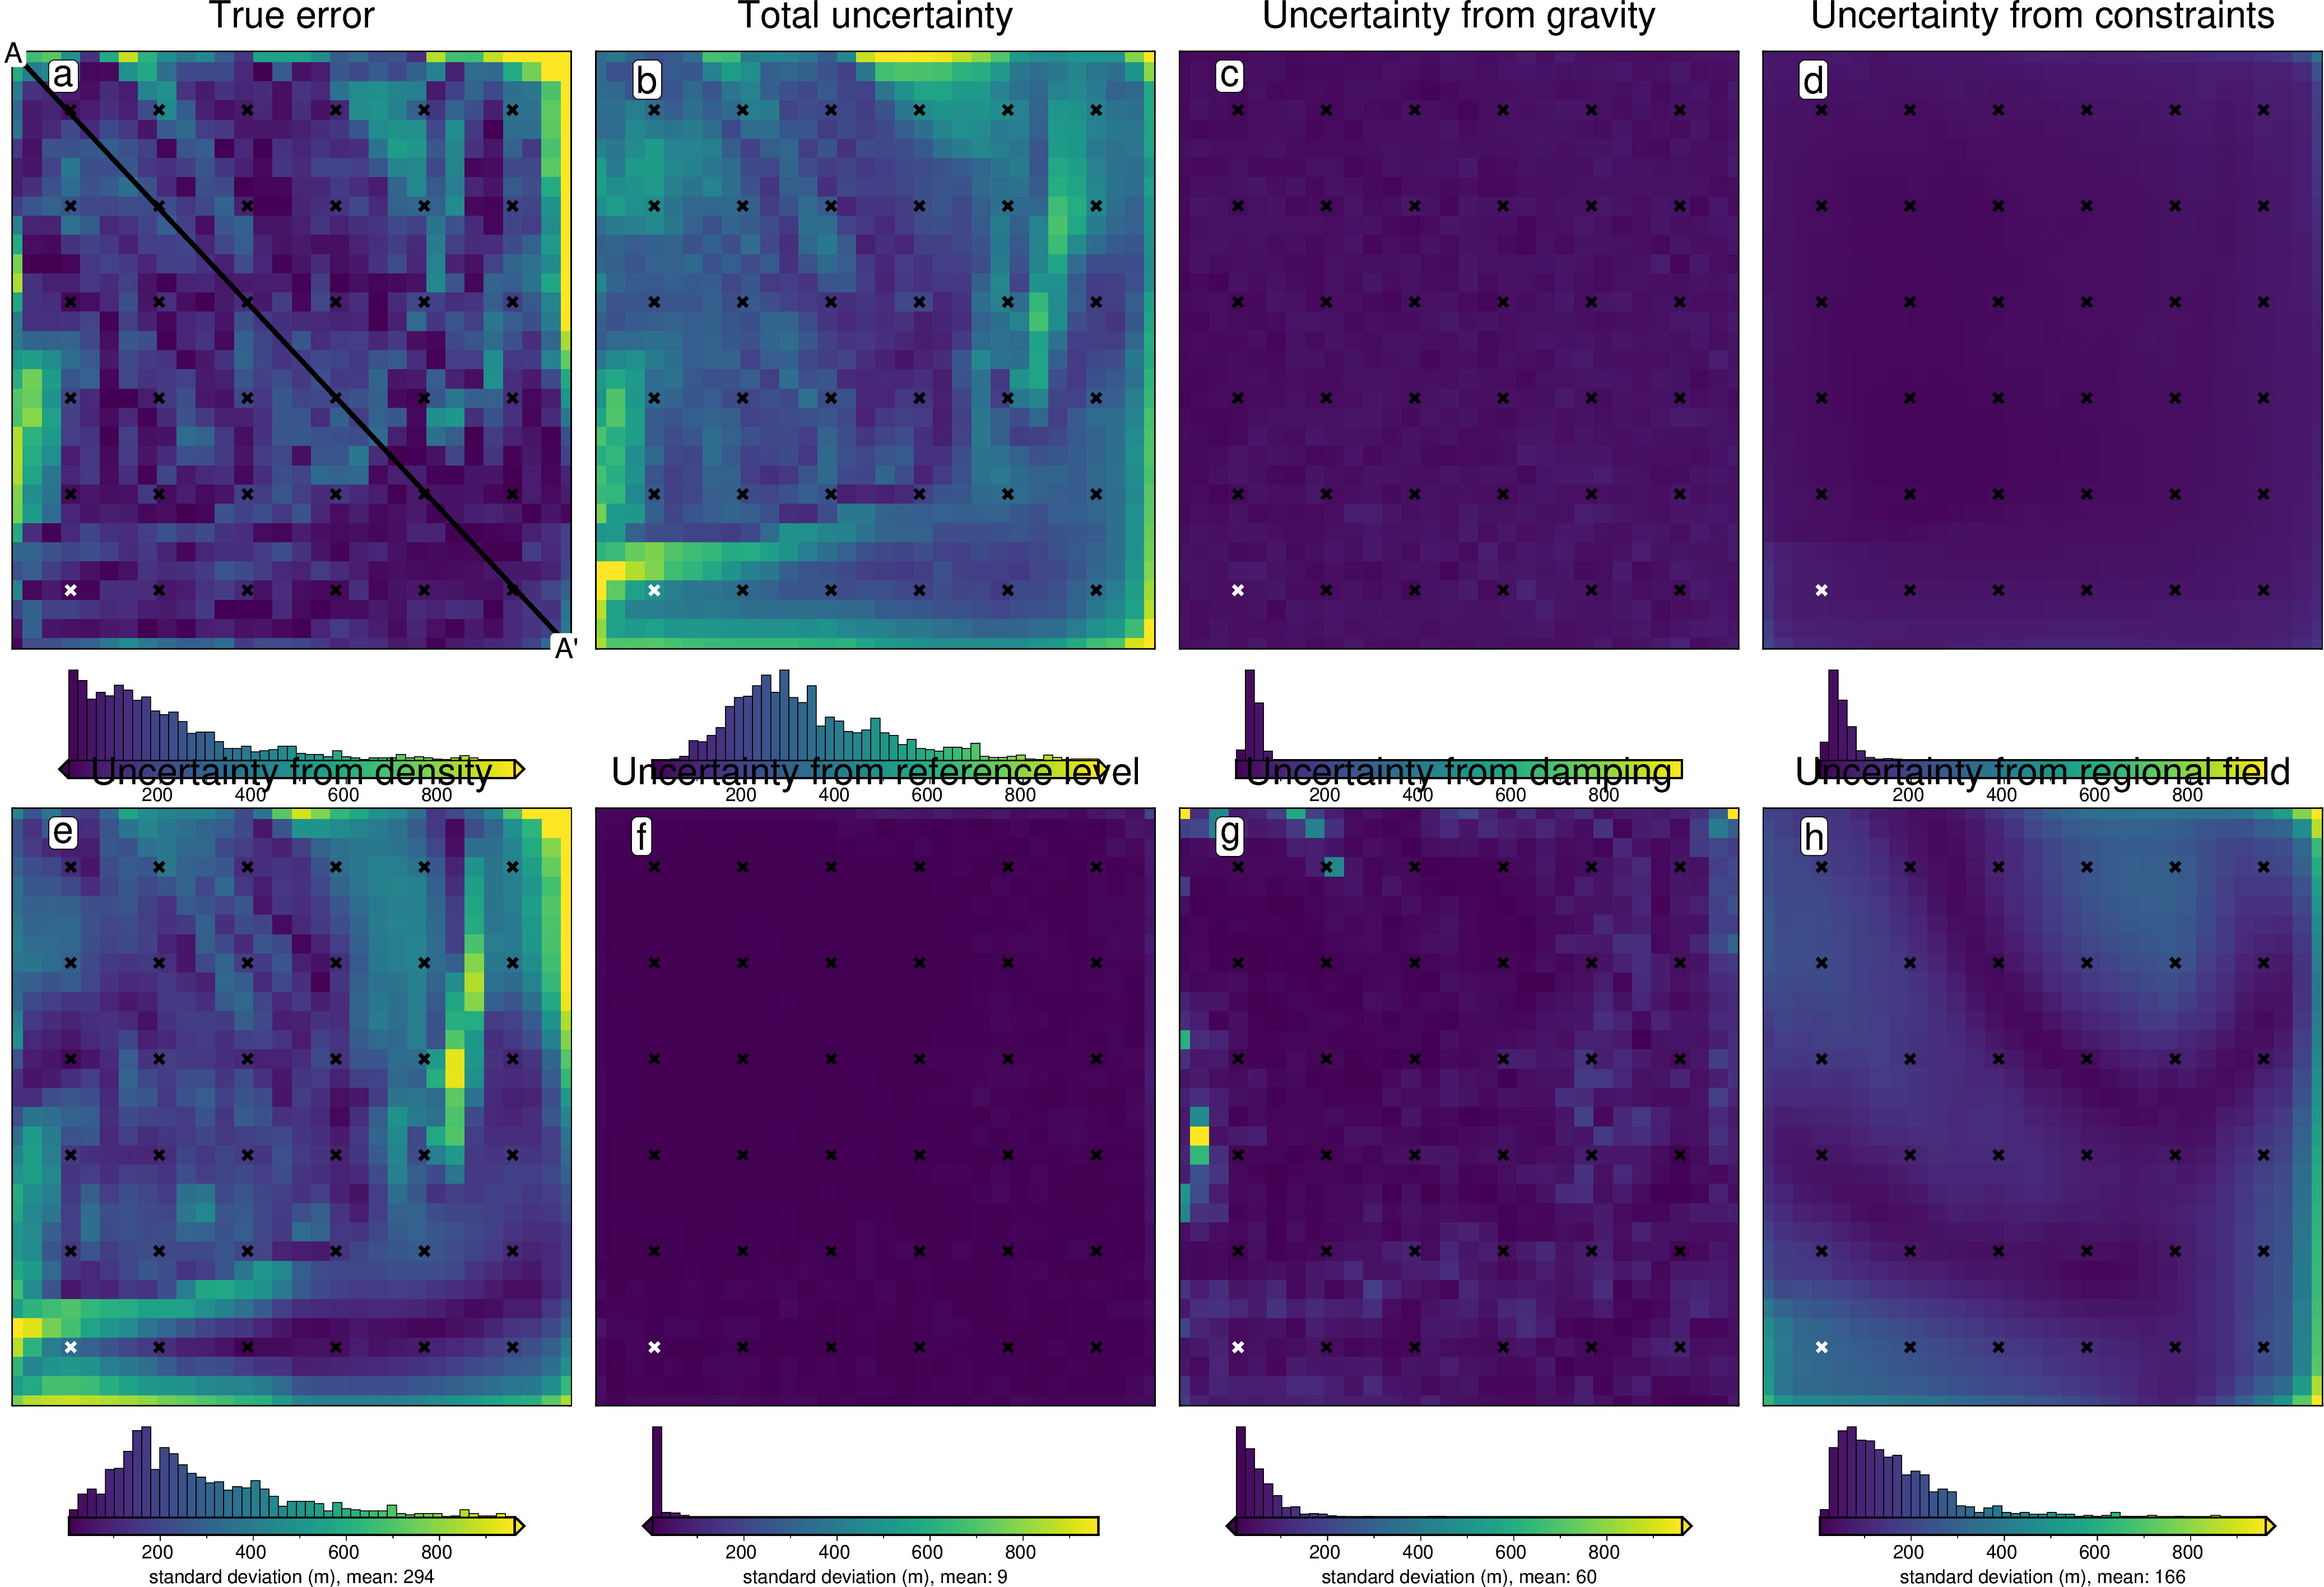

In [57]:
titles = [
    "True error",
    "Total uncertainty",
    "Uncertainty from gravity",
    "Uncertainty from constraints",
    "Uncertainty from density",
    "Uncertainty from reference level",
    "Uncertainty from damping",
    "Uncertainty from regional field",
]
grids = list(merged.data_vars.values())

# grids.insert(0, np.abs(stats[0].weighted_mean - grid.basement_topo))
grids.insert(0, inversion_error)

grids = [
    g.sel(
        {
            "easting": slice(*inversion_region[:2]),
            "northing": slice(*inversion_region[2:]),
        }
    )
    for g in grids
]

fig_height = 9
for i, g in enumerate(grids):
    xshift_amount = 1
    if i == 0:
        fig = None
        origin_shift = "initialize"
        cpt_lims = polar_utils.get_min_max(
            g,
            robust=True,
        )
    elif i == 4:
        origin_shift = "both"
        xshift_amount = -3
    else:
        origin_shift = "x"

    fig = maps.plot_grd(
        grid=g,
        fig_height=fig_height,
        title=titles[i],
        title_font="16p,Helvetica,black",
        # cmap="thermal",
        cpt_lims=cpt_lims,
        robust=True,
        cbar_label=f"standard deviation (m), mean: {int(np.nanmean(g))}",
        hist=True,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=-1.1,
    )
    fig.plot(
        x=constraint_points.easting,
        y=constraint_points.northing,
        style="x.2c",
        pen="1.5p,white",
    )
    fig.text(
        position="TL",
        text=f"{string.ascii_lowercase[i]}",
        fill="white",
        pen=True,
        font="16p,Helvetica,black",
        offset="j.6/.2",
        clearance="+tO",
        no_clip=True,
    )
    if i == 0:
        # plot profile location, and endpoints on map
        start = [inversion_region[0], inversion_region[3]]
        stop = [inversion_region[1], inversion_region[2]]
        fig.plot(
            vd.line_coordinates(start, stop, size=100),
            pen="2p,black",
        )
        fig.text(
            x=start[0],
            y=start[1],
            text="A",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
        fig.text(
            x=stop[0],
            y=stop[1],
            text="A' ",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
fig.show()

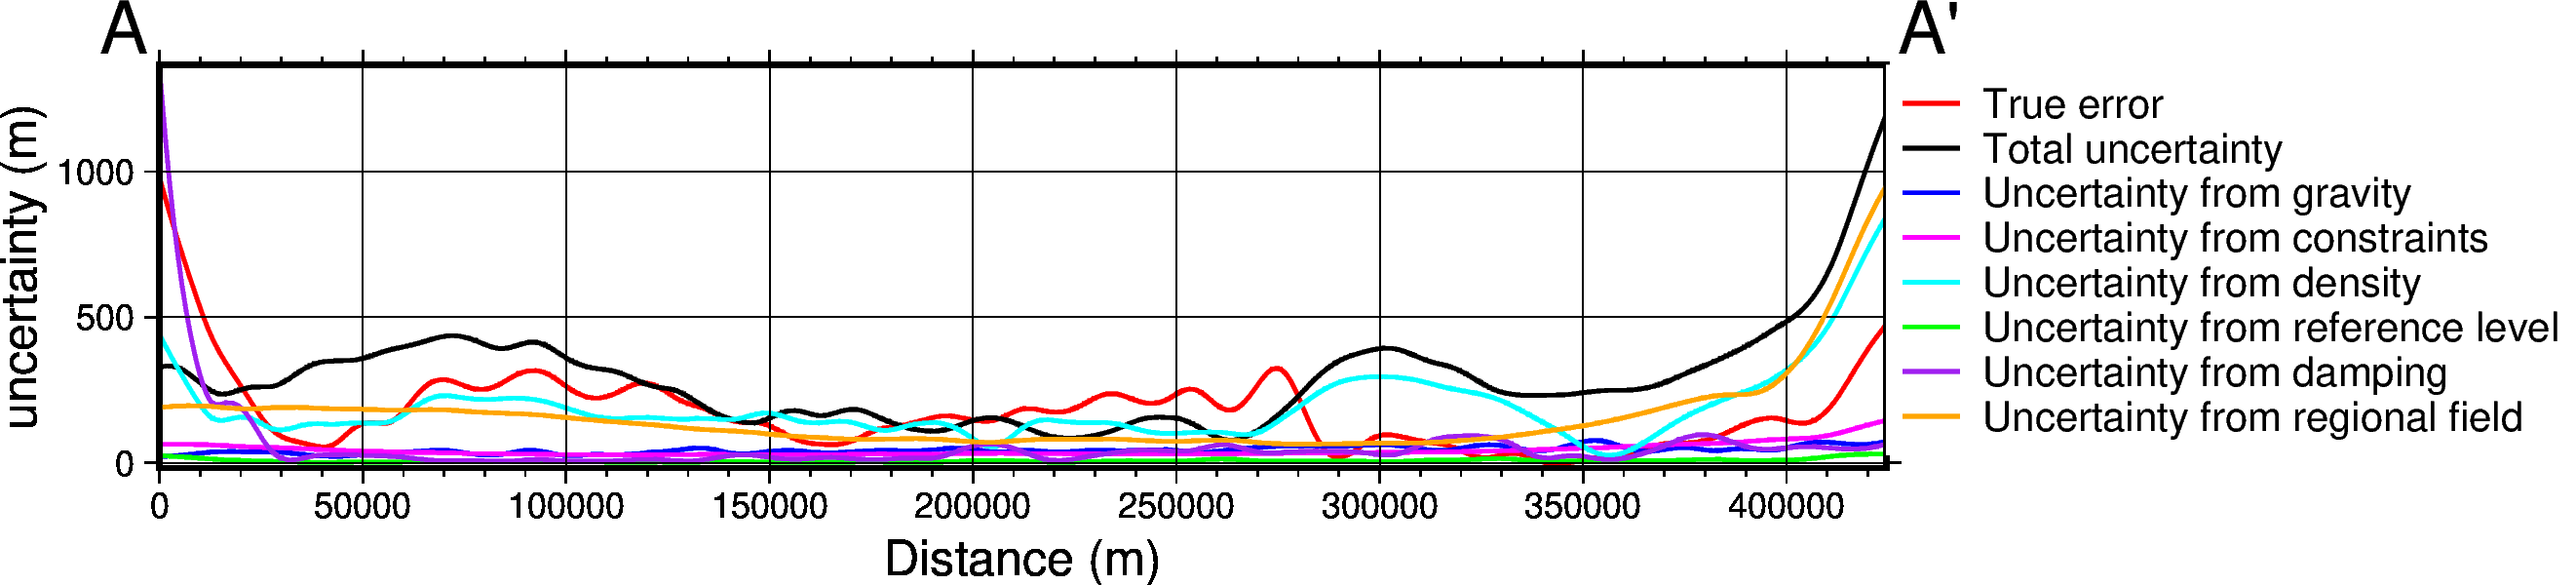

In [58]:
data_dict = profiles.make_data_dict(
    names=titles,
    grids=grids,
    colors=[
        "red",
        "black",
        "blue",
        "magenta",
        "cyan",
        "green",
        "purple",
        "orange",
    ],
)

fig, df_data = profiles.plot_data(
    "points",
    start=[inversion_region[0], inversion_region[3]],
    stop=[inversion_region[1], inversion_region[2]],
    num=10000,
    fig_height=4,
    fig_width=15,
    data_dict=data_dict,
    data_legend_loc="jTR+jTL",
    data_legend_box="+gwhite",
    data_buffer=0.01,
    data_frame=["neSW", "xafg+lDistance (m)", "yag+luncertainty (m)"],
    # data_pen_style=[None,None,"4_2:2p"],
    # data_pen_thickness=[1, 1.5, 1],
    share_yaxis=True,
    start_label="A",
    end_label="A' ",
)
fig.show()